In [1]:
import pickle
import importlib
import os
import time
import re
import math #floor, ceil

import numpy as np
import pandas as pd
import seaborn as sns

#set matplotlib font
import matplotlib
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['font.sans-serif']='Arial'   #Arial
matplotlib.rcParams['font.size']=13   #Arial
#matplotlib.rcParams['figure.dpi']=300           #300 dpi #to be set in savefig, otherwise displayed too large

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

from tfold.utils import seq_tools
from tfold.utils import netmhc_tools
from tfold.utils import utils
from tfold.modeling import result_parse_tools 

#importlib.reload(utils)

date_cutoff='2018-04-30' #AlphaFold training set cutoff

cwd=os.getcwd()
fig_dir=cwd+'/figures_and_tables'

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  4.6 s


In [2]:
#confidence interval for binomial
def summarize_CI(n,N):
    pm,pp=utils.agresti_coull(n,N)
    print('mean: {:5.3f}, CI: {:5.3f}-{:5.3f} ({:4.1f}-{:4.1f})'.format(n/N,pm,pp,pm*N,pp*N))

In [3]:
#load structures
source_dir='./data/experimental_structures/processed_updated'

#pmhc seq clusters selected for modeling
print('pmhcs seq clusters filtered')
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','rb') as f:
    pmhcs_sqf=pickle.load(f) #seq clusters filtered
print(len(pmhcs_sqf))
print(pmhcs_sqf[0].keys())
print()

#pmhcs
print('pmhcs')
with open(source_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
print(pmhcs[0].keys())

#summary
with open(source_dir+'/summary.pckl','rb') as f:
    summary=pickle.load(f)
print(len(summary))

#make dataframes
pmhcs_df=pd.DataFrame(pmhcs_sqf)
pmhcs_df=pmhcs_df.drop(['pdbs'],axis=1)
def _map_pep(x):
    x=x[0]
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):
    x=x[0]
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):
    x=x[0]
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
pmhcs_df['pmhc_id']=pmhcs_df['pmhc_ids'].map(lambda x:x[0]) #keep id of the structure we model
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    pmhcs_df[k]=pmhcs_df['pmhc_ids'].map(lambda x: pmhcs[x[0]][k])
pmhcs_df['pep']=pmhcs_df['pmhc_ids'].map(_map_pep)
pmhcs_df['mhc_a']=pmhcs_df['pmhc_ids'].map(_map_mhc_a)
pmhcs_df['mhc_b']=pmhcs_df['pmhc_ids'].map(_map_mhc_b)
pmhcs_df=pmhcs_df.drop(['pmhc_ids'],axis=1)

#split test
pmhcs_df_test=pmhcs_df[pmhcs_df['date']>=date_cutoff]
pmhcs_df=pmhcs_df[pmhcs_df['date']<date_cutoff]       #drop after cutoff
print('before cutoff:',len(pmhcs_df))
print('after cutoff:',len(pmhcs_df_test))

#cl I and II
struct_i=pmhcs_df[pmhcs_df['class']=='I']
struct_i_test=pmhcs_df_test[pmhcs_df_test['class']=='I']
struct_ii=pmhcs_df[pmhcs_df['class']=='II']
struct_ii_test=pmhcs_df_test[pmhcs_df_test['class']=='II']

pmhcs seq clusters filtered
444
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])

pmhcs
928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq', 'cluster_CA', 'tails', 'netmhc_tails', 'netmhc_kd'])
2382
before cutoff: 332
after cutoff: 112


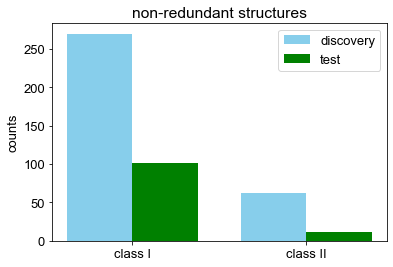

In [36]:
#plot counts
all_ticks=['class I','class II']
discovery_counts={'class I':len(struct_i),'class II':len(struct_ii)}
test_counts={'I':len(struct_i_test),'II':len(struct_ii_test)}
plt.figure()
w=0.3
step=0.8
plt.bar(-w/2+step*np.arange(len(all_ticks)),[discovery_counts[k] for k in all_ticks],width=w,color='skyblue')
plt.bar(w/2+step*np.arange(len(all_ticks)),test_counts.values(),width=w,color='green')
plt.xticks(step*np.arange(len(all_ticks)),all_ticks)#,rotation=45)
plt.legend(['discovery','test'])
plt.title('non-redundant structures')
plt.ylabel('counts')
save_to=fig_dir+'/comp_all.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [33]:
#look at alleles that [Andreatta et al, Immunology 2017] claims bind in non-canonical mode with ~10% frequency
#DRB3*01:01, DRB5*01:01, (DRB1*13:02)
def map_to_allele(x):
    x=x.info
    return x['species'],x['locus'],x['allele']
mhc_array=np.array([list(x) for x in pmhcs_df[pmhcs_df['class']=='II']['mhc_b'].map(map_to_allele).values])
for k in ['DRB1','DRB3','DRB5']:
    print(k)
    print(mhc_array[mhc_array[:,1]==k])
#one DRB3*0101, three DRB5*0101, no DRB1*13:xx
#idea: test register jumping in modeled binding data

DRB1
[['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '15:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '04:04']
 ['9606' 'DRB1' '15:02']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '03:01']
 ['9606' 'DRB1' '04:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '11:01']
 ['9606' 'DRB1' '15:01']
 ['9606' 'DRB1' '04:01']
 ['9606' 'DRB1' '01:01']
 ['9606' 'DRB1' '04:01']
 ['9606' 'DRB1' '04:01']
 ['9606' 'DRB1' '04:01']
 ['9606' 'DRB1' '04:01']]
DRB3
[['9606' 'DRB3' '01:01']
 ['9606' 'DRB3' '03:01']
 ['9606' 'DRB3' '03:01']
 ['9606' 'DRB3' '03:01']]
DRB5
[['9606' 'DRB5' '01:01']
 ['9606' 'DRB5' '01:01']
 ['9606' 'DRB5' '01:01']]


In [11]:
#verify 9mer uniqueness in class II (to be sure tails=cores in regerr counting)
for p in pmhcs:
    if p['class']=='II':
        pseq=''.join(p['P']['data']['seq'])
        ninemers=[pseq[i:i+9] for i in range(len(p)-9)]
        if len(ninemers)!=len(set(ninemers)):
            print(pseq)
#conclusion: except for poly-X, all cores within a cl II peptide are different

XXXXXXXXXXXXX


# dataset statistics

In [28]:
# unique pmhcs, by species and class
stats={'class':[],'species':[]}
for x in pmhcs:
    if 'N' in x:
        k='N'
    else:
        k='M'
    stats['class'].append(x[k]['info']['class'])
    stats['species'].append(x[k]['info']['species'])
stats=pd.DataFrame(stats)
stats['species']=stats['species'].map(lambda x:seq_tools.species[x][2])
print('total pmhcs:',len(stats))
print('total species:',len(stats['species'].unique()))
#species table
x=stats.groupby(['species','class']).apply(len).reset_index().pivot(index='species',columns='class').fillna(0)
x.columns=['I','II']
x=x.sort_values('I',ascending=False)
x=x.astype(int)
def capitalize_first(s):
    s1=[]
    for a in s.split('_'):
        s1.append(a[0].upper()+a[1:])
    return ' '.join(s1)
x.index=x.index.map(capitalize_first)
x.to_excel(fig_dir+'/pmhcs_by_species.xlsx')
x

total pmhcs: 928
total species: 12


,I,II
species,,
Human,555,97
Mouse,174,32
Chicken,19,0
Feral Pig,18,0
Sooty Mangabey,8,0
Horse,7,0
Norway Rat,5,0
Rhesus monkey,5,0
Cattle,4,0


# load and analyze tfold results

In [4]:
#plotting functions
def _color_by_regerr(x,notident_separate=False):
    '''
    notident_separate: cases where register not identified to be marked separately
    or as regerr (default)
    '''
    if not x['register_identified']:
        if notident_separate:
            return 'not identified'
        else:
            return 'incorrect'
    elif x['tails']!=x['af_tails']:
        return 'incorrect'
    else:
        return 'correct'
def summarize_results(df_list,names_list,ylim=None,label_core=False,save_to=None):    
    df_list=[x.copy() for x in df_list]
    n_fail=[np.sum(~x['register_identified']) for x in df_list]
    n_regerr=[np.sum(x['register_identified']&(x['tails']!=x['af_tails'])) for x in df_list]
    #good_df_list=[x[(x['tails']==x['af_tails'])&(x['register_identified'])] for x in df_list]    
    good_df_list=df_list #median and mean for all
    for name, fail, regerr in zip(names_list,n_fail,n_regerr):
        print('{:10s}: fails: {:2d}, regerr: {:2d}'.format(name, fail, regerr))    
    print('median:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].median()))
        print('{:10s}: '.format(name)+', '.join(s))
    print('mean:')
    for name, df in zip(names_list,good_df_list):
        s=[]
        for k in ['pep_CA','pep_all','mhc_CA','mhc_all']:
            s.append('{:s}: {:4.2f}'.format(k,df[k].mean()))
        print('{:10s}: '.format(name)+', '.join(s))       
    for name,df in zip(names_list,df_list):
        df['model selection']=[name]*len(df)    
    df=pd.concat(df_list)
    df['register']=df.apply(_color_by_regerr,axis=1)
    #df=df.rename({'pep_CA':r'pep backbone RMSD, $\AA$'},axis=1) 
    plt.figure()
    sns.boxplot(data=df,y='pep_CA',x='model selection',color='lightgray',fliersize=0)
    ax=sns.stripplot(data=df,y='pep_CA',x='model selection',hue='register',marker='.')
    if label_core:
        s='c'
    else:
        s='p'
    ax.set(ylabel=r'$C_\alpha$-'+f'{s}RMSD,'+r' $\AA$')
    sns.move_legend(ax,'upper center')
    if ylim:
        plt.ylim(0,ylim)
    if save_to:
        plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
    plt.show()
#hill_colors=['rosybrown','lightcoral','indianred','brown','maroon']
hill_colors=['lightgray','darkgray','dimgray','black']
def make_hill_plot(rmsds,scores,rmsd_bins,
                   bad_threshold=1.5,loc=None,xticks=None,xlabel=None,use_log=True,rho_x=None,
                   return_frac=False,save_to=None): 
    rmsd_bins_ext=[0.]+rmsd_bins+[10000.]
    scores=np.array(scores)
    score_bins=np.sort(np.unique(scores))
    score_bins=[0.99*score_bins[0]]+list(score_bins)+[1.01*score_bins[-1]]    
    counts=[]
    for s in score_bins:        
        r=rmsds[scores<s]
        counts.append([np.sum((r>=rmsd_bins_ext[i])&(r<rmsd_bins_ext[i+1])) for i in range(len(rmsd_bins_ext)-1)])
    counts=np.stack(counts).T/len(rmsds) #fractions, (n_groups,n_score_thresholds)
    counts_at_half=counts[:,np.sum(counts,axis=0)>0.5][:,0]
    if return_frac:
        return counts_at_half
    print(counts_at_half) #fractions for threshold when half models pass
    if use_log:
        l_score_bins=np.log(score_bins)
    else:
        l_score_bins=score_bins
    plt.figure()
    plt.stackplot(l_score_bins,counts,colors=hill_colors[:len(rmsd_bins)+1]) 
    if (xticks is None):
        xticks=np.concatenate([np.arange(0,90,5),np.arange(90,101)])
        xticks=100-xticks
        xticks=xticks[(xticks>=score_bins[0])*(xticks<=score_bins[-1])]
    if use_log:
        l_xticks=np.log(xticks)
    else:
        l_xticks=xticks
    plt.xticks(l_xticks,xticks)
    plt.xlim(l_score_bins[0],l_score_bins[-1])
    loc=loc or 'lower right'
    plt.legend([r'$<$'+f'{r} '+r'$\AA$' for r in rmsd_bins]+[r'$\geq$'+f'{rmsd_bins[-1]} '+r'$\AA$'],loc=loc)
    #plt.axhline(0.5)
    plt.grid(axis='y')
    if not xlabel:
        xlabel='100 - pLDDT'
    plt.xlabel(xlabel)
    #rank corr
    rho=spearmanr(rmsds,scores).correlation
    if rho_x is None:
        rho_x=l_xticks[-1]
    plt.text(rho_x,0.9,r'$\rho=$'+'{:4.2f}'.format(rho))
    #mark median score
    median_score=np.median(scores)
    print('median score:',median_score)
    if use_log:
        l_median_score=np.log(median_score)
    else:
        l_median_score=median_score
    plt.axvline(l_median_score,linestyle='--',color='gray')
    #fractions of bads in top/bottom 50%
    x=rmsds[scores<median_score]
    frac_best=np.sum(x>bad_threshold)/len(x)
    txt_best=f'RMSD > {bad_threshold}'+r'$\AA$: '+'{:4.1f}%  '.format(frac_best*100)
    plt.text(l_median_score,0.7,txt_best,
            horizontalalignment='right',
            verticalalignment='baseline')
    x=rmsds[scores>=median_score]
    frac_worst=np.sum(x>bad_threshold)/len(x)
    txt_worst=' {:4.1f}%'.format(frac_worst*100)
    plt.text(l_median_score,0.7,txt_worst,
            horizontalalignment='left',
            verticalalignment='baseline')
    if save_to:
        plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
    plt.show()

DISCOVERY
linkers: 332 20
I
no regerr with linker: 2 without linker 266
regerr with linker: 0 without linker 2
best pLDDT: fails:  0, regerr:  2
best RMSD : fails:  0, regerr:  2
median:
best pLDDT: pep_CA: 0.73, pep_all: 1.55, mhc_CA: 0.45, mhc_all: 1.13
best RMSD : pep_CA: 0.64, pep_all: 1.41, mhc_CA: 0.45, mhc_all: 1.13
mean:
best pLDDT: pep_CA: 1.00, pep_all: 1.83, mhc_CA: 0.53, mhc_all: 1.19
best RMSD : pep_CA: 0.86, pep_all: 1.65, mhc_CA: 0.52, mhc_all: 1.19


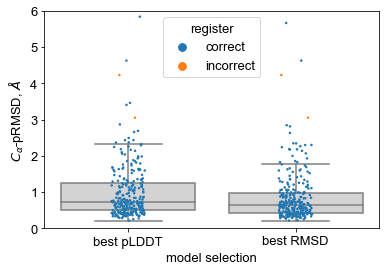

[0.41481481 0.06666667 0.01851852 0.0037037 ]
median score: 5.994052525974865


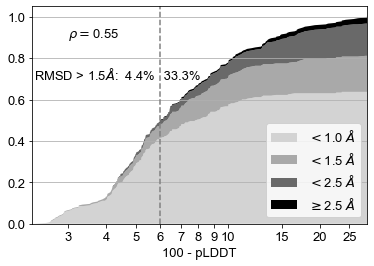

II
no regerr with linker: 18 without linker 43
regerr with linker: 0 without linker 1
best pLDDT: fails:  0, regerr:  1
best RMSD : fails:  0, regerr:  0
median:
best pLDDT: pep_CA: 0.46, pep_all: 1.18, mhc_CA: 0.44, mhc_all: 1.09
best RMSD : pep_CA: 0.44, pep_all: 1.17, mhc_CA: 0.44, mhc_all: 1.11
mean:
best pLDDT: pep_CA: 0.65, pep_all: 1.35, mhc_CA: 0.47, mhc_all: 1.12
best RMSD : pep_CA: 0.52, pep_all: 1.22, mhc_CA: 0.48, mhc_all: 1.14


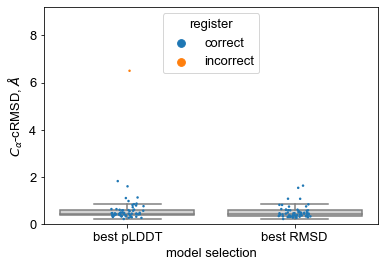

[0.46774194 0.03225806 0.01612903 0.        ]
median score: 2.9772097100538275


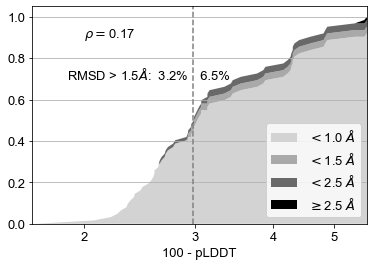

TEST
linkers: 112 6
I
no regerr with linker: 2 without linker 96
regerr with linker: 0 without linker 3
best pLDDT: fails:  1, regerr:  2
best RMSD : fails:  1, regerr:  2
median:
best pLDDT: pep_CA: 0.77, pep_all: 1.77, mhc_CA: 0.47, mhc_all: 1.15
best RMSD : pep_CA: 0.64, pep_all: 1.55, mhc_CA: 0.46, mhc_all: 1.15
mean:
best pLDDT: pep_CA: 1.07, pep_all: 2.00, mhc_CA: 0.52, mhc_all: 1.19
best RMSD : pep_CA: 0.89, pep_all: 1.77, mhc_CA: 0.52, mhc_all: 1.20


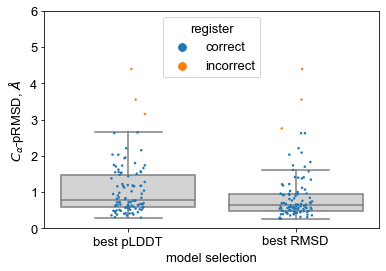

[0.3960396  0.04950495 0.05940594 0.        ]
median score: 6.80844065875938


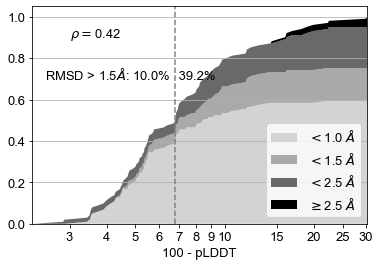

II
no regerr with linker: 3 without linker 7
regerr with linker: 1 without linker 0
best pLDDT: fails:  0, regerr:  1
best RMSD : fails:  0, regerr:  0
median:
best pLDDT: pep_CA: 0.46, pep_all: 1.07, mhc_CA: 0.43, mhc_all: 1.10
best RMSD : pep_CA: 0.41, pep_all: 1.04, mhc_CA: 0.41, mhc_all: 1.07
mean:
best pLDDT: pep_CA: 0.81, pep_all: 1.63, mhc_CA: 0.51, mhc_all: 1.19
best RMSD : pep_CA: 0.48, pep_all: 1.20, mhc_CA: 0.46, mhc_all: 1.14


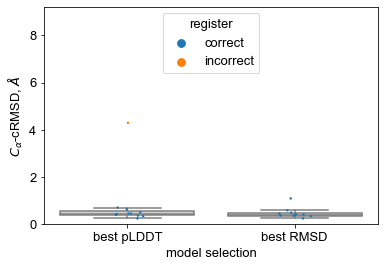

[0.54545455 0.         0.         0.        ]
median score: 3.880643217997175


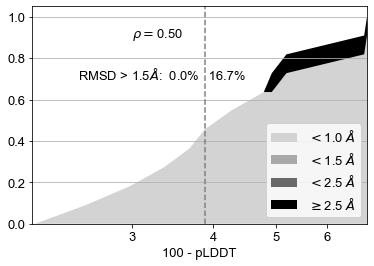

In [5]:
#load tfold results

##discovery##
print('DISCOVERY')
run_n=11 #new canonical run for discovery dataset (incl cl II paired MSA)
tfold_discovery_dir='/scratch/vmikhayl/pmhc_modeling/discovery_dataset'
ctarget_dir=tfold_discovery_dir+f'/run_{run_n}'
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
#add linker info
pmhc_ids=result_df['pmhc_id'].unique()
linker_list=[]
for pmhc_id in pmhc_ids:
    pmhc=pmhcs[pmhc_id]
    pdb_ids=[x[0] for x in pmhc['pdbs']]
    linker=False
    for pdb_id in pdb_ids:
        c_linker=np.any(summary[pdb_id]['P']['info']['linker'])
        linker=linker or c_linker
    linker_list.append(linker)
linker_list=pd.Series(linker_list,index=pmhc_ids,name='linker')
print('linkers:',len(linker_list),np.sum(linker_list.values))
result_df=result_df.merge(linker_list,left_on='pmhc_id',right_index=True)
#add score
result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#reduce and plot
ylim0={'I':6.,'II':9.2}
tfold_discovery_dfs={}
for cl in ['I','II']:
    print(cl)
    df0=result_df[result_df['class']==cl].copy()
    df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
    df_lddt=df_lddt.reset_index(drop=True)
    tfold_discovery_dfs[cl]=df_lddt
    #regerr by linker
    x_good=df_lddt[df_lddt['tails']==df_lddt['af_tails']]['linker']
    print('no regerr with linker:',np.sum(x_good),'without linker',len(x_good)-np.sum(x_good))
    x_bad=df_lddt[df_lddt['tails']!=df_lddt['af_tails']]['linker']
    print('regerr with linker:',np.sum(x_bad),'without linker',len(x_bad)-np.sum(x_bad))          
    df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
    df_rmsd=df_rmsd.reset_index(drop=True)    
    ylim=df_lddt['pep_CA'].max()
    if ylim>ylim0[cl]:
        print('CHECK ylim!',ylim)
    fname=fig_dir+f'/rmsd_discovery_{cl}.pdf'
    label_core=cl=='II' #label y as 'core rmsd' instead of 'pep rmsd'
    summarize_results([df_lddt,df_rmsd],['best pLDDT','best RMSD'],ylim0[cl],label_core=label_core,save_to=fname)
    fname=fig_dir+f'/lddt_discovery_{cl}.pdf'
    make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5],save_to=fname)
    xx,yy=df_lddt['pep_CA'],df_lddt['score'] #save

##test##
print('TEST')
tfold_test_dir='/scratch/vmikhayl/pmhc_modeling/test_dataset'
ctarget_dir=tfold_test_dir
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
#add linker info
pmhc_ids=result_df['pmhc_id'].unique()
linker_list=[]
for pmhc_id in pmhc_ids:
    pmhc=pmhcs[pmhc_id]
    pdb_ids=[x[0] for x in pmhc['pdbs']]
    linker=False
    for pdb_id in pdb_ids:
        c_linker=np.any(summary[pdb_id]['P']['info']['linker'])
        linker=linker or c_linker
    linker_list.append(linker)
linker_list=pd.Series(linker_list,index=pmhc_ids,name='linker')
print('linkers:',len(linker_list),np.sum(linker_list.values))
result_df=result_df.merge(linker_list,left_on='pmhc_id',right_index=True)
#add score
result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#reduce and plot
tfold_test_dfs={}
for cl in ['I','II']:
    print(cl)
    df0=result_df[result_df['class']==cl].copy()
    df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
    df_lddt=df_lddt.reset_index(drop=True)
    tfold_test_dfs[cl]=df_lddt
    #regerr by linker
    x_good=df_lddt[df_lddt['tails']==df_lddt['af_tails']]['linker']
    print('no regerr with linker:',np.sum(x_good),'without linker',len(x_good)-np.sum(x_good))
    x_bad=df_lddt[df_lddt['tails']!=df_lddt['af_tails']]['linker']
    print('regerr with linker:',np.sum(x_bad),'without linker',len(x_bad)-np.sum(x_bad))          
    df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
    df_rmsd=df_rmsd.reset_index(drop=True)    
    ylim=df_lddt['pep_CA'].max()
    if ylim>ylim0[cl]:
        print('CHECK ylim!',ylim)
    fname=fig_dir+f'/rmsd_test_{cl}.pdf'
    label_core=cl=='II' #label y as 'core rmsd' instead of 'pep rmsd'
    summarize_results([df_lddt,df_rmsd],['best pLDDT','best RMSD'],ylim0[cl],label_core=label_core,save_to=fname)
    fname=fig_dir+f'/lddt_test_{cl}.pdf'
    make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5],save_to=fname)
    xx,yy=df_lddt['pep_CA'],df_lddt['score'] #save

    
#use tfold_discovery_dfs and tfold_test_dfs in further analysis (reduced results)

In [56]:
#save datasets
def _one_mhc_to_str(m):
    return m.info['locus']+'*'+m.info['allele']
def _mhcs_to_str(x):
    species=x['mhc_a'].info['species']
    if species=='9606':
        species='HLA'
    elif species=='10090':
        species='H2'
    a=species+'-'+_one_mhc_to_str(x['mhc_a'])
    if not (x['mhc_b'] is None):
        a+='/'+_one_mhc_to_str(x['mhc_b'])
    return a
dfs_processed={}
for dfs,name in zip([tfold_discovery_dfs,tfold_test_dfs],['discovery','test']):
    for cl in ['I','II']:
        x=dfs[cl].copy()
        x['MHC allele']=x.apply(_mhcs_to_str,axis=1)
        x['MHC sequence']=x['mhc_a'].map(lambda s:s.seq())
        if cl=='II':
            x['MHC sequence']+='/'+x['mhc_b'].map(lambda s:s.seq())
        x['MHC mutations']=x['mhc_a'].map(lambda m:np.sum(m.data['mutations']!=''))
        if cl=='II':
            x['MHC mutations']+=x['mhc_b'].map(lambda m:np.sum(m.data['mutations']!=''))            
        x=x[['pep','MHC allele','MHC mutations','MHC sequence','class',
            'pmhc_id','cluster_seq','pdb_id','date',
            'tails','netmhc_tails','netmhc_kd','linker']].copy()
        print(name,cl)
        print(x.head(5))
        x.to_csv(f'./data/examples/{name}_{cl}.csv',index=False)
        dfs_processed[name,cl]=x
        
#save some examples from test for illustration
x=pd.concat([dfs_processed['test','I'][dfs_processed['test','I']['pmhc_id'].isin([12,273,921])],
             dfs_processed['test','II'][dfs_processed['test','II']['pmhc_id'].isin([595])]])
x=x[['pep','MHC allele','pdb_id']].copy()
x.to_csv(f'./data/examples/sample.csv',index=False)
print(x)

discovery I
         pep   MHC allele  MHC mutations  \
0  EEAGRAFSF  HLA-B*44:02              0   
1  NLVPMVATV  HLA-A*02:01              0   
2  GRFAAAIAK  HLA-B*27:05              0   
3  ASNEHMETM       H2-D*b              0   
4  QASQDVKNW  HLA-B*58:01              0   

                                        MHC sequence class  pmhc_id  \
0  GSHSMRYFYTAMSRPGRGEPRFITVGYVDDTLFVRFDSDATSPRKE...     I        1   
1  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...     I        4   
2  GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREE...     I        5   
3  GPHSMRYFETAVSRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYE...     I        7   
4  GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTE...     I        8   

   cluster_seq  pdb_id        date   tails netmhc_tails   netmhc_kd  linker  
0            1  3l3d_0  2002-07-17  (0, 0)       (0, 0)   60.973160   False  
1            4  3gso_0  2009-03-27  (0, 0)       (0, 0)   17.914938   False  
2            5  1jge_0  2001-06-25  (0, 0)       (0, 0)   41.5

In [16]:
#median rmsd on top half by score
x=tfold_test_dfs['I']
print(x['score'].median())
print(x[x['score']<x['score'].median()]['pep_CA'].median())

6.80844065875938
0.6371000918848189


In [43]:
#regerr and exceptions to register rules (in discovery)
cl='I'
x=tfold_discovery_dfs[cl]
print(f'exceptions to cl {cl} register rules:')
print(x[x['tails'].map(lambda a:a[0]*a[1]!=0)][['pmhc_id','af_tails','tails']])
print(f'cl {cl} regerr:')
print(x[x['af_tails']!=x['tails']][['pmhc_id','af_tails','tails']])

cl='II'
x=tfold_discovery_dfs[cl].copy()
x['mhc']=x['mhc_b'].map(lambda a:(a.info['locus'],a.info['allele']))
print(f'exceptions to cl {cl} register rules:')
print(x[x['tails'].map(lambda a:(a[0]<0)|(a[1]<0))][['pmhc_id','af_tails','tails','mhc','tpl_tails','netmhc_tails','pdb_id']])
print(f'cl {cl} regerr:')
print(x[x['af_tails']!=x['tails']][['pmhc_id','af_tails','tails','mhc']])
x.columns

exceptions to cl I register rules:
    pmhc_id af_tails    tails
92      185   (0, 0)  (-1, 1)
cl I regerr:
     pmhc_id af_tails    tails
92       185   (0, 0)  (-1, 1)
182      484   (0, 0)   (0, 1)
exceptions to cl II register rules:
    pmhc_id af_tails    tails            mhc tpl_tails netmhc_tails  pdb_id
21      248  (-1, 2)  (-1, 2)  (DRB1, 01:01)    (0, 1)       (1, 0)  4gbx_0
cl II regerr:
    pmhc_id af_tails   tails            mhc
52      754   (4, 1)  (2, 3)  (DQB1, 03:02)


Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'linker', 'score', 'mhc'],
      dtype='object')

linker: 2 no linker: 268
linker    : fails:  0, regerr:  0
no linker : fails:  0, regerr:  2
median:
linker    : pep_CA: 0.52, pep_all: 1.10, mhc_CA: 0.55, mhc_all: 1.12
no linker : pep_CA: 0.73, pep_all: 1.55, mhc_CA: 0.45, mhc_all: 1.13
mean:
linker    : pep_CA: 0.52, pep_all: 1.10, mhc_CA: 0.55, mhc_all: 1.12
no linker : pep_CA: 1.00, pep_all: 1.83, mhc_CA: 0.53, mhc_all: 1.20


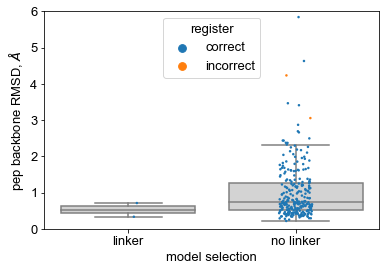

In [27]:
#class I linker vs no linker (discovery set class I)
#use discovery because want to test AF overfitting!
df_lddt=tfold_discovery_dfs['I']
df_lddt=df_lddt.reset_index(drop=True)
print('linker:',np.sum(df_lddt['linker']),'no linker:',len(df_lddt)-np.sum(df_lddt['linker']))

fname=None
summarize_results([df_lddt[df_lddt['linker']],df_lddt[~df_lddt['linker']]],
                  ['linker','no linker'],ylim0['I'],label_core=False,save_to=fname)

#conclusion: too few with linker!

In [162]:
#class II above 1A
print('DISCOVERY')
x=tfold_discovery_dfs['II'].copy()
print('total:',len(x),'with linker:',np.sum(x['linker']))
x=x[x['pep_CA']>1.]
print('above 1A:',len(x))
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score']])

print('TEST')
x=tfold_test_dfs['II'].copy()
print('total:',len(x),'with linker:',np.sum(x['linker']))
x=x[x['pep_CA']>1.]
print('above 1A:',len(x))
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score']])

#conclusion:
#subangstrom models among those with correctly predicted register
#discovery: (61-4)/61=
#test: 100%

#class II discovery above 1.5 A: among all and among score<median
print('DISCOVERY')
x=tfold_discovery_dfs['II'].copy()
print('total:',len(x),'above 1.5 A:',np.sum(x['pep_CA']>1.5))
print('among score<median:')
x=x[x['score']<x['score'].median()]
print('total:',len(x),'above 1.5 A:',np.sum(x['pep_CA']>1.5))
#4.8% -> 3.2%

#do regerr models have maximal score?
print('DISCOVERY, sorted by score')
x=tfold_discovery_dfs['II'].copy().sort_values('score',ascending=False)
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score','best_mhc_score']].head(5))

print('TEST, sorted by score')
x=tfold_test_dfs['II'].copy().sort_values('score',ascending=False)
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score','best_mhc_score']].head(5))

#same but among DQ models
print('DISCOVERY DQ, sorted by score')
x=tfold_discovery_dfs['II'].copy().sort_values('score',ascending=False)
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
x=x[x['mhc'].map(lambda m: (m[0]=='9606')&('DQ' in m[1]))]
print('total DQ in discovery:',len(x))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score']].head(10))

print('TEST DQ, sorted by score')
x=tfold_test_dfs['II'].copy().sort_values('score',ascending=False)
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
x=x[x['mhc'].map(lambda m: (m[0]=='9606')&('DQ' in m[1]))]
print('total DQ in test:',len(x))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score']].head(10))

#among DQ: 1/9 and 4/6

#linker in DQ discovery: 2/9 linker, 7/9 no linker => plenty of space to make mistakes => no AF overfitting

#same but among DP models
print('DISCOVERY DP, sorted by score')
x=tfold_discovery_dfs['II'].copy().sort_values('score',ascending=False)
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
x=x[x['mhc'].map(lambda m: (m[0]=='9606')&('DP' in m[1]))]
print('total DQ in discovery:',len(x))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score']].head(10))
#also pretty poor scores: 3.1 - 4.3 (and all have linkers!)

#template MHC mismatch in regerr examples?
#discovery: 0 (!!!), test: 15
#but! there are multiple templates in a run, so just the top template with mismatch 0 may not mean much
#when the function of templates is not so much sampling backbones as sampling sequences/motifs for score func;
#(note: class II mhc cutoff 25 --might remove useful DQ templates)

DISCOVERY
total: 62 with linker: 18
above 1A: 5
    pmhc_id af_tails   tails    pep_CA  pdb_id                   pep  \
26      305   (3, 3)  (3, 3)  1.831947  1zgl_1       VHFFKNIVTPRTPGG   
28      356   (6, 5)  (6, 5)  1.114879  1fv1_0  NPVVHFFKNIVTPRTPPPSQ   
39      534   (3, 2)  (3, 2)  1.139017  1h15_0        GGVYHFVKKHVHES   
47      627   (4, 2)  (4, 2)  1.610991  1bx2_0       ENPVVHFFKNIVTPR   
52      754   (4, 1)  (2, 3)  6.500694  1jk8_0        LVEALYLVCGERGG   

                    mhc  linker     score  
26  (9606, DRB5, 01:01)   False  3.071852  
28  (9606, DRB5, 01:01)   False  2.928871  
39  (9606, DRB5, 01:01)   False  2.910130  
47  (9606, DRB1, 15:01)   False  2.628501  
52  (9606, DQB1, 03:02)   False  5.399976  
TEST
total: 11 with linker: 4
above 1A: 1
   pmhc_id af_tails   tails    pep_CA  pdb_id              pep  \
1      155   (4, 2)  (3, 3)  4.298502  6xcp_0  GQVELGGGNAVEVCK   

                   mhc  linker    score  
1  (9606, DQB1, 03:02)    True  4.7896

In [109]:
#do discovery/test DQ pmhcs appear in MSA?
with open('./data/msas/pMHC/II_P_0.a3m') as f:
    msa_pep=[x.replace('-','').upper() for x in f.read().split('\n')[1::2]]
with open('./data/msas/pMHC/II_N_0.a3m') as f:
    msa_mhc=[x.replace('-','').upper() for x in f.read().split('\n')[1::2]]
print(len(msa_pep),len(msa_mhc))

#recover MHC species,locus,allele (this info was never saved in building the msa!)
if True:
    t0=time.time()
    mhc_data=[]
    for x in msa_mhc[:10]:
        d=seq_tools.blast_prot(x,dbs=['MHC'])[0]
        mhc_data.append((d['species'],d['locus'],d['allele']))
    print('completed in {} s'.format(time.time()-t0))
#TAKES FOREVER (7.3/10*3048 ~ 36min) => abort
#note: if pMHC appears in MSA, it already was modeled with high predicted quality

3048 3048
completed in 7.326909303665161 s


In [58]:
print('DISCOVERY')
x=tfold_discovery_dfs['II'].copy()
print('total:',len(x),'with linker:',np.sum(x['linker']))
#x=x[x['pep_CA']>1.]
#print('above 1A:',len(x))
x['mhc']=x['mhc_b'].map(lambda a: (a.info['species'],a.info['locus'],a.info['allele']))
print(x[['pmhc_id','af_tails','tails','pep_CA','pdb_id','pep','mhc','linker','score']].sample(10))

DISCOVERY
total: 62 with linker: 18
    pmhc_id af_tails   tails    pep_CA  pdb_id                   pep  \
25      299   (1, 2)  (1, 2)  0.423007  2q6w_1          AWRSDEALPLGS   
27      312   (1, 1)  (1, 1)  0.395074  5ksb_0           GPQQSFPEQEA   
22      250   (3, 3)  (3, 3)  0.578414  1iao_0       RGISQAVHAAHAEIN   
30      416   (4, 3)  (4, 3)  0.343315  6blr_0      HLVERLYLVCGEEGAG   
59      907   (3, 4)  (3, 4)  0.435156  5ujt_0      GVEELYLVAGEEGCGG   
3        66   (3, 1)  (3, 1)  0.484770  3qib_0         ADLIAYLKQATKG   
24      277   (2, 1)  (2, 1)  0.372484  1u3h_0          SRGGASQYRPSQ   
28      356   (6, 5)  (6, 5)  1.114879  1fv1_0  NPVVHFFKNIVTPRTPPPSQ   
26      305   (3, 3)  (3, 3)  1.831947  1zgl_1       VHFFKNIVTPRTPGG   
34      470   (2, 2)  (2, 2)  0.357559  4h1l_0         QHIRCNIPKRISA   

                    mhc  linker     score  
25  (9606, DRB3, 01:01)   False  3.046856  
27  (9606, DQB1, 03:02)   False  3.425281  
22      (10090, IAB, d)    True  2.3340

In [48]:
#no linker probability
p=18/62 #p to have a linker
print((1-p)**5) #none of 5 in discovery have linkers

0.1800134415442498


In [120]:
#p-value for TFold discovery vs test regerr difference
print(utils.proportions_p_value(1,62,1,11))

0.2845


In [6]:
#verify completeness
print(len(tfold_discovery_dfs['I'])==len(struct_i),len(tfold_test_dfs['I'])==len(struct_i_test))
print(len(tfold_discovery_dfs['II'])==len(struct_ii),len(tfold_test_dfs['II'])==len(struct_ii_test))

True True
True True


## why HLA-B is hard?

In [9]:
df=tfold_discovery_dfs['I'].copy()
def map_mhc(x):
    x=x.info
    return x['species'],x['locus'],x['allele']
df['mhc_name']=df['mhc_a'].map(map_mhc)
df=df[df['mhc_name'].map(lambda x: (x[0]=='9606')&(x[1]=='B'))]
print(df['mhc_name'].value_counts().sort_index())
#B*08:01 has prominent secondary anchor; looks like others don't
#(and for HLA-A?)

k=('9606','B','07:02')
print(df[df['mhc_name']==k]['pep_CA'].median())
print(df[df['mhc_name']!=k]['pep_CA'].median())
print(df[df['mhc_name']==k]['pep'].map(len).value_counts().sort_index())

k=('9606','B','08:01') #secondary anchor and no problem with pep_CA => HLA-B problematic for other reasons
print(df[df['mhc_name']==k]['pep_CA'].median())
print(df[df['mhc_name']!=k]['pep_CA'].median())
print(df[df['mhc_name']==k]['pep'].map(len).value_counts().sort_index())

(9606, B, 07:02)     8
(9606, B, 08:01)     7
(9606, B, 14:02)     2
(9606, B, 15:01)     4
(9606, B, 18:01)     1
(9606, B, 27:05)     6
(9606, B, 27:09)     3
(9606, B, 35:01)     9
(9606, B, 35:08)     4
(9606, B, 41:04)     1
(9606, B, 42:01)     1
(9606, B, 42:02)     1
(9606, B, 44:02)     1
(9606, B, 44:03)     4
(9606, B, 46:01)     1
(9606, B, 51:01)     1
(9606, B, 52:01)     1
(9606, B, 53:01)     2
(9606, B, 57:01)    13
(9606, B, 57:03)     2
(9606, B, 58:01)     4
(9606, B, 81:01)     3
Name: mhc_name, dtype: int64
1.4129681528360787
1.026223852310035
9     5
10    1
11    1
13    1
Name: pep, dtype: int64
0.6250818199007507
1.1540328970431468
8    2
9    5
Name: pep, dtype: int64


In [12]:
# peplen in A vs B
df=tfold_discovery_dfs['I'].copy()
df['mhc_name']=df['mhc_a'].map(map_mhc)
df_a=df[df['mhc_name'].map(lambda x:(x[0]=='9606')&(x[1]=='A'))]
df_b=df[df['mhc_name'].map(lambda x:(x[0]=='9606')&(x[1]=='B'))]
print(df_a['pep'].map(len).mean())
print(df_b['pep'].map(len).mean())
#peplen same!

# mhc mismatch
print(df_a['best_mhc_score'].mean())
print(df_b['best_mhc_score'].mean())

9.5
9.49367088607595
0.6875
2.949367088607595


In [11]:
df.columns

Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'linker', 'score', 'mhc_name'],
      dtype='object')

## Unstable cl I clusters

In [57]:
ctarget_dir='/scratch/vmikhayl/pmhc_modeling/difficult_dataset/run_ext'

334
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'netmhc_kd', 'pdb_id', 'exclude_pdbs',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')
best pLDDT: fails:  0, regerr:  2
best RMSD : fails:  0, regerr:  2
median:
best pLDDT: pep_CA: 1.37, pep_all: 2.80, mhc_CA: 0.35, mhc_all: 0.98
best RMSD : pep_CA: 1.09, pep_all: 2.27, mhc_CA: 0.37, mhc_all: 1.00
mean:
best pLDDT: pep_CA: 1.59, pep_all: 2.75, mhc_CA: 0.37, mhc_all: 1.02
best RMSD : pep_CA: 1.27, pep_all: 2.28, mhc_CA: 0.39, mhc_all: 1.03


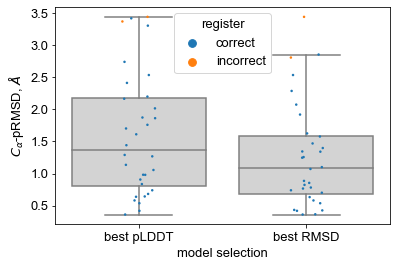

[0.34375 0.125   0.0625  0.     ]
median score: 7.906630016863716


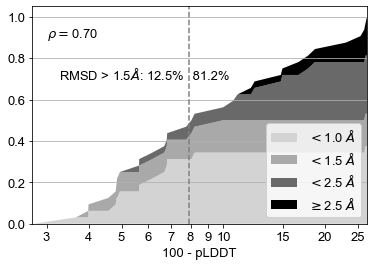

In [58]:
result_df=pd.read_pickle(ctarget_dir+'/result_df.pckl')
print(len(result_df))
print(result_df.columns)

result_df['score']=100-result_df['pep_lddt'].map(result_parse_tools.mean_pep_lddt)
#MAKE compute_scores in result parse tools; add smth like 10*(reg not assigned)!!

cl='I'
df0=result_df[result_df['class']==cl].copy()
df_lddt=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'score',how='min')
df_lddt=df_lddt.reset_index(drop=True)
df_rmsd=result_parse_tools.reduce_to_best(df0,['pmhc_id'],'pep_CA',how='min')
df_rmsd=df_rmsd.reset_index(drop=True)    

fname=fig_dir+f'/rmsd_difficult_{cl}.pdf'
summarize_results([df_lddt,df_rmsd],['best pLDDT','best RMSD'],save_to=fname)
fname=fig_dir+f'/lddt_difficult_{cl}.pdf'
make_hill_plot(df_lddt['pep_CA'],df_lddt['score'],[1.,1.5,2.5],save_to=fname)

In [84]:
#save datasets
def _one_mhc_to_str(m):
    return m.info['locus']+'*'+m.info['allele']
def _mhcs_to_str(x):
    species=x['mhc_a'].info['species']
    if species=='9606':
        species='HLA'
    elif species=='10090':
        species='H2'
    a=species+'-'+_one_mhc_to_str(x['mhc_a'])
    if not (x['mhc_b'] is None):
        a+='/'+_one_mhc_to_str(x['mhc_b'])
    return a

x=df_lddt.copy()
x['MHC allele']=x.apply(_mhcs_to_str,axis=1)
x['MHC sequence']=x['mhc_a'].map(lambda s:s.seq())
if cl=='II':
    x['MHC sequence']+='/'+x['mhc_b'].map(lambda s:s.seq())
x['MHC mutations']=x['mhc_a'].map(lambda m:np.sum(m.data['mutations']!=''))
if cl=='II':
    x['MHC mutations']+=x['mhc_b'].map(lambda m:np.sum(m.data['mutations']!=''))            
x=x[['pep','MHC allele','MHC mutations','MHC sequence','class',
    'pmhc_id','pdb_id',
    'tails','netmhc_tails','netmhc_kd']].copy()
x=x.sort_values(['MHC allele','pep']).reset_index()
x=x.iloc[[0,1,2,6,3,4,5,9,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,29,25,26,27,28,30,31]]
print(x)
x.to_csv(f'./data/examples/difficult_I.csv',index=False)

    index           pep      MHC allele  MHC mutations  \
0       9  GSQKLTTGNCNW  9796-18*001:02              0   
1      30  GSQKLTTGNCNW  9796-18*001:02              1   
2       4     ALGIGILTV     HLA-A*02:01              0   
6      16     LAGIGILTV     HLA-A*02:01              0   
3      15     CINMWCWTV     HLA-A*02:01              0   
4      22     CISGVCWTV     HLA-A*02:01              0   
5      31    KLYQNPTTYI     HLA-A*02:01              0   
9       7    RLYQNPTTYI     HLA-A*02:01              0   
7      20     NLVPMGATV     HLA-A*02:01              0   
8      28     NLVPMVAAV     HLA-A*02:01              0   
10     18     SLFNTVATL     HLA-A*02:01              0   
11      2     SLYNTIATL     HLA-A*02:01              0   
12      8   TIAMELIRMIK     HLA-A*11:01              0   
13     23   TMVMELIRMIK     HLA-A*11:01              0   
14     10     SPKLHFYYL     HLA-B*07:02              0   
15     17     SPRWYFYYL     HLA-B*07:02              0   
16     19     

In [61]:
df_lddt.columns

Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'netmhc_kd', 'pdb_id', 'exclude_pdbs',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd', 'score'],
      dtype='object')

In [73]:
#rmsd for low score models
score_max=6.8 #test set median score
print(df_lddt[df_lddt['score']<score_max]['pep_CA'].median()) 

#test set top half median pep_CA: 0.64A

0.8354876368399525


In [74]:
df_pairs=pd.read_pickle('/scratch/vmikhayl/pmhc_modeling/difficult_dataset/pmhcs_df.pckl')
print(len(df_pairs))
print(df_pairs.columns)

#RMSD predicted from peplen
l_to_rmsd={8:0.4596,9:0.7100,10:0.8502,11:1.7461,12:2.1447} #medians!
print(df_pairs['peplen'].map(l_to_rmsd).mean()) 
#cannot explain observed 1.59, even accounting for medians instead of means

16
Index(['cluster_seq', 'CA_counts', 'peplen', 'pmhc_ids', 'class',
       'dist_matrix', 'max_dist', 'pair', 'pep_mismatch', 'true_rmsd'],
      dtype='object')
0.9554687500000001


In [42]:
df_pairs[['pair','true_rmsd']]

,pair,true_rmsd
3,"(3, 715)",1.917815
4,"(642, 779)",1.844065
9,"(10, 364)",1.842922
33,"(32, 568)",1.575358
35,"(33, 379)",3.657498
40,"(38, 496)",2.595527
57,"(55, 331)",2.805086
103,"(104, 773)",1.680499
105,"(597, 804)",2.135030
139,"(146, 836)",1.504914


In [75]:
#look at examples
#success: NLV, QAT/QAS 53:01 (not 57:01!)
#failure: CIN/CIS

#pep_list=['NLVPMGATV','NLVPMVAAV','ALGIGILTV','LAGIGILTV','QATQEVKNW','QASQEVKNW']
pep_list=['NLVPMGATV','NLVPMVAAV','QATQEVKNW','QASQEVKNW','CINMWCWTV','CISGVCWTV']
model_ids_examples=[]
for pep in pep_list:
    y=df_lddt[df_lddt['pep']==pep]
    for z in y.iterrows():
        x=z[1]
        model_ids_examples.append((x['pmhc_id'],x['model_id']))
        pmhc=pmhcs[x['pmhc_id']]
        mhc=pmhc['M']['info']
        print('{:12s} {}-{}*{} {:3d} {:2d} {:4.2f} ({:d},{:d}) ({:d},{:d}) {:4.1f}'.format(
              ''.join(pmhc['P']['data']['seq']),mhc['species'],mhc['locus'],mhc['allele'],
              x['pmhc_id'],x['model_id'],x['pep_CA'],*x['tails'],*x['af_tails'],x['score']))
        print(pmhc['pdbs'][0])

NLVPMGATV    9606-A*02:01 642  9 0.58 (0,0) (0,0)  6.2
('3mrd_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.7, 'includes_tcr': 0})
NLVPMVAAV    9606-A*02:01 779  2 0.64 (0,0) (0,0)  4.8
('3gsw_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.81, 'includes_tcr': 0})
QATQEVKNW    9606-B*57:01 643  2 1.86 (0,0) (0,0)  4.9
('7r7y_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.6, 'includes_tcr': 0})
QATQEVKNW    9606-B*53:01 715  8 0.84 (0,0) (0,0)  6.7
('7r7w_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.17, 'includes_tcr': 0})
QASQEVKNW    9606-B*53:01   3  6 0.36 (0,0) (0,0)  5.6
('7r7v_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.6, 'includes_tcr': 0})
QASQEVKNW    9606-B*57:01 758  1 0.98 (0,0) (0,0)  4.9
('7r7x_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.1, 'includes_tcr': 0})
CINMWCWTV    9606-A*02:01 494  5 1.44 (0,0) (0,0)  4.0
('3mri_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.1, 'includes_tcr': 0})
CISGVCWTV    9606-A*02:01 695  9

In [76]:
#look at templates used
inputs=[]
for x in os.listdir(ctarget_dir+'/inputs'):
    with open(ctarget_dir+f'/inputs/{x}','rb') as f:
        inputs+=pickle.load(f)
print(len(inputs))
for pmhc_id,model_id in model_ids_examples:
    print(pmhc_id,model_id)
    inputs_1=[]
    for x in inputs:
        if x['target_id']==pmhc_id and x['current_id']==model_id:
            inputs_1.append(x)
    assert len(inputs_1)==1
    for x in inputs_1[0]['template_hits']:
        print(x['query'][:15],x['hit_sequence'][:15],x['name'])
    print()

334
642 9
NLVPMGATVGSHSMR LLYGFVNYVGSHSMR 3pwj_0
NLVPMGATVGSHSMR CINMWCWTVGSHSMR 3mri_0
NLVPMGATVGSHSMR LLSXFGTPTGSHSMR 6z9x_0
NLVPMGATVGSHSMR LLLPRLPPLGSHSMR 7mj9_0

779 2
NLVPMVAAVGSHSMR LLFGYPVAVGSHSMR 1qsf_0
NLVPMVAAVGSHSMR LLYGFVNYVGSHSMR 3pwj_0
NLVPMVAAVGSHSMR ALYNTAAALGSHSMR 1t1z_0
NLVPMVAAVGSHSMR ILNAMIAKIGSHSMR 6ptb_0

643 2
QATQEVKNWGSHSMR LSSPVTKSWGSHSMR 5vvp_0
-QATQEVKNWGSHSM SSTRGISQLWGSHSM 5t6w_0
QATQE-VKNWGSHSM TSMSFVPRPWGSHSM 6d29_0
QATQEVKNWGSHSMR HSITYLLPV-SHSMR 3upr_0

715 8
QATQEVKNWGSHSMR EEYLQAFTYGSHSMR 3kpn_0
QATQEVKNWGSHSMR EEFGRAFSFGSHSMR 1n2r_0
QATQEVKNWGSHSMR ELRAREEAYGSHSMR 6vb1_0
QATQEVKNWGSHSMR TVRASGHSYGSHSMR 6vb7_0

3 6
QASQEVKNWGSHSMR TAFTI-PSIGSHSMR 3w39_0
QASQEVKNWGSHSMR LSSPVTKSWGSHSMR 5vud_0
QASQEVKNWGSHSMR EEPTVIKKYGSHSMR 1sys_0
-QASQEVKNWGSHSM TSTLQEQIGWGSHSM 5t6z_0

758 1
QASQEVKNWGSHSMR LSSPVTKSWGSHSMR 5vvp_0
QASQEVKNWGSHSMR LTVQVARVWGSHSMR 5vwd_0
-QASQEVKNWGSHSM TSTTSVASSWGSHSM 5t6x_0
QASQEVKNWGSHSMR LSSPVTKSFGSHSMR 6v2q_0

494 5
CINMW--CWTVGSH

In [77]:
from tfold.utils import pdb_tools

In [127]:
#best lddt or best rmsd model
which='rmsd' #'lddt' #
df_model={'lddt':df_lddt,'rmsd':df_rmsd}[which]
print(df_model.columns)

df_pairs=pd.read_pickle('/scratch/vmikhayl/pmhc_modeling/difficult_dataset/pmhcs_df.pckl')
print(df_pairs['pmhc_ids'])

Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'pep', 'mhc_a', 'mhc_b',
       'tails', 'netmhc_tails', 'netmhc_kd', 'pdb_id', 'exclude_pdbs',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd', 'score'],
      dtype='object')
3                                               [3, 715]
4      [4, 315, 427, 551, 642, 653, 744, 779, 798, 85...
9                                    [10, 364, 454, 519]
33                [32, 99, 144, 231, 374, 498, 568, 684]
35                [33, 97, 111, 296, 379, 411, 808, 854]
40                                             [38, 496]
57                                             [55, 331]
103                       [104, 150, 160, 651, 773, 872]
105        [113, 198, 251, 335, 516, 597, 741, 804, 895]
139                                           [146, 836]
152                                           [1

In [128]:
#compute rmsds to opposite
def _compute_cross_rmsd(pmhc_id_model,pmhc_id_cross):
    pmhc_model=pmhcs[pmhc_id_model]
    pmhc_cross=pmhcs[pmhc_id_cross]
    
    model_id=df_model[df_model['pmhc_id']==pmhc_id_model].iloc[0]['model_id']
    pdb_model=ctarget_dir+f'/outputs/{pmhc_id_model}/structure_model_1_{model_id}.pdb'        
    pdb_id_cross=pmhc_cross['pdbs'][0][0]    
        
    structure1,_=pdb_tools.parse_pdb(pdb_model)
    structure2,_=pdb_tools.parse_pdb(source_dir+f'/pdb/{pdb_id_cross}.pdb','pdb2')    
    
    structure1_dict=pdb_tools.get_structure_dict(structure1,False)
    pdbnum1=['P'+x for x in structure1_dict['P'].keys()]              
    pdbnum2=['P'+p for p in pmhc_cross['P']['data']['pdbnum']]
    assert len(pdbnum1)==len(pdbnum2)    
    chainmap=[['M','M']]
    pdb_tools.superimpose_by_chainmap(structure1,structure2,chainmap,CA_only=True,verbose=False)    
    resmap=list(zip(pdbnum1,pdbnum2))
    pep_rmsd=pdb_tools.rmsd_by_resmap(structure1,structure2,resmap,allow_missing_res=True,verbose=False)    
    return (pmhc_id_model,pep_rmsd['CA'])

r1=df_pairs['pair'].map(lambda x:_compute_cross_rmsd(x[0],x[1])) #for 1st model in pair
r2=df_pairs['pair'].map(lambda x:_compute_cross_rmsd(x[1],x[0])) #for 2nd model in pair
cross_rmsd=pd.DataFrame([list(x) for x in pd.concat([r1,r2]).values],columns=['pmhc_id','cross_rmsd'])

#compute rmsd between models
def _compute_rmsd_models(pmhc_id1,pmhc_id2):    
    model_id1=df_model[df_model['pmhc_id']==pmhc_id1].iloc[0]['model_id']
    pdb_model1=ctarget_dir+f'/outputs/{pmhc_id1}/structure_model_1_{model_id1}.pdb' 
    model_id2=df_model[df_model['pmhc_id']==pmhc_id2].iloc[0]['model_id']
    pdb_model2=ctarget_dir+f'/outputs/{pmhc_id2}/structure_model_1_{model_id2}.pdb'    
        
    structure1,_=pdb_tools.parse_pdb(pdb_model1)
    structure2,_=pdb_tools.parse_pdb(pdb_model2) 
    
    structure1_dict=pdb_tools.get_structure_dict(structure1,False)
    structure2_dict=pdb_tools.get_structure_dict(structure2,False)
    pdbnum1=['P'+x for x in structure1_dict['P'].keys()] 
    pdbnum2=['P'+x for x in structure2_dict['P'].keys()] 
    assert len(pdbnum1)==len(pdbnum2)  #ONLY WORKS FOR PEPS OF EQUAL LENGTH!
    chainmap=[['M','M']]
    pdb_tools.superimpose_by_chainmap(structure1,structure2,chainmap,CA_only=True,verbose=False)    
    resmap=list(zip(pdbnum1,pdbnum2))  #SUPERIMPOSES PEPTIDES BY RES INDEX, not by alignment!
    pep_rmsd=pdb_tools.rmsd_by_resmap(structure1,structure2,resmap,allow_missing_res=True,verbose=False)    
    return pep_rmsd['CA']

df_pairs['intermodel_rmsds']=df_pairs['pair'].map(lambda x:_compute_rmsd_models(*x))

In [129]:
def _add_model_data(x,k):
    return tuple([df_model[df_model['pmhc_id']==a].iloc[0][k] for a in x])

df_pairs['model_rmsds']=df_pairs['pair'].map(lambda x:_add_model_data(x,'pep_CA'))
df_pairs['model_lddts']=df_pairs['pair'].map(lambda x:_add_model_data(x,'score'))

df_pairs['av_score']=df_pairs['model_lddts'].map(np.mean) #average over pair

if which=='lddt':
    df_pairs_order=df_pairs['av_score'].argsort().values
df_pairs=df_pairs.iloc[df_pairs_order]

#df_pairs=df_pairs.sort_values('av_score')
#df_pairs=df_pairs.sort_values('true_rmsd')

#sort by max dist
#plot triples of rmsds, ticks: pep,mhc; color: predicted accuracy

3 38


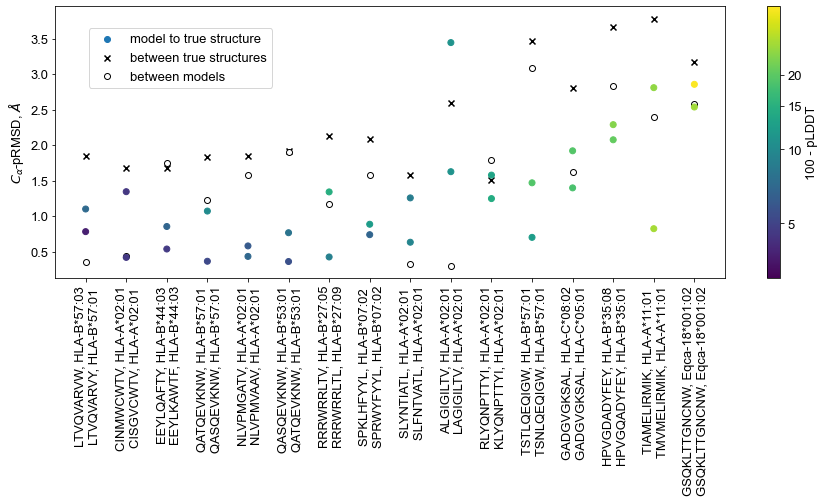

In [131]:
spd={'9606':'HLA','9796':'Eqca'}
def _make_names(x):
    s=''
    for a in x:
        pepseq=''.join(pmhcs[a]['P']['data']['seq'])
        mhc=pmhcs[a]['M']['info']        
        mhc=spd[mhc['species']]+'-'+mhc['locus']+'*'+mhc['allele']
        s+=(pepseq+', '+mhc+'\n')
    return s
names=df_pairs['pair'].map(_make_names).values
exp_rmsds=df_pairs['true_rmsd'].values
intermodel_rmsds=df_pairs['intermodel_rmsds'].values
model_rmsds=[np.stack(df_pairs['model_rmsds'].values)[:,i] for i in range(2)]
model_lddts=[np.stack(df_pairs['model_lddts'].values)[:,i] for i in range(2)]

fig=plt.figure(figsize=(15,5))
plt.scatter(range(len(names)),exp_rmsds,marker='x',color='k')
plt.scatter(range(len(names)),intermodel_rmsds,marker='o',facecolors=(1,1,1,1),edgecolors='k')

def _forward(x):
    return np.log(x)
def _inverse(x):
    return np.exp(x)

x=np.array(model_lddts)
vmin,vmax=math.floor(np.min(x)),math.ceil(np.max(x))
print(vmin,vmax)

norm=matplotlib.colors.FuncNorm((_forward, _inverse),vmin=vmin,vmax=vmax) #log scale for colormap

plt.scatter(range(len(names)),model_rmsds[0],c=model_lddts[0],norm=norm)
plt.scatter(range(len(names)),model_rmsds[1],c=model_lddts[1],norm=norm)
plt.xticks(np.arange(len(names)),names,rotation=90)
#fix text labels relative to ticks position in xticks
ax=plt.gca()
offset = matplotlib.transforms.ScaledTranslation(0.12, 0., fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform()+offset)

plt.ylabel(r'$C_\alpha$-pRMSD, $\AA$')
plt.colorbar(label='100 - pLDDT',ticks=[2,5,10,15,20])
#legend
artists=[]
artists.append(plt.scatter([],[],marker='o'))
artists.append(plt.scatter([],[],marker='x',color='k'))
artists.append(plt.scatter([],[],marker='o',facecolors='w',edgecolors='k'))
plt.legend(artists,['model to true structure','between true structures','between models'],loc=(0.05,0.7))
save_to=fig_dir+f'/rmsd_difficult_I_triples_{which}.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()                        

#ax.set(ylabel=r'pep backbone RMSD, $\AA$')

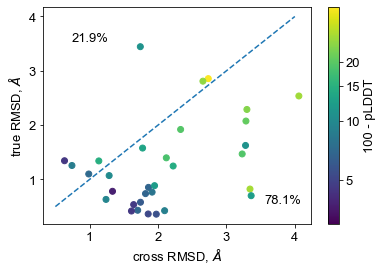

total structures: 32
bad: 7
good: 25
total higher score structures: 7
bad: 1
good: 6


In [132]:
#plot proper vs cross rmsds
#cross_rmsd
proper_rmsd=np.array([df_model[df_model['pmhc_id']==x].iloc[0]['pep_CA'] for x in cross_rmsd['pmhc_id']])
lddt_list=[df_model[df_model['pmhc_id']==x].iloc[0]['score'] for x in cross_rmsd['pmhc_id']]
plt.figure()
plt.scatter(cross_rmsd['cross_rmsd'].values,proper_rmsd,c=lddt_list,norm=norm)
plt.plot([0.5,4.],[0.5,4.],linestyle='--')
plt.xlabel(r'cross RMSD, $\AA$')
plt.ylabel(r'true RMSD, $\AA$')
plt.colorbar(label='100 - pLDDT',ticks=[2,5,10,15,20])
#print percentages
n_bad=np.sum(cross_rmsd['cross_rmsd'].values<proper_rmsd)
n=len(proper_rmsd)
p_bad=n_bad/n*100
p_good=100-p_bad
plt.text(np.min(cross_rmsd['cross_rmsd'].values)+0.1,np.max(proper_rmsd)+0.1,'{:4.1f}%'.format(p_bad))
plt.text(np.max(cross_rmsd['cross_rmsd'].values)-0.5,np.min(proper_rmsd)+0.2,'{:4.1f}%'.format(p_good))
save_to=fig_dir+f'/rmsd_difficult_I_scatter_{which}.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#fraction for all
x=[True]*len(np.array(lddt_list))
print('total structures:',np.sum(x))
print('bad:',np.sum(cross_rmsd['cross_rmsd'][x]<proper_rmsd[x]))
print('good:',np.sum(cross_rmsd['cross_rmsd'][x]>proper_rmsd[x]))

#fraction for higher predicted accuracy
threshold=6.8 #median score on the cl I test set
x=np.array(lddt_list)<threshold
print('total higher score structures:',np.sum(x))
print('bad:',np.sum(cross_rmsd['cross_rmsd'][x]<proper_rmsd[x]))
print('good:',np.sum(cross_rmsd['cross_rmsd'][x]>proper_rmsd[x]))

In [16]:
print('good among all: ',19/32)
print('good among high predicted accuracy',10/13)

good among all:  0.59375
good among high predicted accuracy 0.7692307692307693


In [34]:
#look at contacts
dir1='./data/experimental_structures/processed_updated/contact_maps'

def print_pep_counts(pdb_id):
    with open(dir1+f'/{pdb_id}.pckl','rb') as f:
        cmap=pickle.load(f)
    cmap=cmap[('M','P')]
    #reduce
    pep_counts={}
    for k,v in cmap.items():
        if v!=0:
            pep_counts.setdefault(k[1],{})
            pep_counts[k[1]][k[0]]=v
    p_res=np.sort(list(pep_counts.keys()))
    for p in p_res:
        print(p,pep_counts[p])
        
pdb_id='3mrd_0'
print_pep_counts(pdb_id)
print()
pdb_id='3gsw_0'
print_pep_counts(pdb_id)
#res 5 M70, M1007 -> res 6 M70

P   1  {'M   5 ': 1, 'M   7 ': 3, 'M  63 ': 3, 'M  66 ': 2, 'M1070 ': 3, 'M1077 ': 2, 'M1081 ': 2}
P   2  {'M   7 ': 3, 'M   9 ': 1, 'M  45 ': 1, 'M  63 ': 2, 'M  66 ': 6, 'M  67 ': 2, 'M1009 ': 1, 'M1070 ': 1}
P   3  {'M  70 ': 3, 'M1009 ': 5, 'M1070 ': 12}
P   5  {'M  70 ': 4, 'M1007 ': 6, 'M1009 ': 2, 'M1024 ': 1}
P   7  {'M  73 ': 1, 'M1063 ': 1}
P   8  {'M  76 ': 1, 'M  77 ': 5, 'M1058 ': 2, 'M1059 ': 1}
P   9  {'M  77 ': 7, 'M  81 ': 1, 'M  84 ': 1, 'M1026 ': 2, 'M1055 ': 4, 'M1058 ': 1}

P   1  {'M   7 ': 1, 'M  63 ': 1, 'M  66 ': 2, 'M1070 ': 3, 'M1077 ': 7, 'M1081 ': 4}
P   2  {'M   7 ': 2, 'M   9 ': 1, 'M  45 ': 1, 'M  63 ': 5, 'M  66 ': 4, 'M  67 ': 3, 'M1009 ': 2}
P   3  {'M  66 ': 1, 'M  70 ': 3, 'M1009 ': 5, 'M1070 ': 4}
P   4  {'M  66 ': 1}
P   6  {'M  70 ': 5}
P   7  {'M1007 ': 2, 'M1059 ': 3, 'M1063 ': 2}
P   8  {'M  73 ': 1, 'M  77 ': 3, 'M1058 ': 4, 'M1059 ': 2}
P   9  {'M  77 ': 5, 'M  81 ': 1, 'M  84 ': 1, 'M1026 ': 1, 'M1055 ': 4}


In [30]:
cmap[('M','P')]

{('M   1 ', 'P   1 '): 0,
 ('M   1 ', 'P   2 '): 0,
 ('M   1 ', 'P   3 '): 0,
 ('M   1 ', 'P   4 '): 0,
 ('M   1 ', 'P   5 '): 0,
 ('M   1 ', 'P   6 '): 0,
 ('M   1 ', 'P   7 '): 0,
 ('M   1 ', 'P   8 '): 0,
 ('M   1 ', 'P   9 '): 0,
 ('M   2 ', 'P   1 '): 0,
 ('M   2 ', 'P   2 '): 0,
 ('M   2 ', 'P   3 '): 0,
 ('M   2 ', 'P   4 '): 0,
 ('M   2 ', 'P   5 '): 0,
 ('M   2 ', 'P   6 '): 0,
 ('M   2 ', 'P   7 '): 0,
 ('M   2 ', 'P   8 '): 0,
 ('M   2 ', 'P   9 '): 0,
 ('M   3 ', 'P   1 '): 0,
 ('M   3 ', 'P   2 '): 0,
 ('M   3 ', 'P   3 '): 0,
 ('M   3 ', 'P   4 '): 0,
 ('M   3 ', 'P   5 '): 0,
 ('M   3 ', 'P   6 '): 0,
 ('M   3 ', 'P   7 '): 0,
 ('M   3 ', 'P   8 '): 0,
 ('M   3 ', 'P   9 '): 0,
 ('M   4 ', 'P   1 '): 0,
 ('M   4 ', 'P   2 '): 0,
 ('M   4 ', 'P   3 '): 0,
 ('M   4 ', 'P   4 '): 0,
 ('M   4 ', 'P   5 '): 0,
 ('M   4 ', 'P   6 '): 0,
 ('M   4 ', 'P   7 '): 0,
 ('M   4 ', 'P   8 '): 0,
 ('M   4 ', 'P   9 '): 0,
 ('M   5 ', 'P   1 '): 1,
 ('M   5 ', 'P   2 '): 0,
 ('M   5 ', 

In [27]:
os.listdir(dir1+'/contact_maps')

['1bec_0.pckl',
 '3vxt_0.pckl',
 '5j6g_1.pckl',
 '3gsq_0.pckl',
 '5wmp_0.pckl',
 '1t1z_0.pckl',
 '4pg9_0.pckl',
 '2gtz_0.pckl',
 '3o3a_1.pckl',
 '7r7y_0.pckl',
 '3vh8_1.pckl',
 '6uzo_0.pckl',
 '3p4m_1.pckl',
 '3jtt_2.pckl',
 '6lhh_0.pckl',
 '1k8d_0.pckl',
 '5wjn_1.pckl',
 '4l3c_6.pckl',
 '1ydp_0.pckl',
 '3upr_0.pckl',
 '5eu5_0.pckl',
 '5vwd_0.pckl',
 '4l29_8.pckl',
 '1k5n_0.pckl',
 '6xqa_0.pckl',
 '6j2a_0.pckl',
 '3sko_0.pckl',
 '1ld9_1.pckl',
 '3roo_0.pckl',
 '6d2b_0.pckl',
 '5t6w_0.pckl',
 '1fzm_0.pckl',
 '3rl1_0.pckl',
 '3kyo_0.pckl',
 '1kbg_0.pckl',
 '5kd7_2.pckl',
 '3vxp_1.pckl',
 '1s8d_0.pckl',
 '5mep_0.pckl',
 '6w51_0.pckl',
 '4hkj_0.pckl',
 '6uj9_0.pckl',
 '1kpr_0.pckl',
 '1zhk_0.pckl',
 '3vfm_0.pckl',
 '3am8_1.pckl',
 '1mhe_1.pckl',
 '7emc_1.pckl',
 '3kpm_0.pckl',
 '3bo8_0.pckl',
 '3kpn_0.pckl',
 '6y27_0.pckl',
 '5d9s_0.pckl',
 '1uxw_0.pckl',
 '5jwe_1.pckl',
 '6ggm_0.pckl',
 '6l9k_0.pckl',
 '4nny_0.pckl',
 '3qul_1.pckl',
 '6o4y_0.pckl',
 '6uzq_0.pckl',
 '1bz9_0.pckl',
 '7duu_0

## TFold class I discovery: explore features

In [133]:
df=tfold_discovery_dfs['I'].copy()
print(len(df))
print(df.columns)

270
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'linker', 'score'],
      dtype='object')


peptide length
8      32
9     164
10     48
11     16
12      5
13      3
14      1
15      1
Name: pep, dtype: int64
MHC
HLA-A            80
HLA-B            79
HLA-C             7
HLA-E,G           4
mouse            61
other species    39
Name: mhc_a, dtype: int64
0        196
1-10      36
11-20     21
>20       17
Name: template MHC mismatch, dtype: int64
median pep_CA for different peptide lengths:
 9 0.7100393983610616
10 0.8502323992012308
11 1.7461348178942289
 8 0.4596276439129563
>11 2.144706979265438
MHC HLA-A, HLA-B: 80 79
p-value: 0.03061631254225574
template MHC mismatch 0 vs 1-10: 196 36
p-value: 0.20979170825129476


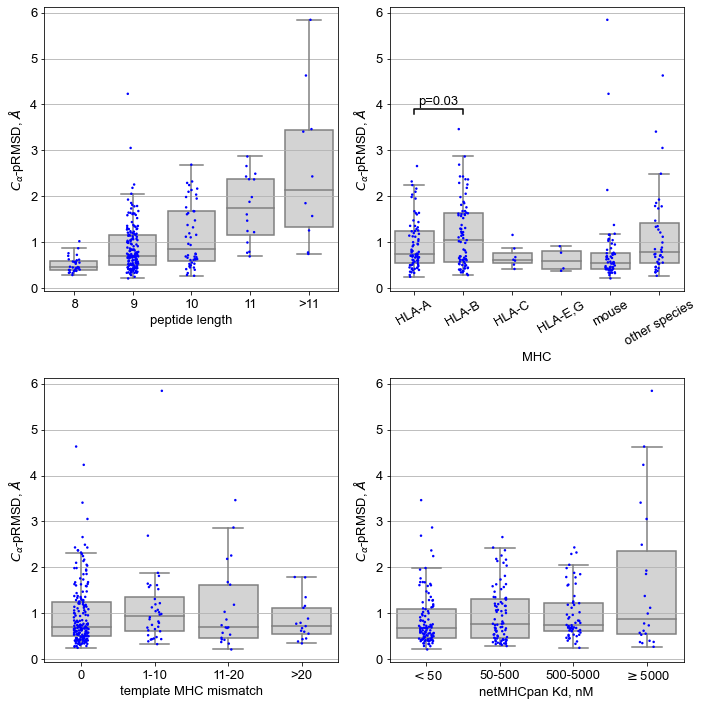

In [134]:
from scipy.stats import ttest_ind

#len bins
print('peptide length')
print(df['pep'].map(len).value_counts().sort_index())
def len_feature(x):
    if x<12:
        return '{:2d}'.format(x)
    else:
        return '>11'
df['peptide length']=df['pep'].map(len).map(len_feature)
    
#mhc A/B/C/mouse/other
def reduce_mhc(x):
    x=x.info
    return x['species'],x['locus'],x['allele']
def mhc_features(x):
    if x[0]=='9606':
        if x[1] in ['A','B','C']:
            return 'HLA-'+x[1]
        else:
            return 'HLA-E,G'
    elif x[0]=='10090':
        return 'mouse'
    else:
        return 'other species'
print('MHC')
print(df['mhc_a'].map(reduce_mhc).map(mhc_features).value_counts().sort_index())
df['MHC']=df['mhc_a'].map(reduce_mhc).map(mhc_features)
    
#template score
#print('best score')
#print(df['best_score'].value_counts().sort_index())
#print('best MHC score')
#print(df['best_mhc_score'].value_counts().sort_index())
def mhc_score_feature(x):
    if x==0:
        return '0'
    elif 1<=x<=10:
        return '1-10'
    elif 11<=x<=20:
        return '11-20'
    else:
        return '>20'
df['template MHC mismatch']=df['best_mhc_score'].map(mhc_score_feature)
print(df['template MHC mismatch'].value_counts().sort_index())

#netmhc kd
def netmhc_kd_feature(x):
    if x<50:
        return r'$<$50'
    elif 50<=x<500:
        return '50-500'
    elif 500<=x<5000:
        return '500-5000'
    else:
        return r'$\geq$5000'
df['netMHCpan Kd, nM']=df['netmhc_kd'].map(netmhc_kd_feature)

#plot
def plot_pvalue(i,j,shift_x,shift_p,shift_y,y,p):
    s='p={:4.2f}'.format(p)
    plt.plot(shift_x+np.array([i,i,j,j]),y+shift_y*np.array([-1.,0.,0.,-1.]),color='black')
    plt.text(shift_x+(i+j)/2-shift_p*len(s),y+shift_y,s)

#sns.set(rc={'figure.figsize':(10,10)})
#sns.set_theme(style='white')

plt.plot(figsize=(10,10))

#peplen
X=plt.subplot(2,2,1)
X.figure.set_size_inches(10,10)
k='peptide length'
sns.boxplot(data=df,y='pep_CA',x=k,color='lightgray',fliersize=0,order=np.sort(df[k].unique()))
ax=sns.stripplot(data=df,y='pep_CA',x=k,color='blue',marker='.',order=np.sort(df[k].unique()))
ax.set(ylabel=r'$C_\alpha$-pRMSD, $\AA$')
plt.grid(axis='y')
print('median pep_CA for different peptide lengths:')
for x in df[k].unique():
    print(x,df[df[k]==x]['pep_CA'].median())

#MHC
a=df[df['MHC']=='HLA-A']['pep_CA']
b=df[df['MHC']=='HLA-B']['pep_CA']
print('MHC HLA-A, HLA-B:',len(a),len(b))
p=ttest_ind(a,b).pvalue
print('p-value:',p)
plt.subplot(2,2,2)
k='MHC'
sns.boxplot(data=df,y='pep_CA',x=k,color='lightgray',fliersize=0,order=np.sort(df[k].unique()))
ax=sns.stripplot(data=df,y='pep_CA',x=k,color='blue',marker='.',order=np.sort(df[k].unique()))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(ylabel=r'$C_\alpha$-pRMSD, $\AA$')
plot_pvalue(0,1,0.,0.07,0.1,3.9,p)
plt.grid(axis='y')

#MHC mismatch
a=df[df['template MHC mismatch']=='0']['pep_CA']
b=df[df['template MHC mismatch']=='1-10']['pep_CA']
print('template MHC mismatch 0 vs 1-10:',len(a),len(b))
p=ttest_ind(a,b).pvalue
print('p-value:',p)
plt.subplot(2,2,3)
k='template MHC mismatch'
sns.boxplot(data=df,y='pep_CA',x=k,color='lightgray',fliersize=0,order=np.sort(df[k].unique()))
ax=sns.stripplot(data=df,y='pep_CA',x=k,color='blue',marker='.',order=np.sort(df[k].unique()))
ax.set(ylabel=r'$C_\alpha$-pRMSD, $\AA$')
#plot_pvalue(0,1,0.,0.07,0.1,3.5,p)
plt.grid(axis='y')

#Kd
plt.subplot(2,2,4)
k='netMHCpan Kd, nM'
order=[r'$<$50','50-500','500-5000',r'$\geq$5000']
sns.boxplot(data=df,y='pep_CA',x=k,color='lightgray',fliersize=0,order=order)
ax=sns.stripplot(data=df,y='pep_CA',x=k,color='blue',marker='.',order=order)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(ylabel=r'$C_\alpha$-pRMSD, $\AA$')
plt.grid(axis='y')

plt.tight_layout()
save_to=fig_dir+'/rmsd_features_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#{8:0.4596,9:0.7100,10:0.8502,11:1.7461,12:2.1447}

200301
Index(['pep', 'mhc_a', 'kd'], dtype='object')
102 pmhcs of 270 have experimental Kd
of these, without mhc mutations: 86
above 1000: 8
above 2500: 4
above 5000: 2
corrcoef logkd-pepCA: 0.20420746401435058


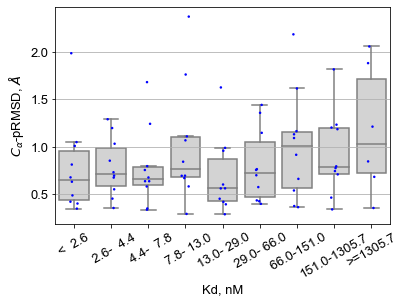

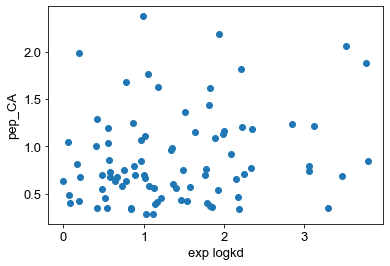

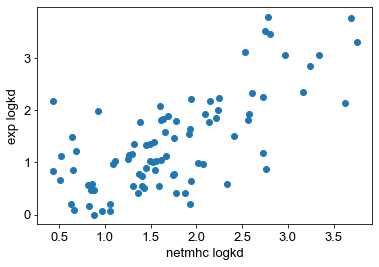

In [185]:
#add experimental Kd

#read exp Kd data
df_kd=pd.read_pickle('./data/pmhc_assays/train_i.pckl')
df_kd=pd.concat([df_kd,pd.read_pickle('./data/pmhc_assays/test_i.pckl')[['pep','mhc_a','kd']]])
print(len(df_kd))
print(df_kd.columns)
df_kd['pmhc_str']=df_kd.apply(lambda x:'|'.join([x['pep']]+list(x['mhc_a'])),axis=1)

#add exp Kd data to df, restrict to data with kd
def _add_kd(x):
    y=df_kd[df_kd['pmhc_str']==x]
    if len(y)==0:
        return -1.
    else:
        return y['kd'].iloc[0]
df['pmhc_str']=df.apply(lambda x:'|'.join([x['pep'],x['mhc_a'].info['species'],x['mhc_a'].info['locus'],x['mhc_a'].info['allele']]),axis=1)
df['kd_exp']=df['pmhc_str'].map(_add_kd)
df_good=df[df['kd_exp']>=0.].copy()
print('{} pmhcs of {} have experimental Kd'.format(len(df_good),len(df)))

#restrict to ones with no mhc mutations, since can't trust kd otherwise
def _check_mhc_mut(x):
    return len(np.unique(x.data['mutations']))==1
df_good=df_good[df_good['mhc_a'].map(_check_mhc_mut)]
print('of these, without mhc mutations:',len(df_good))

#plot
#def kd_feature(x):
#    if x<50:
#        return r'$<$50'
#    elif 50<=x<100:
#        return '50-100'
#    elif 100<=x<250:
#        return '100-250'
#    elif 250<=x<1000:
#        return '250-1000'
#    elif 1000<=x<2500:
#        return '1000-2500'
#    else:
#        return r'$\geq$2500'
#df_good['Kd, nM']=df_good['kd_exp'].map(kd_feature)
#order=[r'$<$50','50-100','100-250','250-1000','1000-2500',r'$\geq$2500']

df_good=df_good.sort_values('kd_exp')
bins=df_good['kd_exp'][::10].values[1:]
def kd_feature(x):
    i=np.sum(bins<=x)
    if i==0:
        return '<{:5.1f}'.format(bins[0])
    elif i==len(bins):
        return '>={:5.1f}'.format(bins[-1])
    else:
        return '{:5.1f}-{:5.1f}'.format(bins[i-1],bins[i])
df_good['Kd, nM']=df_good['kd_exp'].map(kd_feature)
order=[kd_feature(x) for x in [bins[0]-0.01]+list(bins+0.01)]

for t in [1000,2500,5000]:
    print(f'above {t}:',np.sum(df_good['kd_exp']>t))
    
c=np.corrcoef(np.log10(df_good['kd_exp'].values),df_good['pep_CA'])[0,1]
print('corrcoef logkd-pepCA:',c)

plt.figure()
k='Kd, nM'
sns.boxplot(data=df_good,y='pep_CA',x=k,color='lightgray',fliersize=0,order=order)
ax=sns.stripplot(data=df_good,y='pep_CA',x=k,color='blue',marker='.',order=order)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(ylabel=r'$C_\alpha$-pRMSD, $\AA$')
plt.grid(axis='y')
plt.show()

#scatter logkd vs pep_CA
plt.figure()
plt.scatter(np.log10(df_good['kd_exp'].values),df_good['pep_CA'])
plt.xlabel('exp logkd')
plt.ylabel('pep_CA')
plt.show()

#compare netmhc kd to measured
plt.figure()
plt.scatter(np.log10(df_good['netmhc_kd'].values),np.log10(df_good['kd_exp'].values))
plt.xlabel('netmhc logkd')
plt.ylabel('exp logkd')
plt.show()

#too few datapoints (86 of 270, of these only 2 above 5000): 
#not informative; and the worst Kds are likely in ones where not measured
#netmhc correlation pretty good: but this is mostly training set!

In [182]:
df_good=df_good.sort_values('kd_exp')
x=df_good['kd_exp'][::10]
#l=len(df_good)
#kd_bins=[]
#for i in range(l//10+(l%10!=0)):
#    x=df_good.iloc[10*i:10*(i+1)]
#    x[0],x[-1]
x   


180       1.000000
214       2.628693
137       4.357930
108       7.750506
249      12.999975
126      29.000090
236      66.000095
192     151.000000
164    1305.661572
Name: kd_exp, dtype: float64

In [181]:
l=11
l//10+(l%10!=0)

2

In [22]:
#groups within HLA-B?
print(df.columns)

df_b=df[df['MHC']=='HLA-B']
df_b_good=df_b[df_b['pep_CA']<0.9]
df_b_bad=df_b[df_b['pep_CA']>=0.9]
print('HLA-B good: {}, bad: {}'.format(len(df_b_good),len(df_b_bad)))
mhcs_good=df_b_good['mhc_a'].map(lambda x:x.info['allele'])
mhcs_bad=df_b_bad['mhc_a'].map(lambda x:x.info['allele'])
print('GOOD')
utils.print_hist(mhcs_good)
print()
print('BAD')
utils.print_hist(mhcs_bad)

#conclusion: no obvious pattern

Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'linker', 'score', 'peptide length', 'MHC', 'template MHC mismatch',
       'netMHCpan Kd, nM'],
      dtype='object')
HLA-B good: 36, bad: 43
GOOD
07:02 2
08:01 7
14:02 2
18:01 1
27:05 4
27:09 2
35:01 3
35:08 1
42:02 1
44:03 1
57:01 8
58:01 2
81:01 2

BAD
07:02 6
15:01 4
27:05 2
27:09 1
35:01 6
35:08 3
41:04 1
42:01 1
44:02 1
44:03 3
46:01 1
51:01 1
52:01 1
53:01 2
57:01 5
57:03 2
58:01 2
81:01 1


Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'linker', 'score', 'mhc_name', 'peptide length', 'MHC',
       'template MHC mismatch', 'netMHCpan Kd, nM',
       'best_mhc_score_transformed'],
      dtype='object')


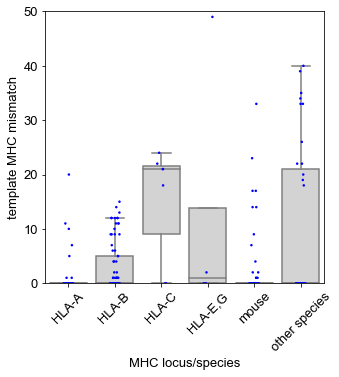

HLA-A 0.6875
HLA-B 2.949367088607595
HLA-C 15.142857142857142
HLA-E,G 12.75
mouse 2.377049180327869
other species 11.256410256410257


In [35]:
#mhc mismatch by MHC locus/species

print(df.columns)
order=np.sort(df['MHC'].unique())

#df['best_mhc_score_transformed']=df['best_mhc_score']+1

plt.figure(figsize=(5,5))
sns.boxplot(data=df,y='best_mhc_score',x='MHC',color='lightgray',fliersize=0,order=order)
ax=sns.stripplot(data=df,y='best_mhc_score',x='MHC',color='blue',marker='.',order=order)
#ax.set_yscale('log')
plt.xlabel('MHC locus/species')
plt.ylabel('template MHC mismatch')
plt.xticks(np.arange(len(order)),order,rotation=45)
plt.ylim(0,50) #cuts some extremes for 'other species'
save_to=fig_dir+'/mhc_mismatch_vs_locus_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()
#note that the plot is truncated in y!!!

#print means
for k in order:
    print(k,df[df['MHC']==k]['best_mhc_score'].mean())

In [34]:
#count alleles by locus
#from tfold.utils import mhc_tools
import tfold.utils.seq_tools as seq_tools
seq_tools.load_mhcs()
loci=[]
for k in seq_tools.mhcs:
    if k[0]=='9606':
        loci.append(k[1])
utils.print_hist(loci)

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  2.5 s
A    4141
B    5081
C    3910
DPA1  132
DPB1 1173
DQA1  171
DQB1 1319
DRA     2
DRB1 2054
DRB3  300
DRB4  131
DRB5  124
E     109
F       6
G      26


## TFold class II: DQ features

Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'linker', 'score'],
      dtype='object')
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd', 'linker', 'score'],
      dtype='object')
15 58


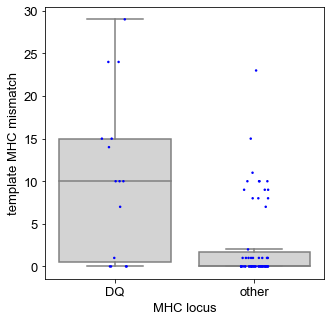

In [49]:
df1=tfold_discovery_dfs['II']
df2=tfold_test_dfs['II']
print(df1.columns)
print(df2.columns)
k=['pmhc_id','best_mhc_score','af_tails','tails','pep_CA','pep','mhc_a','mhc_b','score']
df=pd.concat([df1[k],df2[k]])

def map_mhc(x):
    if type(x)==tuple:
        x=x[1]
    else:
        x=x.info['locus']
    return x[:2]
df['MHC']=df['mhc_b'].map(map_mhc)
df_q=df[df['MHC']=='DQ'].copy()
df_other=df[df['MHC']!='DQ'].copy()
print(len(df_q),len(df_other))
df_q['MHC locus']='DQ'
df_other['MHC locus']='other'
df_merged=pd.concat([df_q[['MHC locus','best_mhc_score']],df_other[['MHC locus','best_mhc_score']]])
df_merged=df_merged.rename({'best_mhc_score':'template MHC mismatch'},axis=1)

plt.figure(figsize=(5,5))
sns.boxplot(data=df_merged,y='template MHC mismatch',x='MHC locus',color='lightgray',fliersize=0)#,order=order)
ax=sns.stripplot(data=df_merged,y='template MHC mismatch',x='MHC locus',color='blue',marker='.')#,order=order)
save_to=fig_dir+'/rmsd_DQ_features_II.pdf'
#plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [50]:
df_p=df[df['MHC']=='DP'].copy()
print(df_p['best_mhc_score'])
#kinda not as bad as DQ?

37    11
44     0
49     1
51     0
Name: best_mhc_score, dtype: int64


## compare to Pandora

In [186]:
#read pandora results

pandora_results={}
for d in os.listdir('/scratch/vmikhayl/pmhc_modeling/pandora1/outputs'):
    if 'result.pckl' in os.listdir('/scratch/vmikhayl/pmhc_modeling/pandora1/outputs/'+d):
        with open('/scratch/vmikhayl/pmhc_modeling/pandora1/outputs/'+d+'/result.pckl','rb') as f:
            r=pickle.load(f)
            r.update({'pmhc_id':int(d)})
        for k,v in r.items():
            pandora_results.setdefault(k,[]).append(v)        
    else:
        print(d)
pandora_results=pd.DataFrame(pandora_results)
#pandora_results=pd.merge(df_target,pandora_results,left_on='pmhc_id',right_on='pmhc_id')
print(len(pandora_results))
print(pandora_results.columns)

#TFold test reduced to pmhcs in pandora
x=tfold_test_dfs['I'].copy()
test_pandora=x[x['pmhc_id'].isin(pandora_results['pmhc_id'])]
print(len(test_pandora))

test_pandora=test_pandora.rename({'pep_CA':'TFold'},axis=1)
test_pandora=test_pandora.merge(pandora_results[['pmhc_id','pep_CA']],left_on='pmhc_id',right_on='pmhc_id')
test_pandora=test_pandora.rename({'pep_CA':'PANDORA'},axis=1)

81
Index(['netmhc_anchors', 'pandora_template', 'molpdf', 'DOPE', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'pmhc_id'],
      dtype='object')
81


outperforms on 64 of 81 (0.7901234567901234)


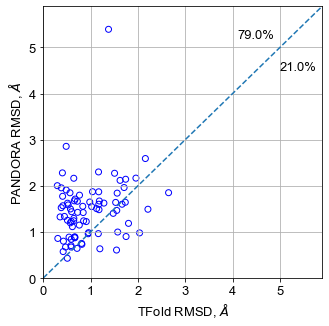

WilcoxonResult(statistic=489.0, pvalue=3.4729309448241705e-08)


In [187]:
plt.figure(figsize=(5,5))
vmax=0.5+max(test_pandora['TFold'].max(),test_pandora['PANDORA'].max())
plt.scatter(test_pandora['TFold'],test_pandora['PANDORA'],facecolors='none',edgecolors='blue')
plt.xlim(0,vmax)
plt.ylim(0,vmax)
plt.plot([0,vmax],[0,vmax],'--')
plt.xlabel(r'TFold RMSD, $\AA$')
plt.ylabel(r'PANDORA RMSD, $\AA$')
plt.grid()

n_tfold_better=np.sum(test_pandora['TFold']<test_pandora['PANDORA'])
print('outperforms on {} of {} ({})'.format(n_tfold_better,len(test_pandora),n_tfold_better/len(test_pandora)))
plt.text(4.1,5.2,'{:4.1f}%'.format(100*n_tfold_better/len(test_pandora)))
plt.text(5.,4.5,'{:4.1f}%'.format(100-100*n_tfold_better/len(test_pandora)))
save_to=fig_dir+'/rmsd_PANDORA_scatter.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#Wilcoxon signed-rank test
from scipy.stats import wilcoxon
p=wilcoxon(test_pandora['TFold'],test_pandora['PANDORA'])
print(p)

TFold median pep_CA: 0.7667134002940474
PANDORA median pep_CA: 1.4821416818742146


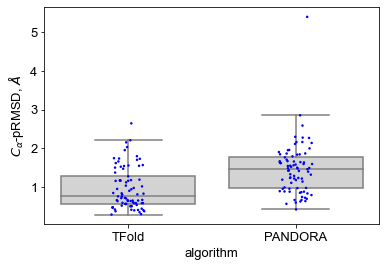

In [188]:
df1=pd.DataFrame()
df1['pep_CA']=test_pandora['TFold']
df1['algorithm']='TFold'
print('TFold median pep_CA:',df1['pep_CA'].median())
df2=pd.DataFrame()
df2['pep_CA']=test_pandora['PANDORA']
df2['algorithm']='PANDORA'
print('PANDORA median pep_CA:',df2['pep_CA'].median())
df=pd.concat([df1,df2])

#sns.set(rc={'figure.figsize':(5,5),'lines.color':'k'})
#sns.set_theme(style='white')
plt.figure()
sns.boxplot(data=df,y='pep_CA',x='algorithm',color='lightgray',fliersize=0)
ax=sns.stripplot(data=df,y='pep_CA',x='algorithm',color='blue',marker='.')
ax.set(ylabel=r'$C_\alpha$-pRMSD, $\AA$')
#plt.grid(axis='y')
save_to=fig_dir+'/rmsd_PANDORA_boxplots.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

[0.16049383 0.09876543 0.22222222 0.02469136]
median score: 1.36276


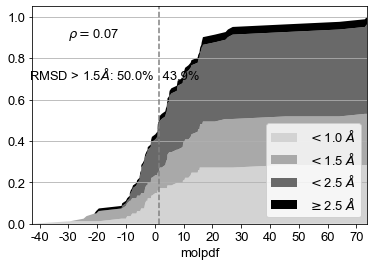

[0.39506173 0.04938272 0.0617284  0.        ]
median score: 5.548798589936212


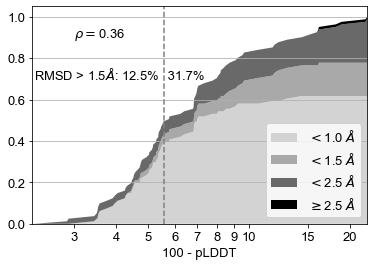

In [153]:
xticks=np.arange(-50,80,10)
fname=fig_dir+'/lddt_PANDORA_pdata.pdf'
make_hill_plot(pandora_results['pep_CA'],pandora_results['molpdf'],[1.,1.5,2.5],
               use_log=False,xticks=xticks,xlabel='molpdf',rho_x=-30,
               save_to=fname)
fname=fig_dir+'/lddt_TFold_pdata.pdf'
make_hill_plot(test_pandora['TFold'],test_pandora['score'],[1.,1.5,2.5],save_to=fname)

In [154]:
#confirm fraction of bad models in the half with energy less than median
x=pandora_results
z=x['pep_CA'][x['molpdf']<x['molpdf'].median()]
print(100*np.sum(z>1.5)/len(z))
#also note fraction of >=2.5 models: for them, the energy is able to distinguish => no mistake here

50.0


In [160]:
#unacceptable models total and below median score
print('PANDORA')
x=pandora_results
print(np.sum(x['pep_CA']>=2.5))
z=x[x['molpdf']<x['molpdf'].median()]
print(np.sum(z['pep_CA']>=2.5))
print(x[x['pep_CA']>=2.5])
print()
#same for tfold
print('TFold')
x=test_pandora
print(np.sum(x['TFold']>=2.5))
z=x[x['score']<x['score'].median()]
print(np.sum(z['TFold']>=2.5))
print(x[x['TFold']>=2.5])

PANDORA
3
2
   netmhc_anchors pandora_template    molpdf        DOPE    pep_CA   pep_all  \
2         [2, 10]             4O2E  -1.23705 -1033.46643  2.855103  3.731949   
13        [2, 10]             5VGD -20.99023  -661.67944  2.590921  4.154107   
70         [2, 9]             3BZF  16.27730  -988.28186  5.392097  4.984343   

      mhc_CA   mhc_all  pmhc_id  
2   0.857799  1.729823      349  
13  1.071797  1.879326       55  
70  1.475392  1.930962      601  

TFold
1
0
    pmhc_id  model_id tpl_tails  best_score  best_mhc_score  \
29      273         0    (0, 0)           8               0   

    register_identified af_tails  \
29                 True   (0, 0)   

                                             pep_lddt  \
29  [[P   1 , 90.35163717896285], [P   2 , 90.5247...   

                                             mhc_lddt     TFold  ...  \
29  [[M   7 , 98.48125255185161], [M  63 , 97.2379...  2.647847  ...   

     netmhc_kd         pep                                  

## class II alleles with possible non-canonical registers

In [ ]:
#DRB3*01:01, DRB5*01:01, (DRB1*13:02)

In [14]:
c_dir='/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/processed'
print(os.listdir(c_dir+'/batch_0'))

['result_old.pckl', 'input_new.pckl', 'result.pckl', 'input.pckl', 'outputs', 'input_old.pckl']


In [23]:
all_batches=os.listdir(c_dir)
print('batches total:',len(all_batches))
df=[]
n=10
print(f'sampling {n}...')
for b in np.random.choice(all_batches,10,False):
    df.append(pd.read_pickle(f'/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/processed/{b}/result.pckl'))
df=pd.concat(df)
print(len(df),df.columns)

batches total: 128
sampling 10...
53360 Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'kd', 'n_reg_filtered', 'af_n_reg',
       'seqnn_logkd'],
      dtype='object')


In [24]:
alleles=[('9606','DRB3','01:01'),('9606','DRB5','01:01'),('9606','DRB1','13:02')]
def reduce_mhc(x):
    x=x.info
    return x['species'],x['locus'],x['allele']
n=len(df)
n_nonident=n-np.sum(df['register_identified'])
df_a=df[df['mhc_b'].map(reduce_mhc).isin(alleles)]
n_a=len(df_a)
n_nonident_a=n_a-np.sum(df_a['register_identified'])
print('register not identified:')
print('among all: {} of {} ({:4.2f})'.format(n_nonident,n,n_nonident/n))
print('among subset: {} of {} ({:4.2f})'.format(n_nonident_a,n_a,n_nonident_a/n_a))

#problem: most non-idents will be from very wrong tails; expected difference small compared to background 

register not identified:
among all: 11530 of 53360 (0.22)
among subset: 1534 of 6780 (0.23)


In [30]:
#seq_tools.load_tcrs()
#seq_tools.tcrs['9606','TRBV6-1','01'].seq()
seq_tools.mhcs['9606','A','02:01'].seq()

'GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRT'

# test seqnn

In [18]:
#load assays
train_i=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/train_i.pckl')
train_ii=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/train_ii.pckl')
train_i_copy=train_i.copy()   #save a copy
train_ii_copy=train_ii.copy()
test_i=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/test_i.pckl')
test_ii=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/test_ii.pckl')
print(len(train_i),len(train_ii),len(test_i),len(test_ii))

199902 115836 399 472


In [19]:
def classify_mhc_i(x):
    if x[0]=='9606':
        return 'HLA-'+x[1]
    elif x[0]=='10090':
        return 'mouse'
    else:
        return 'other species'
def classify_mhc_ii(x):
    if x[0] not in ['9606','10090']:
        return 'other species'
    else:
        return x[1][:2]

print('CLASS I')
c_train=train_i['mhc_a'].map(classify_mhc_i).value_counts().sort_index()
c_test=test_i['mhc_a'].map(classify_mhc_i).value_counts()
df=pd.DataFrame({'train':c_train,'test':c_test})
df['test']=df['test'].fillna(0).astype(int)
print(df)
print()
print('CLASS II')
c_train=train_ii['mhc_a'].map(classify_mhc_ii).value_counts().sort_index()
c_test=test_ii['mhc_a'].map(classify_mhc_ii).value_counts()
df=pd.DataFrame({'train':c_train,'test':c_test})
df['test']=df['test'].fillna(0).astype(int)
print(df)

CLASS I
                train  test
HLA-A          102900   225
HLA-B           62940   148
HLA-C            3551    11
HLA-E             374    15
mouse           10600     0
other species   19537     0

CLASS II
               train  test
DP             13643     0
DQ             21421    43
DR             78114   429
IA              2201     0
IE               352     0
other species    105     0


In [20]:
import tfold.nn.nn_predict as nn_predict
importlib.reload(nn_predict)
predict=nn_predict.predict

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.8 s


In [42]:
mlists={}
for cl in ['I','II']:
    with open(nn_predict.seqnn_obj_dir+f'/model_list_{cl}.pckl','rb') as f:
        mlists[cl]=pickle.load(f)

In [43]:
print(len(mlists['I'])) #135 models for cl I
mlists['II']

135


[(11,)]

In [44]:
cl='II'
models=set()
for x in os.listdir(nn_predict.seqnn_obj_dir+'/weights'):
    x=x.split('.')[0].split('_')
    if x[1]==cl:
        models.add(tuple(x))
print(len(models))

150


In [45]:
len(models)

150

## cl I

In [74]:
train_i=predict(train_i.sample(1000),'I',mhc_as_obj=False)
test_i=predict(test_i,'I',mhc_as_obj=False)
struct_i=predict(struct_i,'I',mhc_as_obj=True)
struct_i_test=predict(struct_i_test,'I',mhc_as_obj=True)

making Kd predictions for 1000 pmhcs...


2023-02-01 21:45:26.345938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 399 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 270 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 101 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


REGISTER ERRORS
discovery dataset: 270 pmhcs
test dataset: 101 pmhcs
DISCOVERY:
canonical: 13
netmhc: 9
seqnn: 6
tfold: 2
TEST
canonical: 3
netmhc: 3
seqnn: 2
tfold: 3
p-value for algs canonical, tfold: 0.01
p-value for algs netmhc, tfold: 0.06


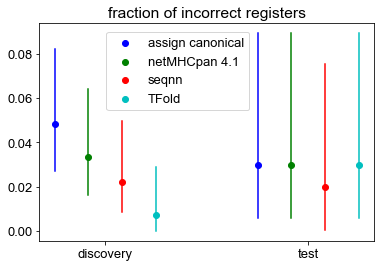

In [77]:
#compare register prediction
print('REGISTER ERRORS')

df=struct_i
N=len(df)
print(f'discovery dataset: {N} pmhcs')
d_discovery={} #name: (n,mean,ci_min,ci_max)
n=np.sum(df['tails']!=(0,0)) #simply canonical assignment
d_discovery['canonical']=[n,n/N]+list(utils.agresti_coull(n,N))
for k in ['netmhc','seqnn']:
    n=np.sum(df[f'{k}_tails']!=df['tails'])
    d_discovery[k]=[n,n/N]+list(utils.agresti_coull(n,N))
#add modeling results
x=tfold_discovery_dfs['I']
tfold_d=np.sum(x['af_tails']!=x['tails'])
d_discovery['tfold']=[tfold_d,tfold_d/N]+list(utils.agresti_coull(tfold_d,N))
    
df=struct_i_test
N=len(df)
print(f'test dataset: {N} pmhcs')
d_test={}
n=np.sum(df['tails']!=(0,0)) #simply canonical assignment
d_test['canonical']=[n,n/N]+list(utils.agresti_coull(n,N))
for k in ['netmhc','seqnn']:
    n=np.sum(df[f'{k}_tails']!=df['tails'])
    d_test[k]=[n,n/N]+list(utils.agresti_coull(n,N))
#add modeling results
x=tfold_test_dfs['I']
tfold_t=np.sum(x['af_tails']!=x['tails'])
d_test['tfold']=[tfold_t,tfold_t/N]+list(utils.agresti_coull(tfold_t,N))

#ensure order
kdisc=list(d_discovery.keys())
d_test={k:d_test[k] for k in kdisc}
print('DISCOVERY:')
for k in d_discovery:
    print('{}: {}'.format(k,d_discovery[k][0]))
print('TEST')
for k in d_test:
    print('{}: {}'.format(k,d_test[k][0]))

#p-values (on discovery)
if True:
    n=len(struct_i)
    p1_i,p1_j=0,3
    p1=utils.proportions_p_value(d_discovery[kdisc[p1_i]][0],n,d_discovery[kdisc[p1_j]][0],n,n_repeats=100000)
    p1='{:4.2f}'.format(p1)
    print('p-value for algs {}, {}: {}'.format(kdisc[p1_i],kdisc[p1_j],p1))
    p1_i,p1_j=1,3
    p1=utils.proportions_p_value(d_discovery[kdisc[p1_i]][0],n,d_discovery[kdisc[p1_j]][0],n,n_repeats=100000)
    p1='{:4.2f}'.format(p1)
    print('p-value for algs {}, {}: {}'.format(kdisc[p1_i],kdisc[p1_j],p1))

#proper naming
rename_dict={'canonical':'assign canonical','netmhc':'netMHCpan 4.1','seqnn':'seqnn','tfold':'TFold'}

colors=['b','g','r','c','m','y','k']
def plot_one(d,shift):
    artists=[]
    for i,k in enumerate(d):
        v=d[k]
        artists.append(plt.scatter([i+shift],v[1],label=k,color=colors[i]))
        plt.plot([i+shift,i+shift],[v[2],v[3]],label=k,color=colors[i])
    return artists
def plot_pvalue(i,j,shift_x,shift_y,y,p):
    s=f'p={p}'
    plt.plot(shift_x+np.array([i,i,j,j]),y+shift_y*np.array([-1.,0.,0.,-1.]),color='black')
    plt.text(shift_x+(i+j)/2-0.1*len(s),y+shift_y,s)
n1=len(d_discovery)
plt.figure()
artists=plot_one(d_discovery,0)
plot_one(d_test,n1+2)
#plot_pvalue(p1_i,p1_j,0.,0.02,0.4,p1)
plt.legend(artists,[rename_dict[k] for k in kdisc],loc=(0.2,0.6))
plt.xticks([0.5*(n1-1),0.5*(n1-1)+n1+2],['discovery','test'])
plt.title('fraction of incorrect registers')

save_to=fig_dir+'/regerr_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')

plt.show()

In [78]:
#look at regerrors
print('DISCOVERY')
print('netmhc')
x=struct_i.copy()
x['mhc']=x['mhc_a'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
print(x[x['netmhc_tails']!=x['tails']][['pmhc_id','pep','mhc','tails','netmhc_tails']])
print('seqnn')
print(x[x['seqnn_tails']!=x['tails']][['pmhc_id','pep','mhc','tails','seqnn_tails']])
print('tfold')
x=tfold_discovery_dfs['I'].copy()
x['mhc']=x['mhc_a'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
print(x[x['af_tails']!=x['tails']][['pmhc_id','pep','mhc','tails','af_tails','best_mhc_score']])
print()
print('TEST')
print('netmhc regerr')
x=struct_i_test.copy()
x['mhc']=x['mhc_a'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
print(x[x['netmhc_tails']!=x['tails']][['pmhc_id','pep','mhc','tails','netmhc_tails']])
print('seqnn regerr')
print(x[x['seqnn_tails']!=x['tails']][['pmhc_id','pep','mhc','tails','seqnn_tails']])
print('tfold')
x=tfold_test_dfs['I']
print(x[x['af_tails']!=x['tails']][['pmhc_id','pep','mhc_a','tails','af_tails','best_mhc_score']])

DISCOVERY
netmhc
     pmhc_id            pep                  mhc    tails netmhc_tails
49        56     TSTTSVASSW     (9606, B, 57:01)   (1, 0)       (0, 0)
124      168  WIYVYRPMGCGGS        (10090, K, b)   (0, 5)       (0, 0)
137      185      YQSGLSIVM        (10090, K, d)  (-1, 1)       (0, 0)
170      245       IDWFDGKD  (9031, BF2, 004:01)   (0, 0)      (0, -1)
183      272     TSTLQEQIGW     (9606, B, 58:01)   (1, 0)       (0, 0)
241      389     TSTLQEQIGW     (9606, B, 57:01)   (1, 0)       (0, 0)
246      402     SSTRGISQLW     (9606, B, 57:01)   (1, 0)       (0, 0)
281      484      AVKGVGTMV  (9031, BF2, 012:01)   (0, 1)       (0, 0)
408      826   TSTFEDVKILAF     (9606, B, 57:01)   (1, 0)       (0, 0)
seqnn
     pmhc_id           pep                  mhc    tails seqnn_tails
137      185     YQSGLSIVM        (10090, K, d)  (-1, 1)      (0, 0)
168      242    ETSPLTAEKL     (9606, A, 68:01)   (0, 1)      (0, 0)
243      397      HLEVQGYW     (9531, B, 39:01)  (-1, 0)    

{'HLA-A': 80, 'HLA-B': 79, 'HLA-C': 7, 'HLA-E': 1, 'HLA-G': 3, 'mouse': 61, 'other species': 39}


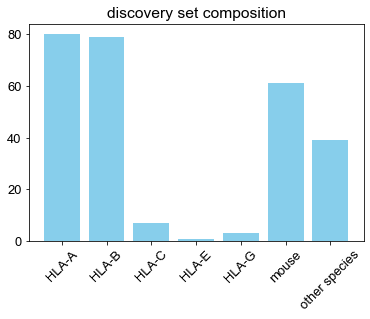

{'HLA-A': 46, 'HLA-B': 19, 'HLA-C': 3, 'HLA-E': 4, 'mouse': 9, 'other species': 20}


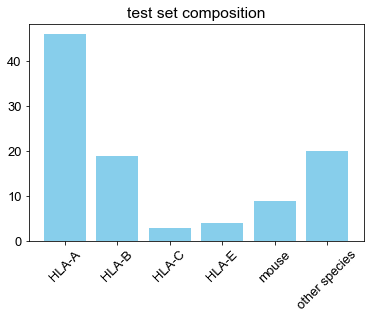

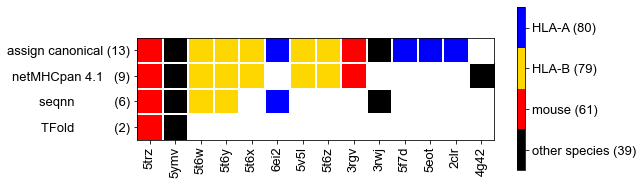

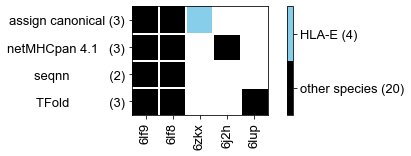

In [80]:
def classify_mhc(x):
    if x[0]=='9606':
        return 'HLA-'+x[1]
    elif x[0]=='10090':
        return 'mouse'
    else:
        return 'other species'
discovery_counts=struct_i['mhc_a'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
discovery_counts={k:discovery_counts[k] for k in np.sort(list(discovery_counts.keys()))}
print(discovery_counts)
plt.figure()
plt.bar(np.arange(len(discovery_counts)),discovery_counts.values(),color='skyblue')
plt.xticks(np.arange(len(discovery_counts)),discovery_counts.keys(),rotation=45)
plt.title('discovery set composition')
save_to=fig_dir+'/discovery_comp_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

test_counts=struct_i_test['mhc_a'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
test_counts={k:test_counts[k] for k in np.sort(list(test_counts.keys()))}
print(test_counts)
plt.figure()
plt.bar(np.arange(len(test_counts)),test_counts.values(),color='skyblue')
plt.xticks(np.arange(len(test_counts)),test_counts.keys(),rotation=45)
plt.title('test set composition')
save_to=fig_dir+'/test_comp_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#assign colors
colors={'HLA-A':'blue','HLA-B':'gold','HLA-C':'skyblue','HLA-E':'skyblue','HLA-F':'skyblue','HLA-G':'skyblue',
        'mouse':'red','other species':'k'}
#note: same color for multiple labels; if more than one of those labels occurs in a plot,
#will have to merge duplicates in colorbar or change color assignments

algs=['canonical','netmhc','seqnn','tfold'] #choose manually to be able to restrict and order
alg_dict={'canonical':'assign canonical','netmhc':'netMHCpan 4.1','seqnn':'seqnn','tfold':'TFold'}
    
#DISCOVERY
df,df_tfold=struct_i,tfold_discovery_dfs['I']
d={} #pmhc_ids for each alg
for k in algs:
    if k=='canonical':
        d[k]=df[df['tails']!=(0,0)]['pmhc_id'].values
    elif k=='tfold':
        d[k]=df_tfold[df_tfold['af_tails']!=df_tfold['tails']]['pmhc_id'].values
    else:
        d[k]=df[df[k+'_tails']!=df['tails']]['pmhc_id'].values
alg_ticks=['{:15s} ({})'.format(alg_dict[k],len(v)) for k,v in d.items()]
ids_all=list(np.unique([a for v in d.values() for a in v]))
pdb_ids=np.array([pmhcs[i]['pdbs'][0][0].split('_')[0] for i in ids_all])
loci=[]
id_to_locus={}
for i in ids_all:
    x=pmhcs[i]['M']['info']
    x=classify_mhc((x['species'],x['locus'],x['allele']))
    loci.append(x)
    id_to_locus[i]=x
loci_u=np.sort(np.unique(loci))[::-1] #cbar labeled bottom to top => invert
c_colors=[colors[k] for k in loci_u]
matrices={}
for l in loci_u:
    matrices[l]=np.zeros((len(d),len(ids_all)))
for i,k in enumerate(d):
    for j in d[k]:  
        matrices[id_to_locus[j]][i,ids_all.index(j)]=1.
neg_counts=-np.sum(list(matrices.values()),axis=(0,1))
ind=np.argsort(np.array(list(zip(loci,neg_counts)),dtype=[('locus','U2'),('counts',int)]),order=['counts','locus'])
for l in matrices:
    matrices[l]=matrices[l][:,ind]
pdb_ids=pdb_ids[ind]
data=np.sum([(i+1)*m for i,m in enumerate(matrices.values())],axis=0)
data_masked=np.ma.masked_where(data==0,data)
cbar_labels=['{:2s} ({})'.format(k,discovery_counts[k]) for k in matrices]
cmap=ListedColormap(c_colors)
plt.figure(figsize=(8,3))
mat=plt.imshow(data_masked, cmap=cmap, vmin=np.min(data_masked)-0.5, vmax=np.max(data_masked)+0.5)
cax=plt.colorbar(mat,ticks=np.arange(np.min(data_masked),np.max(data_masked) + 1))
cax.ax.set_yticklabels(cbar_labels)
plt.xticks(np.arange(len(ids_all)),pdb_ids,rotation=90)
plt.yticks(np.arange(len(d.keys())),alg_ticks)
for i in range(1,len(d)):
    plt.axhline(-0.5+i,color='w',linewidth=2)
for i in range(1,len(ids_all)):
    plt.axvline(-0.5+i,color='w',linewidth=2)
save_to=fig_dir+'/regerr_bars_discovery_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#TEST
df,df_tfold=struct_i_test,tfold_test_dfs['I']
d={} #pmhc_ids for each alg
for k in algs:
    if k=='canonical':
        d[k]=df[df['tails']!=(0,0)]['pmhc_id'].values
    elif k=='tfold':
        d[k]=df_tfold[df_tfold['af_tails']!=df_tfold['tails']]['pmhc_id'].values
    else:
        d[k]=df[df[k+'_tails']!=df['tails']]['pmhc_id'].values
alg_ticks=['{:15s} ({})'.format(alg_dict[k],len(v)) for k,v in d.items()]
ids_all=list(np.unique([a for v in d.values() for a in v]))
pdb_ids=np.array([pmhcs[i]['pdbs'][0][0].split('_')[0] for i in ids_all])
loci=[]
id_to_locus={}
for i in ids_all:
    x=pmhcs[i]['M']['info']
    x=classify_mhc((x['species'],x['locus'],x['allele']))
    loci.append(x)
    id_to_locus[i]=x
loci_u=np.sort(np.unique(loci))[::-1] #cbar labeled bottom to top => invert
c_colors=[colors[k] for k in loci_u]
matrices={}
for l in loci_u:
    matrices[l]=np.zeros((len(d),len(ids_all)))
for i,k in enumerate(d):
    for j in d[k]:  
        matrices[id_to_locus[j]][i,ids_all.index(j)]=1.
neg_counts=-np.sum(list(matrices.values()),axis=(0,1))
ind=np.argsort(np.array(list(zip(loci,neg_counts)),dtype=[('locus','U2'),('counts',int)]),order=['counts','locus'])
for l in matrices:
    matrices[l]=matrices[l][:,ind]
pdb_ids=pdb_ids[ind]
data=np.sum([(i+1)*m for i,m in enumerate(matrices.values())],axis=0)
data_masked=np.ma.masked_where(data==0,data)
cbar_labels=['{:2s} ({})'.format(k,test_counts[k]) for k in matrices]
cmap=ListedColormap(c_colors)
plt.figure(figsize=(7,2))
mat=plt.imshow(data_masked, cmap=cmap, vmin=np.min(data_masked)-0.5, vmax=np.max(data_masked)+0.5)
cax=plt.colorbar(mat,ticks=np.arange(np.min(data_masked),np.max(data_masked) + 1))
cax.ax.set_yticklabels(cbar_labels)
plt.xticks(np.arange(len(ids_all)),pdb_ids,rotation=90)
plt.yticks(np.arange(len(d.keys())),alg_ticks)
for i in range(1,len(d)):
    plt.axhline(-0.5+i,color='w',linewidth=2)
for i in range(1,len(ids_all)):
    plt.axvline(-0.5+i,color='w',linewidth=2)
save_to=fig_dir+'/regerr_bars_test_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

{'HLA-A': 80, 'HLA-B': 79, 'HLA-C': 7, 'HLA-E': 1, 'HLA-G': 3, 'mouse': 61, 'other species': 39}
{'HLA-A': 46, 'HLA-B': 19, 'HLA-C': 3, 'HLA-E': 4, 'mouse': 9, 'other species': 20}
{'HLA-A': 80, 'HLA-B': 79, 'HLA-C': 7, 'HLA-E': 1, 'HLA-G': 3, 'mouse': 61, 'other species': 39}
{'HLA-A': 46, 'HLA-B': 19, 'HLA-C': 3, 'HLA-E': 4, 'HLA-G': 0, 'mouse': 9, 'other species': 20}


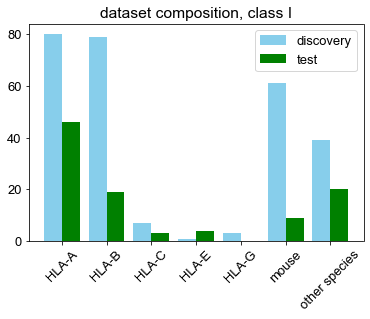

In [35]:
#dataset composition: plot discovery and test together
def classify_mhc(x):
    if x[0]=='9606':
        return 'HLA-'+x[1]
    elif x[0]=='10090':
        return 'mouse'
    else:
        return 'other species'
discovery_counts=struct_i['mhc_a'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
discovery_counts={k:discovery_counts[k] for k in np.sort(list(discovery_counts.keys()))}
print(discovery_counts)
test_counts=struct_i_test['mhc_a'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
test_counts={k:test_counts[k] for k in np.sort(list(test_counts.keys()))}
print(test_counts)
#merge
all_ticks=np.sort(list(set(discovery_counts.keys())|set(test_counts.keys())))
discovery_counts={k:discovery_counts.get(k) or 0 for k in all_ticks}
test_counts={k:test_counts.get(k) or 0 for k in all_ticks}
print(discovery_counts)
print(test_counts)

plt.figure()
w=0.4
plt.bar(-w/2+np.arange(len(all_ticks)),[discovery_counts[k] for k in all_ticks],width=w,color='skyblue')
plt.bar(w/2+np.arange(len(test_counts)),test_counts.values(),width=w,color='green')
plt.xticks(np.arange(len(all_ticks)),all_ticks,rotation=45)
plt.legend(['discovery','test'])
plt.title('dataset composition, class I')
save_to=fig_dir+'/comp_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [10]:
for i in [326,341]:
    x=struct_i_test.loc[i]
    print(x['pep'],x['mhc_a'].info['species'],x['mhc_a'].info['locus'],x['mhc_a'].info['allele'])
#conclusion: both are pig MHCs

RVEDVTNTAEYW 9823 1 13:01
RVEDVTNTAEYW 9823 1 04:01


In [11]:
#all non-trivial registers in test:
x=struct_i_test[struct_i_test['tails']!=(0,0)]
x[['pep','mhc_a']].apply(lambda y: (y['pep'],y['mhc_a'].info['species'],y['mhc_a'].info['locus'],y['mhc_a'].info['allele']),axis=1)

326    (RVEDVTNTAEYW, 9823, 1, 13:01)
332    (RLPAKAPLLGCG, 9606, E, 01:03)
341    (RVEDVTNTAEYW, 9823, 1, 04:01)
dtype: object

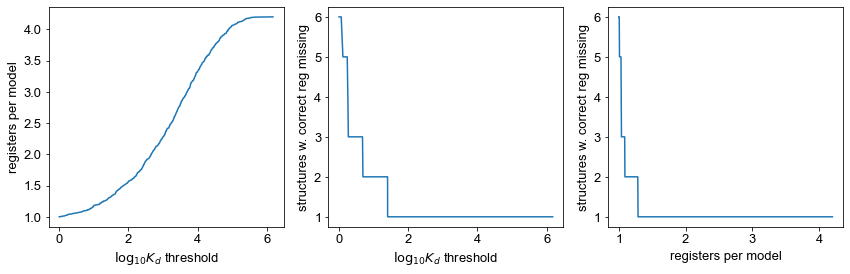

In [85]:
#regerror plot

def _subtract_mean(x):
    y=x['seqnn_logkds_all'].copy()
    y['logkd']=y['logkd']-x['seqnn_logkd']
    return y
def _pick_register(x,y,threshold):
    xx=np.stack(x['tail'])
    xx=x[(xx[:,0]==y[0])&(xx[:,1]==y[1])]
    if (len(xx)==0) or (xx[0]['logkd']>threshold):
        return 1    
    else:
        return 0

df=struct_i
kd_tuples=df.apply(_subtract_mean,axis=1)
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row['logkd']]))

error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x,y in zip(kd_tuples,df['tails']):
        registers_kept+=np.sum(x['logkd']<=threshold)        
        errors_kept+=_pick_register(x,y,threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel(r'$\log_{10}K_d$ threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel(r'$\log_{10}K_d$ threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.tight_layout()
save_to=fig_dir+'/kd_thresholds_I.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

train (sample of 1000): 1000
species: ['10090' '9544' '9598' '9606' '9796' '9823' '9913']


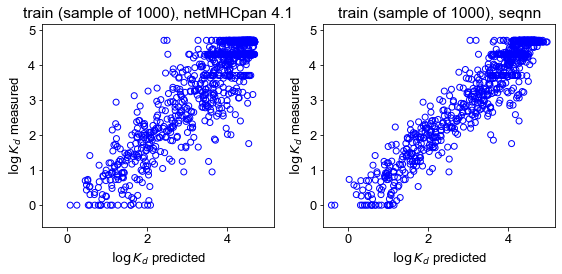

test (399): 399
species: ['9606']


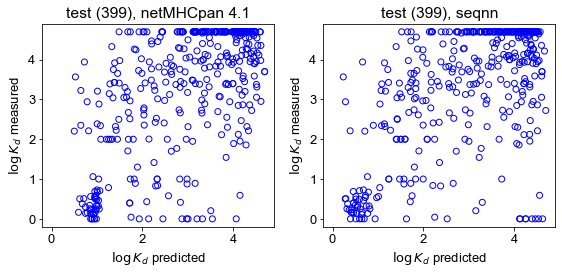

train bootstrap completed in  3.7 s
test bootstrap completed in  3.2 s


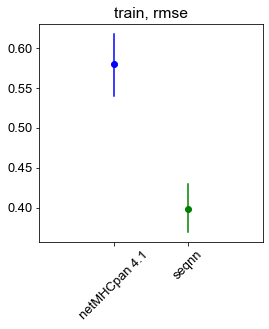

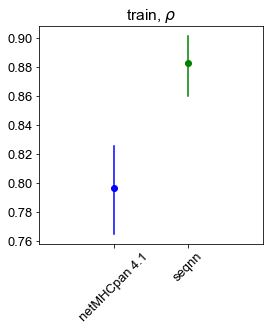

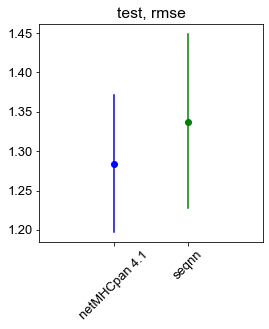

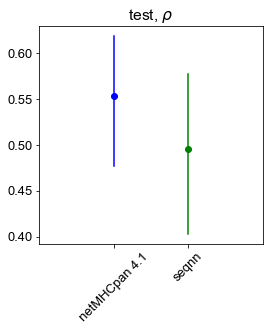

In [89]:
algs=['netmhc','seqnn']
alg_rename={'netmhc':'netMHCpan 4.1','seqnn':'seqnn'}

for df,name in [(train_i,f'train (sample of {len(train_i)})'),
                (test_i,f'test ({len(test_i)})')]:
    print('{}: {}'.format(name,len(df)))
    print('species: {}'.format(np.unique(df['mhc_a'].map(lambda x:x[0]))))
    #set boundaries
    v=np.log10(df['kd'])
    vmin,vmax=np.min(v),np.max(v)
    for a in algs:
        if 'netmhc' in a:
            x=np.log10(df[a+'_kd'])
        else:
            x=df[a+'_logkd'].values
        vmin=min(vmin,np.min(x))
        vmax=max(vmax,np.max(x))
    n=len(algs)
    plt.figure(figsize=(4*n,4))
    for i,a in enumerate(algs):
        if 'netmhc' in a:
            x=np.log10(df[a+'_kd'])
        else:
            x=df[a+'_logkd'].values
        y=np.log10(df['kd'])
        plt.subplot(1,n,i+1)
        plt.scatter(x,y,edgecolors='blue',facecolors='none')
        plt.xlabel(r'$\log K_d$ predicted')
        plt.ylabel(r'$\log K_d$ measured')
        plt.xlim(vmin-0.2,vmax+0.2)
        plt.ylim(vmin-0.2,vmax+0.2)
        plt.title(name+', '+alg_rename[a])
    plt.tight_layout()
    if 'train' in name:
        x='train'
    else:
        x='test'
    save_to=fig_dir+f'/kd_scatter_{x}_I.pdf'
    plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
    plt.show()

def rmse1(x,k):     #netmhc
    a=np.log10(x[k+'_kd'])
    return ((a-np.log10(x['kd']))**2).mean()**0.5
def rankcorr1(x,k):
    a=np.log10(x[k+'_kd'])
    return spearmanr(a,np.log10(x['kd'])).correlation
def rmse2(x,k): #seqnn
    a=x[k+'_logkd']
    return ((a-np.log10(x['kd']))**2).mean()**0.5
def rankcorr2(x,k):
    a=x[k+'_logkd']
    return spearmanr(a,np.log10(x['kd'])).correlation
func_dict={}
for k in ['netmhc']:
    func_dict['rmse|'+k]=lambda x,k=k:rmse1(x,k)
    func_dict['rankcorr|'+k]=lambda x,k=k:rankcorr1(x,k)
for k in ['seqnn']:
    func_dict['rmse|'+k]=lambda x,k=k:rmse2(x,k)
    func_dict['rankcorr|'+k]=lambda x,k=k:rankcorr2(x,k)

if True:
    t0=time.time()
    d_train=utils.bootstrap(train_i,func_dict)
    print('train bootstrap completed in {:4.1f} s'.format(time.time()-t0))
    t0=time.time()
    d_test=utils.bootstrap(test_i,func_dict)
    print('test bootstrap completed in {:4.1f} s'.format(time.time()-t0))

colors=['b','g','r','c','m','y','k']
err_rename={'rmse':'rmse','rankcorr':r'$\rho$'}
for df,name in [(d_train,'train'),(d_test,'test')]:
    for errtype in ['rmse','rankcorr']:
        artists=[]
        plt.figure(figsize=(4,4))
        for i,k in enumerate(algs):
            d=df[errtype+'|'+k]
            v=d.mean(),d.quantile(0.025),d.quantile(0.975)
            artists.append(plt.scatter([i],v[0],label=k,color=colors[i]))
            plt.plot([i,i],[v[1],v[2]],label=k,color=colors[i])
        plt.xlim(-1,2)
        plt.xticks(np.arange(len(algs)),[alg_rename[a] for a in algs],rotation=45)
        #plt.legend(artists,[alg_rename[a] for a in algs])
        plt.title('{}, {}'.format(name,err_rename[errtype]))
        save_to=fig_dir+f'/kd_{errtype}_{name}_I.pdf'
        plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
        plt.show() 

## cl II

In [48]:
include_pmhc_assays=True #otherwise only process struct

#to use seqnn version other than default
use_custom=False
model_list=[(33,)] #[(25,)] #33: af step 2; 25: af step 1 (not canonical? mask 10 derived from where?)

In [49]:
#can run multiple times to add different seqnn versions
#(run custom first, otherwise name conflict)

def rename_seqnn(df,seqnn_name):
    d={x:re.sub('seqnn_',f'seqnn{seqnn_name}_',x) for x in df.columns if 'seqnn_' in x}
    return df.rename(d,axis=1)
if use_custom:
    target_dir='/scratch/vmikhayl/tmp_pmhc_nn'
    params_dir=target_dir+'/inputs'
    weights_dir=target_dir+'/weights'
    t0=time.time()
    if include_pmhc_assays:
        df_t=train_ii.sample(10000)
        train_ii=predict(df_t,'II',mhc_as_obj=False,model_list=model_list,params_dir=params_dir,weights_dir=weights_dir)
        print('train prediction completed in {:5.1f} s'.format(time.time()-t0))
        test_ii=predict(test_ii,'II',mhc_as_obj=False,model_list=model_list,params_dir=params_dir,weights_dir=weights_dir)    
    struct_ii=predict(struct_ii,'II',mhc_as_obj=True,model_list=model_list,params_dir=params_dir,weights_dir=weights_dir)    
    struct_ii_test=predict(struct_ii_test,'II',mhc_as_obj=True,model_list=model_list,params_dir=params_dir,weights_dir=weights_dir)    
    n=model_list[0][0]
    if include_pmhc_assays:
        train_ii=rename_seqnn(train_ii,n)
        test_ii=rename_seqnn(test_ii,n)
    struct_ii=rename_seqnn(struct_ii,n)
    struct_ii_test=rename_seqnn(struct_ii_test,n)
else:
    t0=time.time()
    if include_pmhc_assays:
        df_t=train_ii.sample(10000)
        train_ii=predict(df_t,'II',mhc_as_obj=False)
        print('train prediction completed in {:5.1f} s'.format(time.time()-t0))
        test_ii=predict(test_ii,'II',mhc_as_obj=False)
    struct_ii=predict(struct_ii,'II',mhc_as_obj=True)
    struct_ii_test=predict(struct_ii_test,'II',mhc_as_obj=True)
    
#146 s for 10k train
#100k takes forever

making Kd predictions for 10000 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


train prediction completed in  96.2 s
making Kd predictions for 472 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 11 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [50]:
#add old netmhc scores to train_ii and test_ii

t0=time.time()
netmhc_tools.use_old_netmhc_II()
tmp_dir=os.getcwd()+'/tmp'
netmhc=netmhc_tools.NETMHC(tmp_dir)
netmhc.make_query(train_ii,'II')
os.system('./scripts/run_netmhc.sh')
train_ii=netmhc.parse()
train_ii=train_ii.rename({'netmhc_core_x':'netmhc_core','netmhc_kd_x':'netmhc_kd',
                          'netmhc_core_y':'netmhc32_core','netmhc_kd_y':'netmhc32_kd'},axis=1)
print('completed in {:5.1f} s'.format(time.time()-t0))

t0=time.time()
netmhc_tools.use_old_netmhc_II()
tmp_dir=os.getcwd()+'/tmp'
netmhc=netmhc_tools.NETMHC(tmp_dir)
netmhc.make_query(test_ii,'II')
os.system('./scripts/run_netmhc.sh')
test_ii=netmhc.parse()
test_ii=test_ii.rename({'netmhc_core_x':'netmhc_core','netmhc_kd_x':'netmhc_kd',
                        'netmhc_core_y':'netmhc32_core','netmhc_kd_y':'netmhc32_kd'},axis=1)
print('completed in {:5.1f} s'.format(time.time()-t0))

pmhcs with alleles known to netMHC: 9992
pmhcs with alleles not known to netMHC: 8
alleles not known:
[(('9544', 'DRA', '01:01'), ('9544', 'DRB', 'W002:01'))
 (('9544', 'DRA', '01:01'), ('9544', 'DRB1', '04:06'))]


Use of uninitialized value $rank_flag in numeric eq (==) at /home/vmikhayl/netMHCIIpan-3.2/NetMHCIIpan-3.2.pl line 1220, <IN> line 4.
Use of uninitialized value $rank_flag in numeric eq (==) at /home/vmikhayl/netMHCIIpan-3.2/NetMHCIIpan-3.2.pl line 1224, <IN> line 4.
Use of uninitialized value $rank_flag in numeric eq (==) at /home/vmikhayl/netMHCIIpan-3.2/NetMHCIIpan-3.2.pl line 1220, <IN> line 4.
Use of uninitialized value $rank_flag in numeric eq (==) at /home/vmikhayl/netMHCIIpan-3.2/NetMHCIIpan-3.2.pl line 1224, <IN> line 4.


pmhcs expected: 10000; loaded: 10000
completed in  93.6 s
pmhcs with alleles known to netMHC: 472
pmhcs with alleles not known to netMHC: 0
alleles not known:
[]
pmhcs expected: 472; loaded: 472
completed in  10.3 s


In [51]:
#add old netmhc scores to struct_ii and struct_ii_test 
##NOTE: mhc seq input fails for 5 structures in struct_ii (DQ)
##=> first run seq input, then allele input for what has failed

#struct_ii
netmhc_tools.use_old_netmhc_II()
tmp_dir=os.getcwd()+'/tmp'
netmhc=netmhc_tools.NETMHC(tmp_dir)
#mhc seq input
df=struct_ii.copy()
df['mhc_a']=df['mhc_a'].map(lambda x:x.seq())
df['mhc_b']=df['mhc_b'].map(lambda x:x.seq())
netmhc.make_query(df,'II',use_mhc_seq=True)
os.system('./scripts/run_netmhc.sh 2>/dev/null') #(suppress error messages)
df=netmhc.parse()
df=df[['pmhc_id','netmhc_core','netmhc_kd_y']]
print('seq input successful for:',len(df))
#mhc allele input for ones that failed
df1=struct_ii.copy()
df1=df1[~df1['pmhc_id'].isin(df['pmhc_id'])]
df1['mhc_a']=df1['mhc_a'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
df1['mhc_b']=df1['mhc_b'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
netmhc.make_query(df1,'II')
os.system('./scripts/run_netmhc.sh 2>/dev/null')
df1=netmhc.parse()
df1=df1[['pmhc_id','netmhc_core','netmhc_kd_y']]
print('allele input successful:',len(df1))
df=pd.concat([df,df1])
print('total:',len(df))
df=df.rename({'netmhc_kd_y':'netmhc32_kd','netmhc_core':'netmhc32_core',},axis=1)
struct_ii=struct_ii.merge(df,left_on='pmhc_id',right_on='pmhc_id')
print(len(struct_ii))
print(struct_ii.columns)

#struct_ii_test
netmhc=netmhc_tools.NETMHC(tmp_dir)
#mhc seq input
df=struct_ii_test.copy()
df['mhc_a']=df['mhc_a'].map(lambda x:x.seq())
df['mhc_b']=df['mhc_b'].map(lambda x:x.seq())
netmhc.make_query(df,'II',use_mhc_seq=True)
os.system('./scripts/run_netmhc.sh 2>/dev/null') #(suppress error messages)
df=netmhc.parse()
df=df[['pmhc_id','netmhc_core','netmhc_kd_y']]
print('seq input successful for:',len(df))
#mhc allele input for ones that failed
df1=struct_ii_test.copy()
df1=df1[~df1['pmhc_id'].isin(df['pmhc_id'])]
df1['mhc_a']=df1['mhc_a'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
df1['mhc_b']=df1['mhc_b'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
netmhc.make_query(df1,'II')
os.system('./scripts/run_netmhc.sh 2>/dev/null')
df1=netmhc.parse()
df1=df1[['pmhc_id','netmhc_core','netmhc_kd_y']]
print('allele input successful:',len(df1))
df=pd.concat([df,df1])
print('total:',len(df))
df=df.rename({'netmhc_kd_y':'netmhc32_kd','netmhc_core':'netmhc32_core',},axis=1)
struct_ii_test=struct_ii_test.merge(df,left_on='pmhc_id',right_on='pmhc_id')
print(len(struct_ii_test))
print(struct_ii_test.columns)

#compute tails
def _netmhc_tails(pep,pepcore):
    i=pep.index(pepcore)
    tl=i
    tr=len(pep)-len(pepcore)-i
    return tl,tr
struct_ii['netmhc32_tails']=struct_ii.apply(lambda x:_netmhc_tails(x['pep'],x['netmhc32_core']),axis=1)
struct_ii_test['netmhc32_tails']=struct_ii_test.apply(lambda x:_netmhc_tails(x['pep'],x['netmhc32_core']),axis=1)

pmhcs expected: 62; loaded: 57
seq input successful for: 57
pmhcs with alleles known to netMHC: 5
pmhcs with alleles not known to netMHC: 0
alleles not known:
[]
pmhcs expected: 5; loaded: 5
allele input successful: 5
total: 62
62
Index(['id', 'date', 'pmhc_id', 'class', 'tails', 'netmhc_tails', 'netmhc_kd',
       'pep', 'mhc_a', 'mhc_b', 'seqnn33_logkds_all', 'seqnn33_logkd',
       'seqnn33_tails', 'seqnn_logkds_all', 'seqnn_logkd', 'seqnn_tails',
       'netmhc32_core', 'netmhc32_kd'],
      dtype='object')
pmhcs expected: 11; loaded: 7
seq input successful for: 7
pmhcs with alleles known to netMHC: 4
pmhcs with alleles not known to netMHC: 0
alleles not known:
[]
pmhcs expected: 4; loaded: 4
allele input successful: 4
total: 11
11
Index(['id', 'date', 'pmhc_id', 'class', 'tails', 'netmhc_tails', 'netmhc_kd',
       'pep', 'mhc_a', 'mhc_b', 'seqnn33_logkds_all', 'seqnn33_logkd',
       'seqnn33_tails', 'seqnn_logkds_all', 'seqnn_logkd', 'seqnn_tails',
       'netmhc32_core', 'netmh

In [52]:
#linear regressions to possibly correct Kd
reg_coefs={}
reg=LinearRegression().fit(train_ii['seqnn33_logkd'].values.reshape(-1,1),np.log10(train_ii['kd']))
reg_coefs['seqnn33']=reg.coef_[0],reg.intercept_
reg=LinearRegression().fit(train_ii['seqnn_logkd'].values.reshape(-1,1),np.log10(train_ii['kd']))
reg_coefs['seqnn']=reg.coef_[0],reg.intercept_
reg=LinearRegression().fit(np.log10(train_ii['netmhc32_kd'].values).reshape(-1,1),np.log10(train_ii['kd']))
reg_coefs['netmhc32']=reg.coef_[0],reg.intercept_
reg=LinearRegression().fit(np.log10(train_ii['netmhc_kd'].values).reshape(-1,1),np.log10(train_ii['kd']))
reg_coefs['netmhc']=reg.coef_[0],reg.intercept_
for k,v in reg_coefs.items():
    print('{:8s} {:9.7f} {:9.7f}'.format(k,*v))

#10k sample 1:
#seqnn33  1.1406373 -0.2667923
#seqnn    1.0557755 -0.3378866
#netmhc32 1.1685402 -0.5292736
#netmhc   1.1348343 -0.4304763
#10k sample 2:
#seqnn33  1.1232603 -0.2084618
#seqnn    1.0432980 -0.2943506
#netmhc32 1.1584004 -0.4897210
#netmhc   1.1258912 -0.3875921
#fairly consistent!

seqnn33  1.1371008 -0.2334425
seqnn    1.0573065 -0.3261700
netmhc32 1.1794651 -0.5421471
netmhc   1.1451064 -0.4352643


REGISTER ERRORS
discovery dataset: 62 pmhcs
test dataset: 11 pmhcs
DISCOVERY:
netmhc: 16
netmhc32: 14
seqnn: 15
seqnn33: 11
tfold: 1
TEST
netmhc: 6
netmhc32: 3
seqnn: 6
seqnn33: 4
tfold: 1
!!p-value for discovery!!
p-value full: 0.00053
p-value for algs netmhc32, tfold: 5e-04
!!p-value for test!!
p-value full: 0.61792
p-value for algs netmhc32, tfold: 6e-01


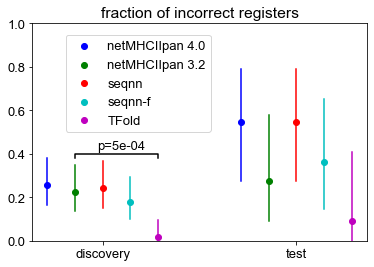

In [54]:
#compare register prediction
print('REGISTER ERRORS')

df=struct_ii
N=len(df)
print(f'discovery dataset: {N} pmhcs')
d_discovery={} #name: (n,mean,ci_min,ci_max)
for k in ['netmhc','netmhc32','seqnn','seqnn33']:
    n=np.sum(df[f'{k}_tails']!=df['tails'])
    d_discovery[k]=[n,n/N]+list(utils.agresti_coull(n,N))
#add modeling results
x=tfold_discovery_dfs['II']
tfold_d=np.sum(x['af_tails']!=x['tails'])
d_discovery['tfold']=[tfold_d,tfold_d/N]+list(utils.agresti_coull(tfold_d,N))
    
df=struct_ii_test
N=len(df)
print(f'test dataset: {N} pmhcs')
d_test={}
for k in ['netmhc','netmhc32','seqnn','seqnn33']:
    n=np.sum(df[f'{k}_tails']!=df['tails'])
    d_test[k]=[n,n/N]+list(utils.agresti_coull(n,N))
#add modeling results
x=tfold_test_dfs['II']
tfold_t=np.sum(x['af_tails']!=x['tails'])
d_test['tfold']=[tfold_t,tfold_t/N]+list(utils.agresti_coull(tfold_t,N))

#ensure order
kdisc=list(d_discovery.keys())
d_test={k:d_test[k] for k in kdisc}
print('DISCOVERY:')
for k in d_discovery:
    print('{}: {}'.format(k,d_discovery[k][0]))
print('TEST')
for k in d_test:
    print('{}: {}'.format(k,d_test[k][0]))

#p-values (on discovery)
if True:
    print('!!p-value for discovery!!')
    n=len(struct_ii)
    p1_i,p1_j=1,4
    p1=utils.proportions_p_value(d_discovery[kdisc[p1_i]][0],n,d_discovery[kdisc[p1_j]][0],n,n_repeats=100000)
    print('p-value full:',p1)
    p1='{:.0e}'.format(p1)
    print('p-value for algs {}, {}: {}'.format(kdisc[p1_i],kdisc[p1_j],p1))
    
    print('!!p-value for test!!')
    n=len(struct_ii)
    p2_i,p2_j=1,4
    p2=utils.proportions_p_value(d_test[kdisc[p1_i]][0],n,d_test[kdisc[p1_j]][0],n,n_repeats=100000)
    print('p-value full:',p2)
    p2='{:.0e}'.format(p2)
    print('p-value for algs {}, {}: {}'.format(kdisc[p2_i],kdisc[p2_j],p2))

#proper naming
rename_dict={'netmhc':'netMHCIIpan 4.0','netmhc32':'netMHCIIpan 3.2',
             'seqnn':'seqnn','seqnn33':'seqnn-f','tfold':'TFold'}

colors=['b','g','r','c','m','y','k']
def plot_one(d,shift):
    artists=[]
    for i,k in enumerate(d):
        v=d[k]
        artists.append(plt.scatter([i+shift],v[1],label=k,color=colors[i]))
        plt.plot([i+shift,i+shift],[v[2],v[3]],label=k,color=colors[i])
    return artists
def plot_pvalue(i,j,shift_x,shift_y,y,p):
    s=f'p={p}'
    plt.plot(shift_x+np.array([i,i,j,j]),y+shift_y*np.array([-1.,0.,0.,-1.]),color='black')
    plt.text(shift_x+(i+j)/2-0.1*len(s),y+shift_y,s)
n1=len(d_discovery)
plt.figure()
artists=plot_one(d_discovery,0)
plot_one(d_test,n1+2)
plt.ylim(0.,1.) #to fit legend
plot_pvalue(p1_i,p1_j,0.,0.02,0.4,p1) #for discovery
plt.legend(artists,[rename_dict[k] for k in kdisc],loc=(0.1,0.5))
plt.xticks([0.5*(n1-1),0.5*(n1-1)+n1+2],['discovery','test'])
plt.title('fraction of incorrect registers')

save_to=fig_dir+f'/regerr_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [7]:
print(4/62,14/62)

0.06451612903225806 0.22580645161290322


{'DP': 4, 'DQ': 9, 'DR': 29, 'IA': 14, 'IE': 6}


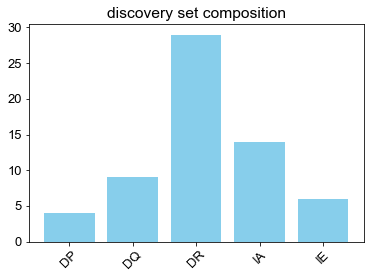

{'DQ': 6, 'DR': 3, 'IA': 2}


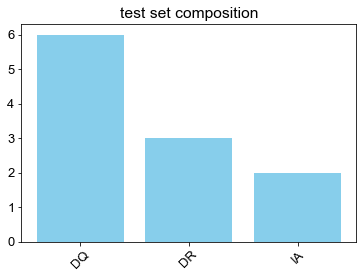

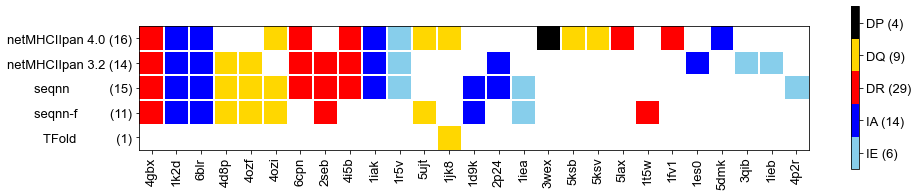

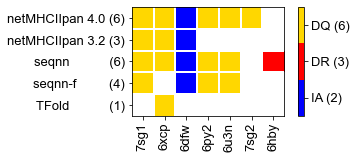

In [55]:
def classify_mhc(x):
    if x[0] not in ['9606','10090']:
        return 'other species'
    else:
        return x[1][:2]
discovery_counts=struct_ii['mhc_b'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
discovery_counts={k:discovery_counts[k] for k in np.sort(list(discovery_counts.keys()))}
print(discovery_counts)
plt.figure()
plt.bar(np.arange(len(discovery_counts)),discovery_counts.values(),color='skyblue')
plt.xticks(np.arange(len(discovery_counts)),discovery_counts.keys(),rotation=45)
plt.title('discovery set composition')
save_to=fig_dir+f'/discovery_comp_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

test_counts=struct_ii_test['mhc_b'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
test_counts={k:test_counts[k] for k in np.sort(list(test_counts.keys()))}
print(test_counts)
plt.figure()
plt.bar(np.arange(len(test_counts)),test_counts.values(),color='skyblue')
plt.xticks(np.arange(len(test_counts)),test_counts.keys(),rotation=45)
plt.title('test set composition')
save_to=fig_dir+f'/test_comp_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#assign colors
colors={'DP':'k','DQ':'gold','DR':'red','IA':'b','IE':'skyblue'}

algs=['netmhc','netmhc32','seqnn','seqnn33','tfold'] #choose manually to be able to restrict and order
alg_dict={'netmhc':'netMHCIIpan 4.0','netmhc32':'netMHCIIpan 3.2',
          'seqnn':'seqnn','seqnn33':'seqnn-f','tfold':'TFold'}
    
#DISCOVERY
df,df_tfold=struct_ii,tfold_discovery_dfs['II']
d={} #pmhc_ids for each alg
for k in algs:
    if k=='tfold':
        d[k]=df_tfold[df_tfold['af_tails']!=df_tfold['tails']]['pmhc_id'].values
    else:
        d[k]=df[df[k+'_tails']!=df['tails']]['pmhc_id'].values
alg_ticks=['{:15s} ({})'.format(alg_dict[k],len(v)) for k,v in d.items()]
ids_all=list(np.unique([a for v in d.values() for a in v]))
pdb_ids=np.array([pmhcs[i]['pdbs'][0][0].split('_')[0] for i in ids_all])
loci=[]
id_to_locus={}
for i in ids_all:
    x=pmhcs[i]['N']['info']
    x=classify_mhc((x['species'],x['locus'],x['allele']))
    loci.append(x)
    id_to_locus[i]=x
loci_u=np.sort(np.unique(loci))[::-1] #cbar labeled bottom to top => invert
c_colors=[colors[k] for k in loci_u]
matrices={}
for l in loci_u:
    matrices[l]=np.zeros((len(d),len(ids_all)))
for i,k in enumerate(d):
    for j in d[k]:  
        matrices[id_to_locus[j]][i,ids_all.index(j)]=1.
neg_counts=-np.sum(list(matrices.values()),axis=(0,1))
ind=np.argsort(np.array(list(zip(loci,neg_counts)),dtype=[('locus','U2'),('counts',int)]),order=['counts','locus'])
for l in matrices:
    matrices[l]=matrices[l][:,ind]
pdb_ids=pdb_ids[ind]
data=np.sum([(i+1)*m for i,m in enumerate(matrices.values())],axis=0)
data_masked=np.ma.masked_where(data==0,data)
cbar_labels=['{:2s} ({})'.format(k,discovery_counts[k]) for k in matrices]
cmap=ListedColormap(c_colors)
plt.figure(figsize=(15,3))
mat=plt.imshow(data_masked, cmap=cmap, vmin=np.min(data_masked)-0.5, vmax=np.max(data_masked)+0.5)
cax=plt.colorbar(mat,ticks=np.arange(np.min(data_masked),np.max(data_masked) + 1))
cax.ax.set_yticklabels(cbar_labels)
plt.xticks(np.arange(len(ids_all)),pdb_ids,rotation=90)
plt.yticks(np.arange(len(d.keys())),alg_ticks)
for i in range(1,len(d)):
    plt.axhline(-0.5+i,color='w',linewidth=2)
for i in range(1,len(ids_all)):
    plt.axvline(-0.5+i,color='w',linewidth=2)
save_to=fig_dir+f'/regerr_bars_discovery_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

#TEST
df,df_tfold=struct_ii_test,tfold_test_dfs['II']
d={} #pmhc_ids for each alg
for k in algs:
    if k=='tfold':
        d[k]=df_tfold[df_tfold['af_tails']!=df_tfold['tails']]['pmhc_id'].values
    else:
        d[k]=df[df[k+'_tails']!=df['tails']]['pmhc_id'].values
alg_ticks=['{:15s} ({})'.format(alg_dict[k],len(v)) for k,v in d.items()]
ids_all=list(np.unique([a for v in d.values() for a in v]))
pdb_ids=np.array([pmhcs[i]['pdbs'][0][0].split('_')[0] for i in ids_all])
loci=[]
id_to_locus={}
for i in ids_all:
    x=pmhcs[i]['N']['info']
    x=classify_mhc((x['species'],x['locus'],x['allele']))
    loci.append(x)
    id_to_locus[i]=x
loci_u=np.sort(np.unique(loci))[::-1] #cbar labeled bottom to top => invert
c_colors=[colors[k] for k in loci_u]
matrices={}
for l in loci_u:
    matrices[l]=np.zeros((len(d),len(ids_all)))
for i,k in enumerate(d):
    for j in d[k]:  
        matrices[id_to_locus[j]][i,ids_all.index(j)]=1.
neg_counts=-np.sum(list(matrices.values()),axis=(0,1))
ind=np.argsort(np.array(list(zip(loci,neg_counts)),dtype=[('locus','U2'),('counts',int)]),order=['counts','locus'])
for l in matrices:
    matrices[l]=matrices[l][:,ind]
pdb_ids=pdb_ids[ind]
data=np.sum([(i+1)*m for i,m in enumerate(matrices.values())],axis=0)
data_masked=np.ma.masked_where(data==0,data)
cbar_labels=['{:2s} ({})'.format(k,test_counts[k]) for k in matrices]
cmap=ListedColormap(c_colors)
plt.figure(figsize=(5,2))
mat=plt.imshow(data_masked, cmap=cmap, vmin=np.min(data_masked)-0.5, vmax=np.max(data_masked)+0.5)
cax=plt.colorbar(mat,ticks=np.arange(np.min(data_masked),np.max(data_masked) + 1))
cax.ax.set_yticklabels(cbar_labels)
plt.xticks(np.arange(len(ids_all)),pdb_ids,rotation=90)
plt.yticks(np.arange(len(d.keys())),alg_ticks)
for i in range(1,len(d)):
    plt.axhline(-0.5+i,color='w',linewidth=2)
for i in range(1,len(ids_all)):
    plt.axvline(-0.5+i,color='w',linewidth=2)
save_to=fig_dir+f'/regerr_bars_test_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

{'DP': 4, 'DQ': 9, 'DR': 29, 'IA': 14, 'IE': 6}
{'DQ': 6, 'DR': 3, 'IA': 2}
{'DP': 4, 'DQ': 9, 'DR': 29, 'IA': 14, 'IE': 6}
{'DP': 0, 'DQ': 6, 'DR': 3, 'IA': 2, 'IE': 0}


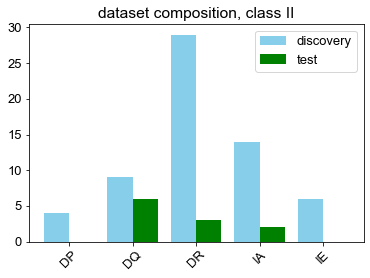

In [38]:
#plot dataset composition for discovery and test in single plot

def classify_mhc(x):
    if x[0] not in ['9606','10090']:
        return 'other species'
    else:
        return x[1][:2]
discovery_counts=struct_ii['mhc_b'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
discovery_counts={k:discovery_counts[k] for k in np.sort(list(discovery_counts.keys()))}
print(discovery_counts)
test_counts=struct_ii_test['mhc_b'].map(lambda x:
                                   (x.info['species'],x.info['locus'],x.info['allele'])).map(
                                   classify_mhc).value_counts().to_dict()
test_counts={k:test_counts[k] for k in np.sort(list(test_counts.keys()))}
print(test_counts)
#merge
all_ticks=np.sort(list(set(discovery_counts.keys())|set(test_counts.keys())))
discovery_counts={k:discovery_counts.get(k) or 0 for k in all_ticks}
test_counts={k:test_counts.get(k) or 0 for k in all_ticks}
print(discovery_counts)
print(test_counts)

plt.figure()
w=0.4
plt.bar(-w/2+np.arange(len(all_ticks)),[discovery_counts[k] for k in all_ticks],width=w,color='skyblue')
plt.bar(w/2+np.arange(len(test_counts)),test_counts.values(),width=w,color='green')
plt.xticks(np.arange(len(all_ticks)),all_ticks,rotation=45)
plt.legend(['discovery','test'])
plt.title('dataset composition, class II')
save_to=fig_dir+'/comp_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

0     False
1     False
2      True
3     False
4     False
      ...  
57    False
58    False
59     True
60     True
61    False
Name: mhc_b, Length: 62, dtype: bool

dq|netmhc|discovery      :  5 0.556 0.262 0.815
dq|netmhc32|discovery    :  2 0.222 0.052 0.564
dq|seqnn|discovery       :  3 0.333 0.115 0.654
dq|seqnn33|discovery     :  4 0.444 0.185 0.738
nondq|netmhc|discovery   : 11 0.208 0.117 0.339
nondq|netmhc32|discovery : 12 0.226 0.132 0.360
nondq|seqnn|discovery    : 12 0.226 0.132 0.360
nondq|seqnn33|discovery  :  7 0.132 0.061 0.254
dq|tfold|discovery       :  1 0.111 0.000 0.464
nondq|tfold|discovery    :  0 0.000 0.000 0.084
dq|netmhc|test           :  5 0.833 0.410 0.990
dq|netmhc32|test         :  2 0.333 0.090 0.710
dq|seqnn|test            :  4 0.667 0.290 0.910
dq|seqnn33|test          :  3 0.500 0.184 0.816
nondq|netmhc|test        :  1 0.200 0.019 0.648
nondq|netmhc32|test      :  1 0.200 0.019 0.648
nondq|seqnn|test         :  2 0.400 0.113 0.776
nondq|seqnn33|test       :  1 0.200 0.019 0.648
dq|tfold|test            :  1 0.167 0.010 0.590
nondq|tfold|test         :  0 0.000 0.000 0.499


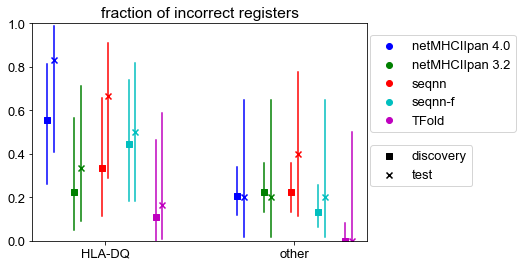

In [112]:
#DQ vs non-DQ regerr

data_dict={} #{'dq|netmhc|discovery':(n,N/n,*agresti_coull(n,N)),...}

#discovery
df_dq=struct_ii[struct_ii['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
df_nondq=struct_ii[~struct_ii['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
for df,name in zip([df_dq,df_nondq],['dq','nondq']):
    N=len(df)
    for k in ['netmhc','netmhc32','seqnn','seqnn33']:
        n=np.sum(df[f'{k}_tails']!=df['tails'])
        data_dict['|'.join([name,k,'discovery'])]=[n,n/N]+list(utils.agresti_coull(n,N))
#add modeling results
df1=tfold_discovery_dfs['II']
df_dq=df1[df1['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
df_nondq=df1[~df1['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
for df,name in zip([df_dq,df_nondq],['dq','nondq']):
    N=len(df)
    n=np.sum(df['af_tails']!=df['tails'])
    data_dict['|'.join([name,'tfold','discovery'])]=[n,n/N]+list(utils.agresti_coull(n,N))
    
#test
df=struct_ii_test
df_dq=struct_ii_test[struct_ii_test['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
df_nondq=struct_ii_test[~struct_ii_test['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
for df,name in zip([df_dq,df_nondq],['dq','nondq']):
    N=len(df)
    for k in ['netmhc','netmhc32','seqnn','seqnn33']:
        n=np.sum(df[f'{k}_tails']!=df['tails'])
        data_dict['|'.join([name,k,'test'])]=[n,n/N]+list(utils.agresti_coull(n,N))
#add modeling results
df1=tfold_test_dfs['II']
df_dq=df1[df1['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
df_nondq=df1[~df1['mhc_b'].map(lambda x: (x.info['species']=='9606') and ('DQB' in x.info['locus']))]
for df,name in zip([df_dq,df_nondq],['dq','nondq']):
    N=len(df)
    n=np.sum(df['af_tails']!=df['tails'])
    data_dict['|'.join([name,'tfold','test'])]=[n,n/N]+list(utils.agresti_coull(n,N))
    
for k in data_dict:
    print('{:25s}: {:2d} {:5.3f} {:5.3f} {:5.3f}'.format(k,*data_dict[k]))

#proper naming
rename_dict={'netmhc':'netMHCIIpan 4.0','netmhc32':'netMHCIIpan 3.2',
             'seqnn':'seqnn','seqnn33':'seqnn-f','tfold':'TFold'}
algs=['netmhc','netmhc32','seqnn','seqnn33','tfold']
colors=['b','g','r','c','m','y','k']
markers={'discovery':'s','test':'x'}
artists_alg=[]
artists_ds=[]
for i,hla in enumerate(['dq','nondq']):
    for j,alg in enumerate(algs):
        artists_alg.append(plt.scatter([],[],color=colors[j],marker='o'))
        for k,ds in enumerate(['discovery','test']):
            d=data_dict['|'.join([hla,alg,ds])]
            x=7*i+j+0.25*(k-0.5)
            plt.scatter(x,d[1],color=colors[j],marker=markers[ds])#edgecolors=colors[j],facecolors=None
            plt.plot([x,x],[d[2],d[3]],color=colors[j])
for ds in ['discovery','test']:
    artists_ds.append(plt.scatter([],[],marker=markers[ds],color='k'))
legend1=plt.legend(artists_alg,[rename_dict[k] for k in algs],loc=(1.01,0.5))
plt.legend(artists_ds,['discovery','test'],loc=(1.01,0.25))
plt.gca().add_artist(legend1)
plt.ylim(0.,1.)
plt.xticks([2,9],['HLA-DQ','other'])
plt.title('fraction of incorrect registers')
save_to=fig_dir+f'/regerr_DQ_nonDQ_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [105]:
struct_ii[struct_ii['tails']!=struct_ii['seqnn_tails']]

,id,date,pmhc_id,class,tails,netmhc_tails,netmhc_kd,pep,mhc_a,mhc_b,seqnn33_logkds_all,seqnn33_logkd,seqnn33_tails,seqnn_logkds_all,seqnn_logkd,seqnn_tails,netmhc32_core,netmhc32_kd,netmhc32_tails
4,67,2001-09-26,72,II,"(3, 10)","(8, 5)",2600.637544,HSRGGASQYRPSQRHGTGSGSG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 13), 4.389540672302246], [(1, 12), 4.211...",3.578937,"(5, 8)","[[(0, 13), 5.134925365447998], [(1, 12), 4.822...",4.318854,"(5, 8)",ASQYRPSQR,328.23,"(5, 8)"
6,72,2014-02-15,77,II,"(1, 3)","(1, 3)",2352.780774,APQPELPYPQPGS,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 4), 4.741868019104004], [(1, 3), 4.22994...",4.171759,"(3, 1)","[[(0, 4), 6.496819972991943], [(1, 3), 4.62144...",4.595226,"(3, 1)",PELPYPQPG,18529.07,"(3, 1)"
10,112,1996-04-05,133,II,"(8, 3)","(8, 3)",364.072351,RDSRGKKVITAFNEGLKGGG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 11), 4.975640296936035], [(1, 10), 4.859...",3.633177,"(7, 4)","[[(0, 11), 6.185179233551025], [(1, 10), 6.175...",4.206229,"(7, 4)",ITAFNEGLK,703.41,"(8, 3)"
13,130,1999-10-28,156,II,"(3, 4)","(3, 4)",14044.412723,GNSHRGAIEWEGIESG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 7), 4.842610836029053], [(1, 6), 4.86834...",4.448890,"(7, 0)","[[(0, 7), 4.949509143829346], [(1, 6), 5.20129...",4.377419,"(7, 0)",HRGAIEWEG,11314.54,"(3, 4)"
15,158,2012-11-28,190,II,"(0, 3)","(1, 2)",4608.568646,VVKQNCLKLATK,<tfold.utils.seq_tools.NUMSEQ object at 0x7f39...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 3), 2.568861961364746], [(1, 2), 2.90183...",2.568862,"(0, 3)","[[(0, 3), 3.952698230743408], [(1, 2), 3.61399...",3.613996,"(1, 2)",VKQNCLKLA,1157.92,"(1, 2)"
17,171,2004-02-05,216,II,"(1, 3)","(3, 1)",1668.128107,QPFPQPELPYPGS,<tfold.utils.seq_tools.NUMSEQ object at 0x7f39...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 4), 4.488770961761475], [(1, 3), 4.27530...",4.204319,"(3, 1)","[[(0, 4), 5.784419536590576], [(1, 3), 4.77222...",4.592858,"(3, 1)",PFPQPELPY,14946.89,"(1, 3)"
21,189,2012-07-28,248,II,"(-1, 2)","(1, 0)",22271.296069,GKQNCLKLAT,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 1), 4.0576605796813965], [(1, 0), 4.1887...",4.057661,"(0, 1)","[[(0, 1), 4.580221176147461], [(1, 0), 5.05015...",4.580221,"(0, 1)",KQNCLKLAT,12473.92,"(1, 0)"
23,195,2007-03-06,267,II,"(3, 3)","(3, 3)",2427.354976,GYGGRASDYKSAHKG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 6), 4.207076072692871], [(1, 5), 4.28528...",3.657202,"(3, 3)","[[(0, 6), 4.659552574157715], [(1, 5), 5.29840...",3.344949,"(5, 1)",ASDYKSAHK,1604.19,"(5, 1)"
30,275,2017-11-11,416,II,"(4, 3)","(5, 2)",4369.087483,HLVERLYLVCGEEGAG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 7), 3.8519864082336426], [(1, 6), 3.9231...",3.276639,"(5, 2)","[[(0, 7), 5.264841079711914], [(1, 6), 4.88724...",4.178939,"(5, 2)",ERLYLVCGE,12897.59,"(3, 4)"
33,296,2012-01-11,464,II,"(7, 3)","(7, 3)",16089.633134,RDSGPQPEQPEQPFPQPQG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f36...,"[[(0, 10), 5.390163898468018], [(1, 9), 4.9556...",4.499364,"(4, 6)","[[(0, 10), 6.431278705596924], [(1, 9), 5.0540...",4.544927,"(4, 6)",PQPEQPEQP,19001.72,"(4, 6)"


In [106]:
#plot register shifts for different alleles
#struct_ii[struct_ii['netmhc_tails']!=struct_ii['tails']]
def _reduce_mhc(x):
    s=x.info['species']
    if s=='9606':
        s='HLA'
    elif s=='10090':
        s='H2'            
    return s+'-'+x.info['locus']+'*'+x.info['allele']
def _reduce_mhc_ab(x):
    return _reduce_mhc(x['mhc_a'])+'/'+_reduce_mhc(x['mhc_b'])

df_c=struct_ii.copy()
df_c['mhc_str']=df_c.apply(_reduce_mhc_ab,axis=1)

k='netmhc_tails' #WHICH TAILS
print('TAILS:',k)
shifts={}
for m in np.sort(df_c['mhc_str'].unique()):    
    d=df_c[df_c['mhc_str']==m]   
    d1=d[k].map(lambda x:x[0])-d['tails'].map(lambda x:x[0])
    d1=d1.values    
    if np.all(d1==0):
        d1=[]
    else:
        shifts[m]=d1
    print('{:30s} {:2d} {}'.format(m,len(d),np.sort(d1)))
#WOW! there is a hybrid mouse MHC alpha chain + human MHC beta chain structure!! (2fse, pmhc_id=705)

#fraction of errors in DP, DQ, DR
for x in ['DP','DQ','DR']:
    d=struct_ii[struct_ii['mhc_str'].map(lambda a: x in a)]
    n=len(d)
    n_bad=np.sum(d['tails']!=d[k])
    print('{}: {} of {} are bad; fraction {:4.2f}'.format(x, n_bad, n, n_bad/n))
    
#more than one structure => more than one shift; the opposite of "systematic shifts"

TAILS: netmhc_tails
H2-IAA*b/H2-IAB*b               2 []
H2-IAA*d/H2-IAB*d               2 []
H2-IAA*d/H2-IAB*g7              5 [0 0 0 1 3]
H2-IAA*k/H2-IAB*k               2 [0 2]
H2-IAA*k/H2-IAB*u               2 [0 5]
H2-IAA*u/H2-IAB*u               1 []
H2-IEA*d/H2-IEB*k               6 [-1  0  0  0  0  0]
H2-IEA*d/HLA-DRB1*01:01         1 []
HLA-DPA1*01:03/HLA-DPB1*02:01   2 []
HLA-DPA1*01:03/HLA-DPB1*04:02   1 []
HLA-DPA1*02:02/HLA-DPB1*05:01   1 [3]
HLA-DQA1*03:01/HLA-DQB1*02:01   1 []
HLA-DQA1*03:01/HLA-DQB1*03:02   3 [0 2 2]
HLA-DQA1*05:01/HLA-DQB1*02:01   4 [0 0 2 2]
HLA-DQA1*05:01/HLA-DQB1*03:02   1 [1]
HLA-DRA*01:01/HLA-DRB1*01:01    9 [0 0 0 0 0 0 0 1 2]
HLA-DRA*01:01/HLA-DRB1*03:01    1 []
HLA-DRA*01:01/HLA-DRB1*04:01    6 [-1  0  0  0  0  0]
HLA-DRA*01:01/HLA-DRB1*04:04    1 []
HLA-DRA*01:01/HLA-DRB1*11:01    1 [-1]
HLA-DRA*01:01/HLA-DRB1*15:01    2 []
HLA-DRA*01:01/HLA-DRB1*15:02    1 []
HLA-DRA*01:01/HLA-DRB3*01:01    1 []
HLA-DRA*01:01/HLA-DRB3*03:01    3 []
HLA-DRA*01

KeyError: 'mhc_str'

min, max shifts: -1 5
max count: 7


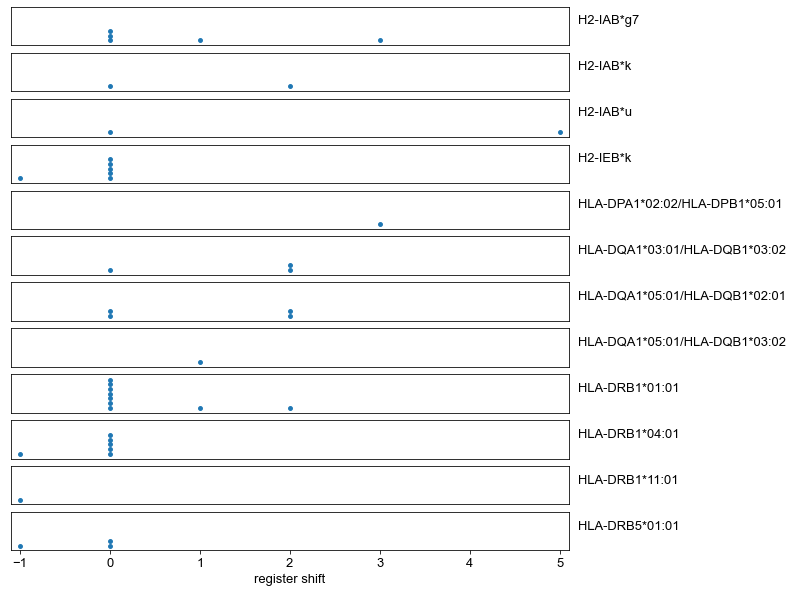

In [108]:
def reduce_allele(a): #drop alpha chain in mouse and DRB; hope that none of these differ only in alpha!
    if ('H2-' in a) or ('DRB' in a):
        return a.split('/')[1]
    else:
        return a
shifts1={reduce_allele(k):v for k,v in shifts.items()}
alleles=np.sort(list(shifts1.keys()))
n=len(alleles)
all_shifts=set([s for x in shifts1.values() for s in x])
s_min,s_max=min(all_shifts),max(all_shifts)
print('min, max shifts:',s_min,s_max)
max_count=0
for s in shifts1.values():
    for s1 in np.unique(s):
        max_count=max(max_count,np.sum(np.array(s)==s1))
print('max count:',max_count)
plt.figure(figsize=(10,10))
for i,a in enumerate(alleles):
    plt.subplot(n,1,i+1)
    mx,my=[],[]
    for s in np.unique(shifts1[a]):
        for j in range(np.sum(np.array(shifts1[a])==s)):
            mx.append(s)
            my.append(j)
    plt.scatter(mx,my,s=15.)
    plt.xlim(s_min-0.1,s_max+0.1)
    plt.ylim(-1,max_count+0.1)
    if i==n-1:
        plt.xticks(range(s_min,s_max+1))
        plt.xlabel('register shift')
    else:
        plt.xticks([])
    plt.yticks([])
    plt.text(s_max+0.2,max_count/2,a)
#plt.tight_layout()
save_to=fig_dir+f'/regerr_shifts_netmhc_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [40]:
struct_ii_test.apply(_reduce_mhc_ab,axis=1).value_counts()

HLA-DQA1*05:01/HLA-DQB1*02:01    3
HLA-DQA1*03:01/HLA-DQB1*03:02    1
H2-IAA*b/H2-IAB*b                1
HLA-DRA*01:01/HLA-DRB1*01:01     1
HLA-DQA1*02:01/HLA-DQB1*02:01    1
HLA-DQA1*01:02/HLA-DQB1*06:02    1
H2-IAA*d/H2-IAB*g7               1
HLA-DRA*01:01/HLA-DRB1*04:01     1
HLA-DRA*01:01/HLA-DRB1*03:01     1
dtype: int64

In [41]:
struct_ii_test[struct_ii_test['netmhc_tails']!=struct_ii_test['tails']].apply(_reduce_mhc_ab,axis=1).value_counts()

HLA-DQA1*05:01|HLA-DQB1*02:01    3
HLA-DQA1*03:01|HLA-DQB1*03:02    1
HLA-DQA1*02:01|HLA-DQB1*02:01    1
H2-IAA*d|H2-IAB*g7               1
dtype: int64

In [53]:
#significance of difference between proportions via simulation
#(idea from Coursera; should be used when numbers are small so that the normal approx doesn't work)
#fix total N and total failures, shuffle, see distribution of f1-f2
def proportions_p_value(n1,N1,n2,N2,n_repeats=10000):
    n=n1+n2
    N=N1+N2
    x=np.concatenate([np.ones(n),np.zeros(N-n)])
    deltas=[]
    for i in range(n_repeats):
        x=np.random.permutation(x)
        n1_c=np.sum(x[:N1])
        n2_c=n-n1_c
        deltas.append(n1_c/N1-n2_c/N2)
    return deltas
n1,N1,n2,N2=5,9,5,29 #5 of 9 wrong for DQ, 5 of 29 wrong for DR
#n1,N1,n2,N2=1,12,5,12 #Coursera example
deltas=proportions_p_value(n1,N1,n2,N2)
print('p-value:',np.sum(np.abs(deltas)>=abs(n1/N1-n2/N2))/len(deltas))

p-value: 0.0335


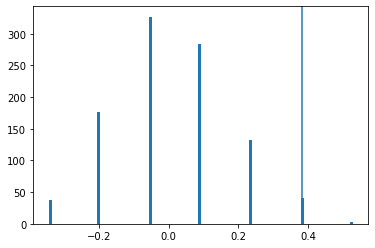

In [47]:
plt.figure()
plt.hist(deltas,bins=100)
plt.axvline(5/9-5/29)
plt.show()

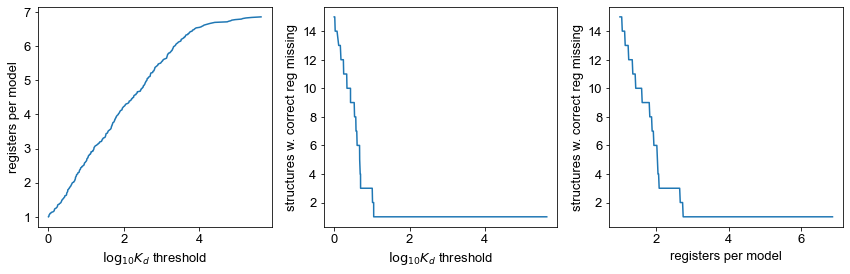

In [110]:
#regerror plot

def _subtract_mean(x):
    y=x['seqnn_logkds_all'].copy()
    y['logkd']=y['logkd']-x['seqnn_logkd']
    return y
def _pick_register(x,y,threshold):
    xx=np.stack(x['tail'])
    xx=x[(xx[:,0]==y[0])&(xx[:,1]==y[1])]
    if (len(xx)==0) or (xx[0]['logkd']>threshold):
        return 1    
    else:
        return 0

df=struct_ii
kd_tuples=df.apply(_subtract_mean,axis=1)
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row['logkd']]))

error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x,y in zip(kd_tuples,df['tails']):
        registers_kept+=np.sum(x['logkd']<=threshold)        
        errors_kept+=_pick_register(x,y,threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel(r'$\log_{10}K_d$ threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel(r'$\log_{10}K_d$ threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.tight_layout()
save_to=fig_dir+f'/kd_thresholds_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

train (sample of 1000): 1000
species: ['10090' '9544' '9606']


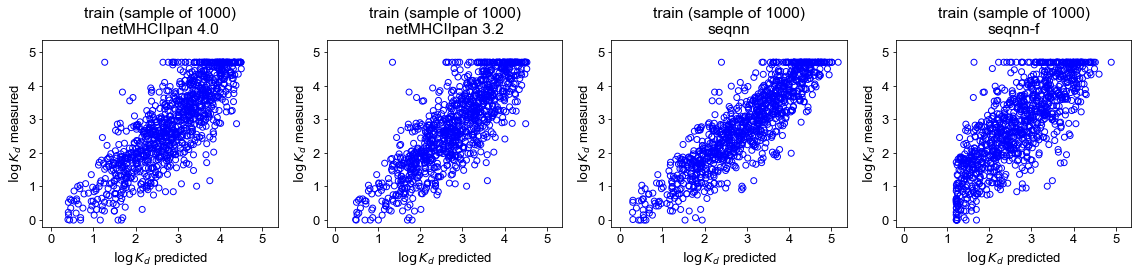

test (472): 472
species: ['9606']


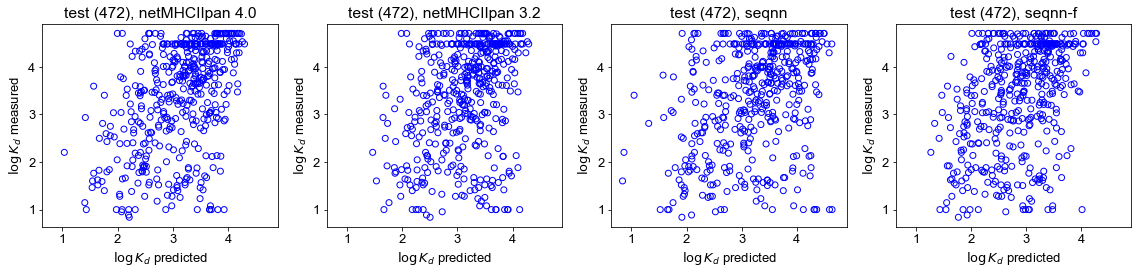

train bootstrap completed in 26.0 s
test bootstrap completed in  8.3 s
(test) rmsecorr, rmse, diff
netmhc   1.027 1.018 0.009
netmhc32 1.113 1.095 0.018
seqnn    1.128 1.091 0.037
seqnn33  1.110 1.158 -0.048


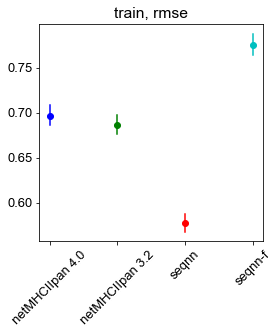

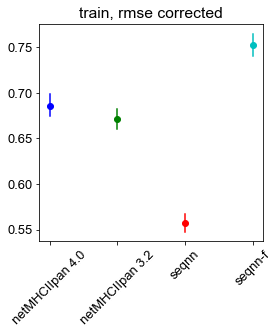

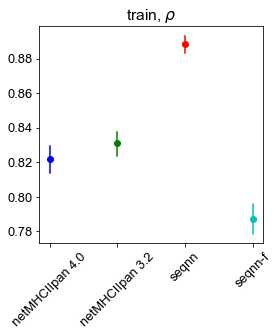

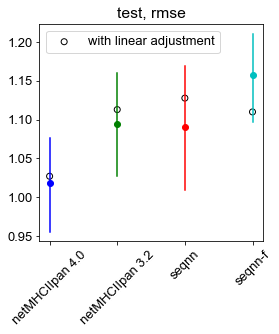

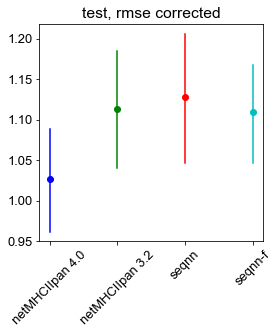

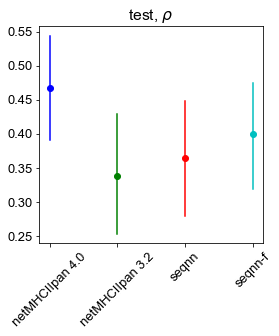

In [119]:
algs=['netmhc','netmhc32','seqnn','seqnn33']
alg_rename={'netmhc':'netMHCIIpan 4.0','netmhc32':'netMHCIIpan 3.2','seqnn':'seqnn','seqnn33':'seqnn-f'}

train_ii_sample=train_ii.sample(1000) #subsample
for df,name in [(train_ii_sample,f'train (sample of {len(train_ii_sample)})'),(test_ii,f'test ({len(test_ii)})')]:
    print('{}: {}'.format(name,len(df)))
    print('species: {}'.format(np.unique(df['mhc_b'].map(lambda x:x[0]))))
    #set boundaries
    v=np.log10(df['kd'])
    vmin,vmax=np.min(v),np.max(v)
    for a in algs:
        if 'netmhc' in a:
            x=np.log10(df[a+'_kd'])
        else:
            x=df[a+'_logkd'].values
        vmin=min(vmin,np.min(x))
        vmax=max(vmax,np.max(x))
    n=len(algs)
    plt.figure(figsize=(4*n,4))
    for i,a in enumerate(algs):
        if 'netmhc' in a:
            x=np.log10(df[a+'_kd'])
        else:
            x=df[a+'_logkd'].values
        y=np.log10(df['kd'])
        plt.subplot(1,n,i+1)
        plt.scatter(x,y,edgecolors='blue',facecolors='none')
        plt.xlabel(r'$\log K_d$ predicted')
        plt.ylabel(r'$\log K_d$ measured')
        plt.xlim(vmin-0.2,vmax+0.2)
        plt.ylim(vmin-0.2,vmax+0.2)
        if 'train' in name:
            s='\n'
        else:
            s=', '
        plt.title(name+s+alg_rename[a])
    plt.tight_layout()
    if 'train' in name:
        x='train'
    else:
        x='test'
    save_to=fig_dir+f'/kd_scatter_{x}_II.pdf'
    plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
    plt.show()

def rmsecorr1(x,k): #netmhc
    c=reg_coefs[k]
    a=np.log10(x[k+'_kd'])
    return ((c[0]*a+c[1]-np.log10(x['kd']))**2).mean()**0.5
def rmse1(x,k):     #netmhc
    a=np.log10(x[k+'_kd'])
    return ((a-np.log10(x['kd']))**2).mean()**0.5
def rankcorr1(x,k):
    a=np.log10(x[k+'_kd'])
    return spearmanr(a,np.log10(x['kd'])).correlation
def rmsecorr2(x,k): #seqnn
    c=reg_coefs[k]
    a=x[k+'_logkd']
    return ((c[0]*a+c[1]-np.log10(x['kd']))**2).mean()**0.5
def rmse2(x,k): #seqnn
    a=x[k+'_logkd']
    return ((a-np.log10(x['kd']))**2).mean()**0.5
def rankcorr2(x,k):
    a=x[k+'_logkd']
    return spearmanr(a,np.log10(x['kd'])).correlation
func_dict={}
for k in ['netmhc','netmhc32']:
    func_dict['rmsecorr|'+k]=lambda x,k=k:rmsecorr1(x,k)
    func_dict['rmse|'+k]=lambda x,k=k:rmse1(x,k)
    func_dict['rankcorr|'+k]=lambda x,k=k:rankcorr1(x,k)
for k in ['seqnn','seqnn33']:
    func_dict['rmsecorr|'+k]=lambda x,k=k:rmsecorr2(x,k)
    func_dict['rmse|'+k]=lambda x,k=k:rmse2(x,k)
    func_dict['rankcorr|'+k]=lambda x,k=k:rankcorr2(x,k)

if True:
    t0=time.time()
    d_train=utils.bootstrap(train_ii,func_dict)
    print('train bootstrap completed in {:4.1f} s'.format(time.time()-t0))
    t0=time.time()
    d_test=utils.bootstrap(test_ii,func_dict)
    print('test bootstrap completed in {:4.1f} s'.format(time.time()-t0))

#does correction improve rmse?
print('(test) rmsecorr, rmse, diff')
for k in ['netmhc','netmhc32','seqnn','seqnn33']:
    ecorr,e1=np.mean(d_test['rmsecorr|'+k]),np.mean(d_test['rmse|'+k])
    print('{:8s} {:5.3f} {:5.3f} {:5.3f}'.format(k,ecorr,e1,ecorr-e1))
#only for seqnn33, and the change is good! (need to correct others for good order though)

colors=['b','g','r','c','m','y','k']
err_rename={'rmse':'rmse','rmsecorr':'rmse corrected','rankcorr':r'$\rho$'}
for df,name in [(d_train,'train'),(d_test,'test')]:
    for errtype in ['rmse','rmsecorr','rankcorr']:
        plt.figure(figsize=(4,4))
        artists=[]
        for i,k in enumerate(algs):
            d=df[errtype+'|'+k]
            v=d.mean(),d.quantile(0.025),d.quantile(0.975)
            plt.scatter([i],v[0],label=k,color=colors[i])
            plt.plot([i,i],[v[1],v[2]],label=k,color=colors[i])
            if name=='test' and errtype=='rmse':# and k=='seqnn33':
                artists.append(plt.scatter([i],[df[f'rmsecorr|{k}'].mean()],edgecolors='k',facecolors='none'))
        plt.xticks(np.arange(len(algs)),[alg_rename[a] for a in algs],rotation=45)
        if name=='test' and errtype=='rmse':
            plt.legend(artists[:1],['with linear adjustment'])
        plt.title('{}, {}'.format(name,err_rename[errtype]))
        save_to=fig_dir+f'/kd_{errtype}_{name}_II.pdf'
        plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
        plt.show() 
        
#WHY IS PREDICTED logKD for TFOLD_AF CUT AT 1?
#looks like I forgot to turn off clamping somewhere

In [76]:
df=test_ii
df_drb=df[df['mhc_b'].map(lambda x: 'DRB' in x[1])]
df_dqb=df[df['mhc_b'].map(lambda x: 'DQB' in x[1])]
df_dpb=df[df['mhc_b'].map(lambda x: 'DPB' in x[1])]
print('total DRB:',len(df_drb),'total DQB:',len(df_dqb),'total DPB:',len(df_dpb))
df=df_dqb
print('netmhc DQB error:',np.average((np.log10(df['netmhc_kd'])-np.log10(df['kd']))**2)**0.5)
print('seqnn DQB error:',np.average((df['seqnn_logkd']-np.log10(df['kd']))**2)**0.5)
df=df_drb
print('netmhc DRB error:',np.average((np.log10(df['netmhc_kd'])-np.log10(df['kd']))**2)**0.5)
print('seqnn DRB error:',np.average((df['seqnn_logkd']-np.log10(df['kd']))**2)**0.5)

total DRB: 429 total DQB: 43 total DPB: 0
netmhc DQB error: 0.8699610244649177
seqnn DQB error: 0.9434810235619296
netmhc DRB error: 1.033002506587835
seqnn DRB error: 1.204265947840327


In [83]:
#count assays my MHC locus
for k in ['DRB','DQB','DPB']:
    print(k,np.sum(train_ii_copy['mhc_b'].map(lambda x: k in x[1])))

DRB 78219
DQB 21421
DPB 13643


In [78]:
x=struct_ii_test[['tails','netmhc_tails','seqnn_tails','mhc_b']].copy()
x['mhc_b']=x['mhc_b'].map(lambda x:(x.info['species'],x.info['locus'],x.info['allele']))
x

#           regerr
#   total netmhc seqnn
#dq   6      5     3
#dr   3      0     0

,tails,netmhc_tails,seqnn_tails,mhc_b
71,"(2, 5)","(4, 3)","(0, 7)","(9606, DQB1, 02:01)"
114,"(3, 3)","(4, 2)","(3, 3)","(9606, DQB1, 03:02)"
222,"(3, 3)","(3, 3)","(3, 3)","(10090, IAB, b)"
223,"(5, 5)","(5, 5)","(5, 5)","(9606, DRB1, 01:01)"
233,"(1, 2)","(2, 1)","(2, 1)","(9606, DQB1, 02:01)"
264,"(1, 3)","(3, 1)","(1, 3)","(9606, DQB1, 02:01)"
284,"(2, 2)","(2, 2)","(2, 2)","(9606, DQB1, 06:02)"
287,"(4, 3)","(6, 1)","(6, 1)","(10090, IAB, g7)"
293,"(1, 10)","(3, 8)","(9, 2)","(9606, DQB1, 02:01)"
329,"(4, 2)","(4, 2)","(4, 2)","(9606, DRB1, 04:01)"


# reg count vs Kd, on Kd test sets

In [24]:
#predict Kd on test sets
test_i=predict(test_i,'I',mhc_as_obj=False)
test_ii=predict(test_ii,'II',mhc_as_obj=False)

making Kd predictions for 399 pmhcs...


2023-02-19 21:33:16.495168: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


making Kd predictions for 472 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [61]:
#filter and count
thresholds={'I':10.,'II':100.}
df_regcounts={}
for cl,df in zip(thresholds,[test_i,test_ii]):
    df=df.copy()
    df['regcount']=df['seqnn_logkds_all'].map(lambda x: np.sum(x['logkd']-np.min(x['logkd'])<np.log10(thresholds[cl])))
    df['regcount_all']=df['seqnn_logkds_all'].map(len)
    df_regcounts[cl]=df[['kd','regcount','regcount_all','seqnn_logkds_all']].copy()

In [45]:
#plot

#boundaries=np.array([50,100,250,500,1000,2500,5000,10000,25000,50000])
boundaries=np.array([50,500,5000,25000,50000])
xticks=[r'$<$'+f'{boundaries[0]}']+[f'{boundaries[i-1]}-{boundaries[i]}' for i in range(1,len(boundaries))]+[r'$\geq$'+f'{boundaries[-1]}'] #to ensure order
def annotate_interval(x):
    i=np.sum((boundaries-x)<=0)
    if i==0:
        return r'$<$'+f'{boundaries[0]}'
    elif i==len(boundaries):
        return r'$\geq$'+f'{boundaries[-1]}'
    else:
        return f'{boundaries[i-1]}-{boundaries[i]}'
for cl in df_regcounts:
    df_regcounts[cl][r'$K_d$ interval']=df_regcounts[cl]['kd'].map(annotate_interval)
    print(cl)
    utils.print_hist(df_regcounts[cl][r'$K_d$ interval'].values)

I
$<$50        74
$\geq$50000 119
25000-50000  21
50-500       44
500-5000     72
5000-25000   69
II
$<$50        55
$\geq$50000  31
25000-50000  94
50-500       69
500-5000    119
5000-25000  104


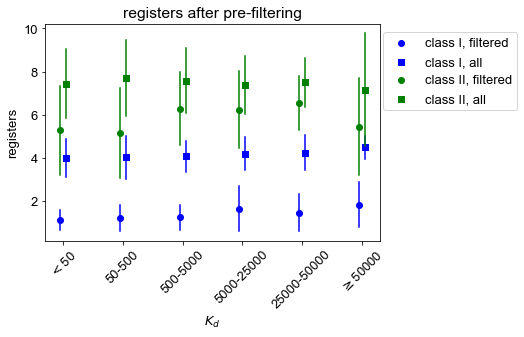

In [60]:

def plot_one(i,x,c='k',m='o',a=[]):
    a.append(plt.scatter(i,np.mean(x),color=c,marker=m))
    plt.plot([i,i],[np.mean(x)-np.std(x),np.mean(x)+np.std(x)],color=c)
plt.figure()
#shifts={'I':-0.1,'II':0.1}
colors={'I':'b','II':'g'}
artists=[]
for cl,df in df_regcounts.items():
    for i,x in enumerate(xticks):
        if i==0:
            a=artists
        else:
            a=[]
        plot_one(i-0.05,df[df[r'$K_d$ interval']==x]['regcount'],c=colors[cl],a=a)
        plot_one(i+0.05,df[df[r'$K_d$ interval']==x]['regcount_all'],c=colors[cl],m='s',a=a)
plt.xticks(np.arange(len(xticks)),xticks,rotation=45)
plt.title('registers after pre-filtering')
plt.ylabel('registers')
plt.xlabel(r'$K_d$')
plt.legend(artists,['class I, filtered','class I, all','class II, filtered','class II, all'],loc=(1.01,0.6))
save_to=fig_dir+'/reg_per_model_class_II.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [66]:
df=df_regcounts['I']
for x in df[df['kd']>=50000]['seqnn_logkds_all']:
    print(x)

[((-1, 0), 5.81723118) ((0, 0), 4.11668444) ((1, 0), 4.96367502)
 ((0, 1), 5.33934641)]
[((-1, 0), 5.37106419) ((0, 0), 3.34534907) ((1, 0), 5.089252  )
 ((0, 1), 5.4611845 )]
[((-1, 0), 5.29199409) ((0, 0), 3.4008646 ) ((1, 0), 4.88656235)
 ((0, 1), 5.33660078)]
[((-1, 0), 4.81341076) ((0, 0), 4.4514513 ) ((1, 0), 3.52285361)
 ((0, 1), 5.03426027) ((0, 2), 5.49503565)]
[((-1, 0), 5.50537062) ((0, 0), 4.37442827) ((1, 0), 4.46296549)
 ((0, 1), 5.26949358) ((0, 2), 5.72434759)]
[((-1, 0), 5.68253183) ((0, 0), 3.04582667) ((1, 0), 5.31629658)
 ((0, 1), 5.35165787)]
[((-1, 0), 5.55522823) ((0, 0), 3.10831022) ((1, 0), 4.7039175 )
 ((0, 1), 5.58546638)]
[((-1, 0), 5.70279169) ((0, 0), 4.23191547) ((1, 0), 5.11383486)
 ((0, 1), 5.71462488)]
[((-1, 0), 5.61090469) ((0, 0), 3.24062657) ((1, 0), 4.89588881)
 ((0, 1), 4.42084265) ((0, 2), 5.46592093)]
[((-1, 0), 5.43342209) ((0, 0), 4.10264874) ((1, 0), 4.74243736)
 ((0, 1), 4.9953022 ) ((0, 2), 5.67145014)]
[((-1, 0), 5.91829729) ((0, 0), 3.98

# prepare data for Rosetta runs

In [4]:
test_dir='/scratch/vmikhayl/pmhc_modeling/test_dataset'
os.listdir(test_dir)

['result_df.pckl', 'inputs', 'target_df.pckl', 'logs', 'outputs']

In [6]:
all_inputs=[]
for x in os.listdir(test_dir+'/inputs'):
    with open(test_dir+f'/inputs/{x}','rb') as f:
        all_inputs+=pickle.load(f)
print(len(all_inputs))
print(all_inputs[0].keys())

tfold_results=pd.read_pickle(test_dir+f'/result_df.pckl')
print(len(tfold_results))
print(tfold_results.columns)

644
dict_keys(['sequences', 'msas', 'template_hits', 'renumber_list', 'target_id', 'current_id', 'registers', 'best_mhc_score', 'best_score', 'true_pdb'])
644
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'tails_prefiltered', 'af_n_reg', 'seqnn_logkd'],
      dtype='object')


In [20]:
#understand which to model
#canonical register, template matches by peplen
template_counts={}
for x in all_inputs:
    tails=tfold_results[tfold_results['pmhc_id']==x['target_id']].iloc[0]['tails']
    if tails==(0,0):
        template_counts.setdefault(x['target_id'],[0,0])
        for t in x['template_hits']:
            pdb_id=t['name']
            if len(summary[pdb_id]['P']['data'])==len(x['sequences'][0]):
                template_counts[x['target_id']][0]+=1
            else:
                template_counts[x['target_id']][1]+=1
print('total pMHCs with canonical register:',len(template_counts))
tstats=np.array(list(template_counts.values()))
print('templates of matching peplen:')
utils.print_hist(tstats[:,0])
print('templates of mismatched peplen:')
utils.print_hist(tstats[:,1])
print('total templates:')
utils.print_hist(np.sum(tstats,axis=1))

#conclusion: keep X matching templates, keep pMHCs with X length-matching templates

#worst case: 900s/model; 
#AF: 5 models/reg => 5*900*100 = 450000s; ~100 cpus: 4500s~1.5hr: okay!
#let's do 5 models, because poor discrimination by energy => worse templates can make it worse
#(maybe even keeping top 1 template would be better)

#what did they do in original papers?
#Baker-CCD: 3 fixed templates, 10 models/template; talaris2014
#FlexpPepDock: 5 models (from different, ~hand-chosen templates)

total pMHCs with canonical register: 98
templates of matching peplen:
0   3
2   6
3   5
4   4
5   2
6   4
7   7
8   1
9   2
10  2
11 10
12  3
13  5
14  8
15  6
16 10
17  4
18 10
19  3
20  3
templates of mismatched peplen:
0  14
1   4
2  11
3   4
4  10
5   6
6   6
7   5
8   4
9  10
10  3
11  2
12  1
13  2
14  2
15  1
16  3
17  3
18  2
20  2
26  1
36  2
total templates:
2   4
3   2
4   1
7   5
11  1
14  1
15  1
20 78
22  2
40  3


In [56]:
#keep ones with canonical reg and at least N templates of matching length;
#use those N templates of matching length

template_lists={} #pmhc_id: [[template_pdb,template_score],..]
for x in all_inputs:
    tails=tfold_results[tfold_results['pmhc_id']==x['target_id']].iloc[0]['tails']
    if tails==(0,0):
        template_lists.setdefault(x['target_id'],[])
        for t in x['template_hits']:
            pdb_id=t['name']
            if len(summary[pdb_id]['P']['data'])==len(x['sequences'][0]):
                template_lists[x['target_id']].append([t['name'],1000-t['sum_probs']])

N=5 #templates per pMHC                
for k in list(template_lists.keys()):
    if len(template_lists[k])<N:
        del template_lists[k]
        continue
    x=np.array([tuple(x) for x in template_lists[k]],dtype=[('name','<U9'),('score',int)])
    x=x[np.argsort(x['score'])][:N]
    template_lists[k]=x
print(len(template_lists))
print('score of top template:')
s_top=np.array([x['score'][0] for x in template_lists.values()])
utils.print_hist(s_top)
print('s<10:',np.sum(s_top<10),'10<s<=15:',np.sum((10<s_top)&(s_top<=15)),'s>15:',np.sum(s_top>15))

#save
with open('./tmp/subset_for_rosetta.pckl','wb') as f:
    pickle.dump(template_lists,f)

80
score of top template:
1    5
2    3
4    3
5    7
6   18
7   13
8    7
9    2
10   1
11   3
18   3
19   1
20   1
26   1
27   2
28   2
30   2
39   2
48   3
105  1
s<10: 58 10<s<=15: 3 s>15: 18


# trash

In [5]:
os.listdir('./data/obj/seqnn')

['weights', 'params', 'model_list_I.pckl', 'model_list_II.pckl']

In [3]:
print('class I')
with open('./data/obj/seqnn/model_list_I.pckl','rb') as f:
    models1=pickle.load(f)
print(len(models1))
print(models1)
print()

print('class II')
with open('./data/obj/seqnn/model_list_II.pckl','rb') as f:
    models1=pickle.load(f)
print(len(models1))
print(models1)

class I
135
[(7, 0, 0, 0), (7, 0, 0, 1), (7, 0, 0, 4), (7, 0, 0, 6), (7, 0, 0, 7), (7, 0, 0, 8), (7, 0, 0, 10), (7, 0, 0, 11), (7, 0, 0, 13), (7, 0, 0, 14), (7, 0, 0, 15), (7, 0, 0, 16), (7, 0, 0, 18), (7, 0, 0, 19), (7, 1, 1, 0), (7, 1, 1, 1), (7, 1, 1, 2), (7, 1, 1, 3), (7, 1, 1, 5), (7, 1, 1, 8), (7, 1, 1, 10), (7, 1, 1, 11), (7, 1, 1, 12), (7, 1, 1, 13), (7, 1, 1, 14), (7, 1, 1, 16), (7, 1, 1, 18), (7, 2, 2, 0), (7, 2, 2, 1), (7, 2, 2, 2), (7, 2, 2, 4), (7, 2, 2, 5), (7, 2, 2, 7), (7, 2, 2, 8), (7, 2, 2, 10), (7, 2, 2, 12), (7, 2, 2, 13), (7, 2, 2, 14), (7, 2, 2, 16), (7, 2, 2, 17), (7, 2, 2, 18), (7, 3, 3, 0), (7, 3, 3, 1), (7, 3, 3, 3), (7, 3, 3, 4), (7, 3, 3, 5), (7, 3, 3, 6), (7, 3, 3, 7), (7, 3, 3, 9), (7, 3, 3, 10), (7, 3, 3, 11), (7, 3, 3, 14), (7, 3, 3, 15), (7, 3, 3, 18), (7, 4, 4, 0), (7, 4, 4, 1), (7, 4, 4, 2), (7, 4, 4, 3), (7, 4, 4, 4), (7, 4, 4, 7), (7, 4, 4, 8), (7, 4, 4, 9), (7, 4, 4, 10), (7, 4, 4, 12), (7, 4, 4, 13), (7, 4, 4, 14), (7, 4, 4, 15), (7, 4, 4, 16), (7

In [37]:
nn_input_dir='/scratch/vmikhayl/tmp_pmhc_nn/inputs'
print(np.sort([int(x.split('_')[1].split('.')[0]) for x in os.listdir(nn_input_dir)]))

import json
def _get_params(n):
    with open(nn_input_dir+f'/run_{n}.json') as f:
        x=json.loads(f.read())
    print(f'run {n}:',len(x))
    print(x[0].keys())
    return x

def _print_params(n):
    x=_get_params(n)
    for k in ['split_n','model_n','use_tails','epochs','regmasks','pep_mask']:
        print(k)
        utils.print_hist([str(y[k]) for y in x])

_print_params(8)  #seqnn cl II step 1
print()
_print_params(11) #seqnn cl II step 2
print()
_print_params(31) #seqnn-f step 1
print()
_print_params(33) #seqnn-f step 2

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
run 8: 200
dict_keys(['split_n', 'cl', 'pep_mask', 'regmasks', 'model', 'reduce_model', 'use_tails', 'n_hidden', 'actn', 'dropout_rate', 'batch_norm', 'epochs', 'batch_size', 'inference_batch_size', 'save_weights', 'save_image_losses', 'save_image_regerrors', 'run_n', 'cpu_n', 'output_dir', 'model_n', 'copy_n'])
split_n
0 40
1 40
2 40
3 40
4 40
model_n
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
use_tails
True 200
epochs
[15] 200
regmasks
None 200
pep_mask
None               100
[1, 2, 4, 6, 7, 9] 100

run 11: 150
dict_keys(['split_n', 'cl', 'pep_mask', 'regmasks', 'model', 'reduce_model', 'use_tails', 'n_hidden', 'actn', 'dropout_rate', 'batch_norm', 'epochs', 'batch_size', 'inference_batch_size', 'save_weights', 'save_image_losses', 'save_image_regerrors', 'run_n', 'cpu_n', 'output_dir', 'model_n', 'copy_n'])
split_n
0 30
1 30
2 30
3 30
4 30
model_n
0 15
1 15
2 15
3 15
4 15


In [35]:
#masks 1 and 2: couldn't find info! Look into it here...
mask_dir='/scratch/vmikhayl/tmp_pmhc_nn/masks'

def _open_mask(n):
    with open(mask_dir+f'/mask_{n}_1.pckl','rb') as f:
        x=pickle.load(f)
    return x

x=_open_mask(1)
print(len(x))
utils.print_hist([len(y) for y in x])

x=_open_mask(2)
print(len(x))
utils.print_hist([len(y) for y in x])

113576
1  17841
2  19409
3  15505
4  14129
5  14903
6  15044
7  14048
8   1100
9    796
10   517
11   197
12    82
13     4
14     1
113576
1  59467
2     27
3    131
4     84
5   1480
6    863
7  44908
8   1767
9   1179
10   964
11   318
12  2169
13   186
14    10
15     5
16    10
17     8


In [33]:
x[0]

array([(5, 1), (6, 0)], dtype=object)

In [3]:
help(utils.proportions_p_value)

Help on function proportions_p_value in module tfold.utils.utils:

proportions_p_value(n1, N1, n2, N2, n_repeats=10000)
    significance of difference between proportions via simulation
    (idea from Coursera; should be used when numbers are small so that the normal approx doesn't work)
    fix total N and total failures, shuffle, see distribution of f1-f2;
    takes numbers of successes and totals for two conditions, returns two-sided p-value



In [6]:
#regerr cl I discovery (total 270)
#netmhc 9
#seqnn  6
#tfold  2

#tfold vs seqnn  0.288
#tfold vs netmhc 0.065
#both not significant
utils.proportions_p_value(2,270,6,270)

0.2882

In [7]:
6**0.5

2.449489742783178

In [10]:
#5trz
struct_i

Index(['id', 'date', 'pmhc_id', 'class', 'tails', 'netmhc_tails', 'netmhc_kd',
       'pep', 'mhc_a', 'mhc_b'],
      dtype='object')

In [15]:
#discovery regerr #1
pdb_id='5trz'
for x in pmhcs:
    if pdb_id+'_0' in [a[0] for a in x['pdbs']]:
        pmhc_id=x['id']
        break
struct_i[struct_i['pmhc_id']==pmhc_id]

,id,date,pmhc_id,class,tails,netmhc_tails,netmhc_kd,pep,mhc_a,mhc_b
137,153,2016-10-27,185,I,"(-1, 1)","(0, 0)",5675.539316,YQSGLSIVM,<tfold.utils.seq_tools.NUMSEQ object at 0x7f09...,None


In [30]:
#discovery regerr #2
pmhc_id=484
print(pmhcs[pmhc_id]['pdbs'])
x=struct_i[struct_i['pmhc_id']==pmhc_id].iloc[0]
print(x)
x['pep'],x['mhc_a'].info['species']

[('5ymv_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.2, 'includes_tcr': 0}), ('5ymv_1', {'pep_gaps': 0, 'linker': False, 'resolution': 2.2, 'includes_tcr': 0})]
id                                                            307
date                                                   2017-10-22
pmhc_id                                                       484
class                                                           I
tails                                                      (0, 1)
netmhc_tails                                               (0, 0)
netmhc_kd                                             6639.604361
pep                                                     AVKGVGTMV
mhc_a           <tfold.utils.seq_tools.NUMSEQ object at 0x7f06...
mhc_b                                                        None
Name: 281, dtype: object


('AVKGVGTMV', '9031')

In [28]:
x['mhc_a'].values

array([<tfold.utils.seq_tools.NUMSEQ object at 0x7f06dbf3f070>],
      dtype=object)

In [135]:
#CA clusters for class II (did I use them for template restrictions?)
cluster_counts={'I':{'seq_id':[],'CA_id':[],'mhc':[]},'II':{'seq_id':[],'CA_id':[],'mhc':[]}}
for x in pmhcs:
    d=cluster_counts[x['class']]
    d['seq_id'].append(x['cluster_seq'])
    d['CA_id'].append(x['cluster_CA'])
    if x['class']=='I':
        k='M'
    else:
        k='N'
    d['mhc'].append((x[k]['info']['species'],x[k]['info']['locus'],x[k]['info']['allele']))
for c,v in cluster_counts.items():
    cluster_counts[c]=pd.DataFrame(v)

In [145]:
x=cluster_counts['II']
print(len(x),len(x['seq_id'].unique()),len(x['CA_id'].unique()))
print(len(x.apply(lambda a:(a['seq_id'],a['CA_id']),axis=1).unique())) #unique pairs seq,CA
#reduce to DQ
x=x[x['mhc'].map(lambda a: (a[0]=='9606')&('DQ' in a[1]))]
print(len(x),len(x['seq_id'].unique()),len(x['CA_id'].unique()))
print(len(x.apply(lambda a:(a['seq_id'],a['CA_id']),axis=1).unique())) #unique pairs seq,CA

#it was not a great idea to drop templates from other CA clusters for class II,
#since score depends on seq similarity, and in this way we are wasting some seq clusters
#although only a few, since seq and CA clusters are mostly 1-1
print(x.sort_values('CA_id').head(20))

129 88 88
99
20 15 15
17
     seq_id  CA_id                  mhc
3        34    401  (9606, DQB1, 02:01)
8        72    406  (9606, DQB1, 02:01)
11       78    409  (9606, DQB1, 02:01)
20      129    416  (9606, DQB1, 03:02)
27      171    422  (9606, DQB1, 02:01)
40      221    432  (9606, DQB1, 03:02)
115     221    432  (9606, DQB1, 03:02)
47      252    436  (9606, DQB1, 02:01)
51      258    438  (9606, DQB1, 03:02)
105     258    438  (9606, DQB1, 03:02)
80      258    438  (9606, DQB1, 03:02)
56      286    442  (9606, DQB1, 02:01)
57      296    443  (9606, DQB1, 02:01)
63      310    447  (9606, DQB1, 06:02)
69      321    453  (9606, DQB1, 02:01)
109     286    453  (9606, DQB1, 02:01)
106     420    474  (9606, DQB1, 03:02)
125     480    483  (9606, DQB1, 03:02)
50      171    484  (9606, DQB1, 02:01)
127     482    484  (9606, DQB1, 02:01)


In [149]:
# human allele counts by locus
d={}
for k in seq_tools.mhcs:
    if k[0]=='9606':
        d.setdefault(k[1],0)
        d[k[1]]+=1
for k in np.sort(list(d.keys())):
    print(k,d[k])

A 4141
B 5081
C 3910
DPA1 132
DPB1 1173
DQA1 171
DQB1 1319
DRA 2
DRB1 2054
DRB3 300
DRB4 131
DRB5 124
E 109
F 6
G 26


In [15]:
#pep len, reg examples in cl I
keep=[(8,-1,0),(8,0,0),(9,0,0),(9,1,0),(10,0,1),(13,0,0),(12,0,1)]
keep_d={k:False for k in keep}

for x in pmhcs:
    if x['class']=='I':
        k=(len(x['P']['data']),x['tails'][0],x['tails'][1])
        if (k in keep) and (not keep_d[k]) and ('X' not in x['P']['data']['seq']):
            print(k)
            print(''.join(x['P']['data']['seq']))
            print('|'.join(x['P']['data']['pdbnum']))
            print()
            keep_d[k]=True

(9, 0, 0)
EEAGRAFSF
   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 

(10, 0, 1)
GLKEGIPALD
   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 

(8, 0, 0)
SIIVFNLV
   1 |   2 |   3 |   4 |   5 |   7 |   8 |   9 

(8, -1, 0)
HVAVENAL
   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 

(9, 1, 0)
KAVYNFATM
   09|   1 |   2 |   3 |   4 |   5 |   7 |   8 |   9 

(13, 0, 0)
APRGPHGGAASGL
   1 |   2 |   3 |   4 |   5 |   51|   52|   58|   59|   6 |   7 |   8 |   9 

(12, 0, 1)
FVLELEPEWTVK
   1 |   2 |   3 |   4 |   5 |   51|   59|   6 |   7 |   8 |   9 |  10 



In [26]:
#count linkers, by class
pdb_linkers={}
for k,v in summary.items():
    if 'P' in v:
        x=(v['M']['info']['class'],np.any(v['P']['info']['linker']))
        pdb_linkers.setdefault(x,set())
        pdb_linkers[x].add(k.split('_')[0])
for k,v in pdb_linkers.items():
    print(k,len(v))

#fractions
print('fraction with linkers:')
for cl in ['I','II']:
    print(f'class {cl}:',len(pdb_linkers[cl,True])/(len(pdb_linkers[cl,True])+len(pdb_linkers[cl,False])))

('I', False) 1044
('II', True) 45
('II', False) 132
('I', True) 14
fraction with linkers:
class I: 0.013232514177693762
class II: 0.2542372881355932


In [11]:
d={True:1,False:0}
d[True]

1

In [14]:
#my permutation test vs Fisher's exact test: it's the same thing

#class II discovery regerr netmhciipan-3.2 vs tfold
n1,n2=1,14
N1,N2=62,62
print(utils.proportions_p_value(n1,N1,n2,N2,100000))
table=[[n1,n2],[N1-n1,N2-n2]]
print(fisher_exact(table))
#same!

#class II tfold discovery vs test
n1,n2=1,1
N1,N2=62,11
print(utils.proportions_p_value(n1,N1,n2,N2,100000))
table=[[n1,n2],[N1-n1,N2-n2]]
print(fisher_exact(table))

0.0005
(0.05620608899297424, 0.00047535224697001915)
0.27946
(0.16393442622950818, 0.28044140030441395)
